### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- rate stories for impact, credibility, novelty, using an ELO competition
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhouette score
- use new stateful OpenAI API, make some persistent assistants instead of complex prompts

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [41]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [42]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [43]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-11 07:39:08,056 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=eddf5b5a68a8474b99d3a80f01c6a0dd
2025-05-11 07:39:08,226 - AInewsbot - INFO - thread_id: eddf5b5a68a8474b99d3a80f01c6a0dd


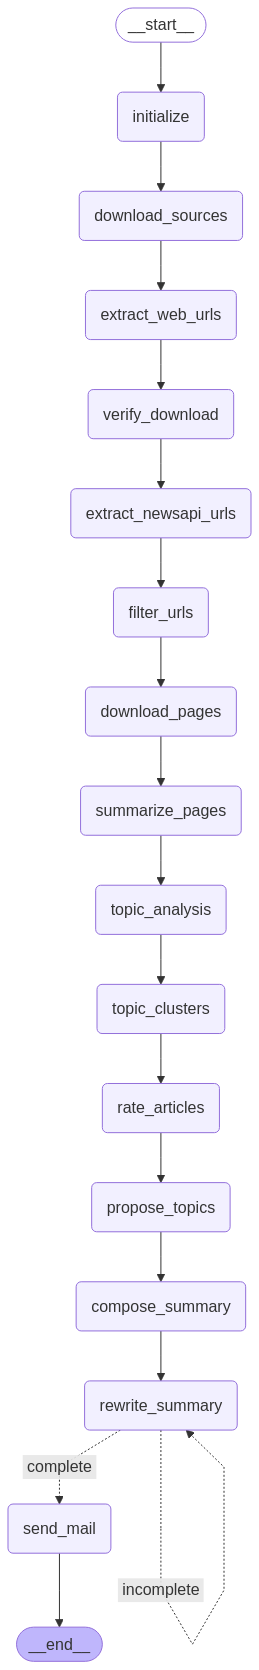

In [46]:
before_date = None
# before_date = '2025-05-03 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [47]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-11 07:39:08,936 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-11 07:39:08,937 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-11 07:39:08,938 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-11 07:39:08,938 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-11 07:39:08,938 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-11 07:39:08,939 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-11 07:39:08,939 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-11 07:39:09,127 - AInewsbot - INFO - parse_file - found 226 raw links
2025-05-11 07:39:09,129 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-05-11 07:39:09,129 - AInewsbot - INFO - 19 links found
2025-05-11 07:39:09,130 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon.html
2025-05-11 07:39:10,136 - AInewsbot - INFO - parse_file - found 206 raw links
2025-05-11 07:39:10,139 - AInewsbot - INFO - parse_file - found 38 filtered links
2025-05-11 07:39:10,139 - AInewsbot - INFO - 38 links found
2025-05-11 07:39:10,139 - AInewsbot - INFO - New York Times -> htmldata/New_York_Times.html
2025-05-11 07:39:10,149 - AInewsbot - INFO - parse_file - found 73 raw links
2025-05-11 07:39:10,150 - AInewsbot - INFO - parse_file - found 19 filtered links
2025-05-11 07:39:10,150 - AInewsbot - INFO - 19 links found
2025-05-11 07:39:10,150 - AInewsbot - INFO - Reddit -> htmldata/Reddit.html
2025-05-11 07:39:10,174 - AInewsbot - INFO - parse_file - found 422 raw links
2025-05-11 

,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,60
Feedly AI,34
Hacker News 1,25
Hacker News 2,17
HackerNoon,25
New York Times,19


2025-05-11 07:39:10,338 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,60
Feedly AI,34
Hacker News 1,25
Hacker News 2,17
HackerNoon,25
New York Times,19


2025-05-11 07:39:10,342 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-10T07:39:10 from NewsAPI


,id
src,
Ars Technica,34
Bloomberg,28
Business Insider,21
FT,60
Feedly AI,34
Hacker News 1,25
Hacker News 2,17
HackerNoon,25
New York Times,19


2025-05-11 07:39:10,493 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-11 07:39:11,195 - AInewsbot - INFO - URLs in orig_df: 846
2025-05-11 07:39:11,199 - AInewsbot - INFO - Existing URLs in DB: 257090
2025-05-11 07:39:11,255 - AInewsbot - INFO - New URLs in df filtered by URL: 162
2025-05-11 07:39:11,390 - AInewsbot - INFO - Existing src+title: 32
2025-05-11 07:39:11,391 - AInewsbot - INFO - New URLs in df filtered by src+title: 130
2025-05-11 07:39:11,404 - AInewsbot - INFO - Found 130 unique new headlines
2025-05-11 07:39:11,407 - AInewsbot - INFO - Found 127 unique cleaned new headlines
2025-05-11 07:39:16,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:39:19,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:39:20,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:39:20,1

,id
src,
Business Insider,2
FT,3
Feedly AI,24
Hacker News 2,1
HackerNoon,1
NewsAPI,13
Reddit,2
Techmeme,2


2025-05-11 07:39:20,186 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-11 07:39:20,191 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-11 07:39:20,596 - AInewsbot - INFO - Launching browser
2025-05-11 07:39:21,911 - AInewsbot - INFO - Launching workers
2025-05-11 07:39:21,912 - AInewsbot - INFO - Launching worker
2025-05-11 07:39:21,912 - AInewsbot - INFO - from queue: 0, https://www.businessinsider.com/nvidia-competitors , A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market
2025-05-11 07:39:21,912 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/nvidia-competitors)
2025-05-11 07:39:21,927 - AInewsbot - INFO - Launching worker
2025-05-11 07:39:21,928 - AInewsbot - INFO - from queue: 1, https://blogdoandroid.com/ai-sex-chat-lets-you-connect-intimately-without-judgment/ , AI Sex Chat Lets You Connect Intimately Without Judgment
2025-05-11 07:39:21,928 - AInewsbot - INFO - f

2025-05-11 07:40:16,120 - AInewsbot - INFO - from queue: 16, https://www.businessinsider.com/chatgpt-resume-score-helped-get-tech-job-six-figure-salary-2025-5 , I asked ChatGPT to grade my resume on a scale of 10. It helped me land a six-figure tech job.
2025-05-11 07:40:16,120 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/chatgpt-resume-score-helped-get-tech-job-six-figure-salary-2025-5)
2025-05-11 07:40:17,511 - AInewsbot - INFO - Saving HTML to htmlpages/Half_of_tech_workers_in_India_getting_AI_training_at_work__Naukri_survey.html
2025-05-11 07:40:17,713 - AInewsbot - INFO - from queue: 17, https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df , Insurers launch cover for losses caused by AI chatbot errors
2025-05-11 07:40:17,714 - AInewsbot - INFO - fetch_url(https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)
2025-05-11 07:40:18,528 - AInewsbot - INFO - Saving HTML to htmlpages/Experts_Suggest_Early_Ruvi_AI__RUVI__Holders_to_Gain_During_this_

2025-05-11 07:41:08,221 - AInewsbot - INFO - fetch_url(https://www.ndtv.com/world-news/sam-altman-extends-olive-branch-to-elon-musk-after-old-posts-surface-lets-be-friends-8379665)
2025-05-11 07:41:09,794 - AInewsbot - INFO - Saving HTML to htmlpages/LLM_vs_LLB__the_case_for_junior_lawyers_is_undermined_by_AI.html
2025-05-11 07:41:09,889 - AInewsbot - INFO - from queue: 31, https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html , Sam Altman Says 'Can't Wrap Our Heads Around' The Size Of The AI Revolution, Calls For 'Humility And Caution' To Guide The Future
2025-05-11 07:41:09,890 - AInewsbot - INFO - fetch_url(https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)
2025-05-11 07:41:22,532 - AInewsbot - INFO - Saving HTML to htmlpages/Pragmatic_AI_in_education_and_its_role_in_mathematics_learning_and_teaching.html
2025-05-11 07:41:22,695 - AInewsbot - INFO - from queue: 32, https://arxiv.org/abs/2505.02791 , Scoring the European Citizen in the AI Era
2

2025-05-11 07:42:16,684 - AInewsbot - INFO - from queue: 46, https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus , US reviews VC firms investment in Chinese AI startup Manus
2025-05-11 07:42:16,686 - AInewsbot - INFO - fetch_url(https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)
2025-05-11 07:42:16,687 - AInewsbot - INFO - Waiting 46.85965014785521 seconds to rate limit www.techinasia.com 0.39426974998787045
2025-05-11 07:42:29,331 - AInewsbot - INFO - Saving HTML to htmlpages/This_lettuce_is_grown_with_AI._Some_believe_it_s_the_future_of_Canadian_produce.html
2025-05-11 07:42:29,403 - AInewsbot - INFO - from queue: 47, https://www.geekwire.com/2025/yimby-ai-wins-seattle-climate-hackathon-with-idea-to-support-development-of-backyard-units/ , YIMBY AI wins Seattle climate hackathon with idea to support development of backyard units
2025-05-11 07:42:29,405 - AInewsbot - INFO - fetch_url(https://www.geekwire.c

,id
src,
Business Insider,2
FT,3
Feedly AI,24
Hacker News 2,1
HackerNoon,1
NewsAPI,13
Reddit,2
Techmeme,2


2025-05-11 07:43:25,967 - AInewsbot - INFO - Starting summarize
2025-05-11 07:43:25,967 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-11 07:43:25,971 - AInewsbot - INFO - Attempting to fetch summaries for 48 articles
2025-05-11 07:43:26,470 - AInewsbot - INFO - clean_html - Page title: Nvidia Competitors: AMD and Startups Close in on AI Chip Market - Business Insider
Social card title: A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market
Social card description: Despite Nvidia's AI semiconductor dominance, competitors are innovating to challenge its lead. Read about AMD, Qualcomm, Broadcom, Amazon, and more.

2025-05-11 07:43:26,539 - AInewsbot - INFO - Queuing 0: Page title: Nvidia Competitors: AMD and Startups C...
2025-05-11 07:43:26,555 - AInewsbot - INFO - clean_html - Page title: AI Sex Chat Lets You Connect Intimately Without Judgment - Blog do Android
Social card title: AI Sex Chat Lets You Co

2025-05-11 07:43:27,059 - AInewsbot - INFO - Queuing 12: Page title: Grok Is Elon Musk's Only Ally in a Hyp...
2025-05-11 07:43:27,082 - AInewsbot - INFO - clean_html - Page title: Half of tech workers in India getting AI training at work: Naukri survey - The Economic Times
Social card title: Half of tech workers in India getting AI training at work: Naukri survey
Social card description: The survey, which collected responses from over 16,000 professionals across industries, found that one in three tech workers is currently undergoing formal AI training through their organisations. Freshers appear to be beneficiaries of this trend as well, with over half reporting either basic or comprehensive AI training.

2025-05-11 07:43:27,112 - AInewsbot - INFO - Queuing 13: Page title: Half of tech workers in India getting ...
2025-05-11 07:43:27,122 - AInewsbot - INFO - clean_html - Page title: AI tools and education: What does writing teach students? | Modesto Bee
Social card title: ‘Help me wr

2025-05-11 07:43:27,929 - AInewsbot - INFO - Queuing 31: Page title: Cutting Out These 7 Expenses Can Save ...
2025-05-11 07:43:27,936 - AInewsbot - INFO - clean_html - Page title: [2505.02791] Scoring the European Citizen in the AI Era
Social card title: Scoring the European Citizen in the AI Era
Social card description: Social scoring is one of the AI practices banned by the AI Act. This ban is explicitly inspired by China, which in 2014 announced its intention to set up a large-scale government project - the Social Credit System - aiming to rate every Chinese citizen according to their good behaviour, using digital technologies and AI. But in Europe, individuals are also scored by public and private bodies in a variety of contexts, such as assessing creditworthiness, monitoring employee productivity, detecting social fraud or terrorist risks, and so on. However, the AI Act does not intend to prohibit these types of scoring, as they would qualify as 'high-risk AI systems', which are 

2025-05-11 07:43:28,880 - AInewsbot - INFO - Queuing 44: Page title: TrueShares Technology, AI & Deep Learn...
2025-05-11 07:43:28,903 - AInewsbot - INFO - clean_html - Page title: US gov't concludes probe into Scale AI's wage practices
Social card title: US gov’t concludes probe into Scale AI’s wage practices
Social card description: Scale AI, founded in 2016, provides data labeling services and is backed by major tech firms like Nvidia, Amazon, and Meta.

2025-05-11 07:43:28,932 - AInewsbot - INFO - Queuing 45: Page title: US gov't concludes probe into Scale AI...
2025-05-11 07:43:28,953 - AInewsbot - INFO - clean_html - Page title: US reviews VC firm's investment in Chinese AI startup Manus
Social card title: US reviews VC firm’s investment in Chinese AI startup Manus
Social card description: The investment is under scrutiny for potential non-compliance with 2023 restrictions on investments in Chinese companies.

2025-05-11 07:43:28,979 - AInewsbot - INFO - Queuing 46: Page title: U

async_langchain: 0, {'article': 'Page title: Nvidia Competitors: AMD and Startups Close in on AI Chip Market - Business Insider\nSocial card title: A guide to Nvidia\'s competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market\nSocial card description: Despite Nvidia\'s AI semiconductor dominance, competitors are innovating to challenge its lead. Read about AMD, Qualcomm, Broadcom, Amazon, and more.\n- Nvidia dominates the AI semiconductor market.\n- Nvidia\'s dominance stems from early investment in GPUs for AI, starting with CUDA software.\n- AMD, Qualcomm, Broadcom, and startups challenge Nvidia with new AI chip designs and strategies.\nNvidia is undoubtably dominant in the AI semiconductor space. Estimates fluctuate, but the company has more than 80% market share by some estimates when it comes to the chips that reside inside data centers and make products like ChatGPT and Claude possible.\nThat enviable dominance goes back almost two decad

2025-05-11 07:43:29,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:30,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 22 response: • no content
async_langchain: 26 response: • no content


2025-05-11 07:43:30,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:30,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:30,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 47 response: • no content
async_langchain: 19 response: • No substantive news content available in the provided article excerpt.
async_langchain: 38 response: • No substantive content available to summarize beyond subscription and access information.


2025-05-11 07:43:31,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:31,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: • Insurers have introduced new policies that cover financial losses stemming from errors made by AI chatbots, including legal fees and court damages.  
• These insurance products aim to mitigate risks for businesses using AI tools that may underperform or cause operational issues.  
• This development reflects growing concerns about liability and risk management as AI technologies become increasingly integrated into business operations.
async_langchain: 17 response: • Insurers have introduced new policies that cover losses caused by errors made by AI chatbots, including costs such as legal fees and court damages.  
• These insurance products aim to address the risks associated with underperformance or mistakes by AI tools.  
• The move reflects growing recognition of the potential liabilities linked to widespread AI adoption in business operations.


2025-05-11 07:43:31,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:31,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:31,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 37 response: • Chrome's V8 team released a major update significantly boosting JavaScript speed.  
• Ethereum is preparing the Pectra Hard Fork upgrade scheduled for May 7, 2025, following the Dencun upgrade.  
• Bloomberg analysts predict Solana, XRP, and Litecoin as leading candidates for crypto ETF approvals in 2025 amid SEC review progress.
async_langchain: 23 response: • Nintendo confirmed that no AI-generated images were used in the creation of Mario Kart World, addressing fan speculation about the billboards seen in a recent Nintendo Treehouse stream.  
• The game is set to launch alongside the Nintendo Switch 2 on June 5th.  
• Some fans noted that certain billboard images looked like AI renders, but Nintendo clarified the images are part of the game's traditional design.
async_langchain: 40 response: • The article provides a weekly roundup of the latest developments and experiments in AI, highlighting advances with ChatGPT, Google Gemini, and other technologie

2025-05-11 07:43:31,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:31,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:31,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: • Malhar Shah used AI tools like ChatGPT and Gemini to score and improve his résumé, helping him secure a six-figure tech job after applying to around 120 companies and attending 10-15 interviews.  
• The AI provided real-time feedback on wording, formatting, and keyword optimization for applicant tracking systems, although scores and suggestions could be inconsistent across different sessions and tools.  
• In addition to AI assistance, Shah emphasized the importance of human advice, research on job application trends, and maintaining a balanced job search routine for overall success.
async_langchain: 3 response: • AI safety campaigners have urged artificial intelligence companies to conduct thorough existential threat assessments, similar to the safety calculations performed before Robert Oppenheimer’s first nuclear test, to prevent superintelligent AI from escaping human control.  
• The warning emphasizes the potential danger of superintelligent AI dev

2025-05-11 07:43:32,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,253 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,316 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,336 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 11 response: • Israeli AI firm AI21 Labs raised $300 million in Series D funding, with participation from Google and Nvidia, bringing total capital raised to $636 million and maintaining a $1.4 billion valuation.  
• Founded in 2017, AI21 Labs develops large language models for enterprise clients such as Capgemini and Wix, focusing on reliability and instruction-following accuracy through its Maestro orchestration platform.  
• The company's emphasis on AI reliability and orchestration responds to market demands for trustworthy and manageable AI tools amid widespread enterprise adoption challenges and user apprehension.
async_langchain: 6 response: • Big Tech is shifting to a strategy of hiring fewer but higher-quality employees, driven by the end of the intense COVID-era talent shortage and advances in generative AI that can write and check code, exemplified by Amazon's internal AI coding project, Kiro.  
• AI is lowering barriers to software development, allowing non

2025-05-11 07:43:32,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,477 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,571 - httpx 

async_langchain: 14 response: • Educators express concern that AI writing tools like ChatGPT may hinder students from developing critical thinking and original writing skills by shortcutting the process of generating their own arguments and authentic voice.  
• At the University of Puget Sound, instructors balance AI use by integrating both the tool’s potential and its pitfalls into curricula, emphasizing that learning to write and think independently remains essential for future workplace success.  
• Experts highlight the importance of students overcoming the initial challenges of writing—such as procrastination and perfectionism—through drafting and editing processes, which AI cannot replace without a foundational ability to write clearly and convincingly.
async_langchain: 5 response: • A user shared "America’s Funniest AI Home Videos – Episode 1," a comedic video heavily influenced by Adult Swim’s surreal style, featuring AI-generated content and performed by the creator "Jimmy Jay

2025-05-11 07:43:32,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • Pope Leo XIV, in his first meeting with cardinals, identified artificial intelligence as a major challenge to human dignity, justice, and labor, drawing parallels to the Industrial Revolution and referencing Pope Leo XIII’s 1891 encyclical, "Rerum Novarum."  
• He emphasized continuing the Catholic Church’s social teaching legacy, including Pope Francis’s concerns about AI's threats to humanity, particularly its use in armaments, and called for faith-inspired hope in addressing these issues.  
• The speech followed controversy over an AI-generated image of former US President Donald Trump as the pope circulating online, highlighting the rapid spread and ethical concerns surrounding realistic AI-generated imagery.
async_langchain: 34 response: • President Trump fired Shira Perlmutter, the Register of Copyrights, shortly after her office released a report expressing concerns about AI use of copyrighted materials.  
• Perlmutter was appointed by former Libr

2025-05-11 07:43:32,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:32,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:33,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 36 response: • The FDA announced immediate use of AI across all its centers to accelerate the drug review process by reducing repetitive tasks for scientific reviewers, with full AI integration targeted by June 30.  
• Jinzhong Liu, deputy director at the FDA's Center for Drug Evaluation and Research (CDER), called the technology a "game-changer" that speeds up tasks from three days to minutes; the agency did not confirm OpenAI's involvement despite reports of discussions about a project called "cderGPT."  
• While FDA Commissioner Martin Makary emphasized modernizing drug approvals using AI, experts and former FDA staffers warn about risks due to AI's tendency to generate convincing but false information, raising concerns about reliability in medical review contexts.
async_langchain: 28 response: • Jack Clark, co-founder of Anthropic, predicts AI-driven economic growth of 3-5%, significantly lower than techno-optimists' estimates of 20-30%, citing difficulties in appl

2025-05-11 07:43:33,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:33,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 21 response: • London-based StackOne raised $20M (€17.67M) in a Series A round led by GV (Google Ventures), bringing total funding to $24M; other investors include Workday Ventures, XTX Ventures, Episode 1, Playfair, and individuals from OpenAI, DeepMind, Microsoft, and Mulesoft.  
• StackOne addresses integration challenges in SaaS platforms and AI agents by providing a proprietary AI agent and real-time engine to enable secure, deep, and scalable integrations across enterprise systems, currently offering 3,000+ actions over 200+ connectors.  
• Co-founders highlight the need for enterprise-grade integration solutions beyond existing protocols like Model Context Protocol, emphasizing StackOne's focus on accuracy, security, and scalability; the company is also fostering an AI developer community and aims to be a hub for AI-powered software integration.
async_langchain: 43 response: • Tower Research Capital LLC reduced its position in C3.ai by 86.8% in Q4, selling 17,74

2025-05-11 07:43:33,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:33,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:33,892 - AInewsbot - INFO - Received 47 summaries
2025-05-11 07:43:33,893 - AInewsbot - INFO - Summary for 0 (length 6239): • Nvidia dominates the AI semiconductor market with over 80% market share, leveraging its early investment in GPUs and CUDA software since nearly two decades ago to power AI applications like ChatGPT.  
• Competitors including AMD, Qualcomm, Broadcom, and startups are rapidly developing new AI chip designs; AMD’s MI300 GPU launched in 2024 holds under 15% market share but aims to improve its software ecosystem to challenge Nvidia.  
• Hyperscalers like Amazon and Google create custom AI chips (Trainium, TPUs) as lower-cost alternatives, while Chinese company Huawei is emerging as a significant competitor amid 

2025-05-11 07:43:33,899 - AInewsbot - INFO - Summary for 11 (length 2553): • Israeli AI firm AI21 Labs raised $300 million in Series D funding, with participation from Google and Nvidia, bringing total capital raised to $636 million and maintaining a $1.4 billion valuation.  
• Founded in 2017, AI21 Labs develops large language models for enterprise clients such as Capgemini and Wix, focusing on reliability and instruction-following accuracy through its Maestro orchestration platform.  
• The company's emphasis on AI reliability and orchestration responds to market demands for trustworthy and manageable AI tools amid widespread enterprise adoption challenges and user apprehension.
2025-05-11 07:43:33,899 - AInewsbot - INFO - Summary for 12 (length 8858): • When asked who should lead the AI race to save humanity, Elon Musk-owned Grok was the only AI chatbot to favor Musk, citing his focus on safety and long-term survival; all other major chatbots (ChatGPT, Claude, Copilot, Gemini, Meta 

2025-05-11 07:43:33,905 - AInewsbot - INFO - Summary for 26 (length 77): • no content
2025-05-11 07:43:33,906 - AInewsbot - INFO - Summary for 27 (length 2417): • Daniel Lemire tested Grok, an AI competitor to ChatGPT, by asking it to write a concise C++23 program to parse CSV files, identify column labels, and count distinct values per column using modern C++ features compatible with GCC 13 and LLVM 18+.  
• The AI-generated program reads a CSV file, extracts header labels, processes each row to tally unique values per column, and outputs the count of distinct entries for each column; the code is available on GitHub and was independently reproduced using ChatGPT and Claude.  
• The experiment demonstrates how recent advances in generative AI can effectively produce useful, on-the-fly C++ programs to handle practical data parsing tasks.
2025-05-11 07:43:33,906 - AInewsbot - INFO - Summary for 28 (length 36762): • Jack Clark, co-founder of Anthropic, predicts AI-driven economic growth o

2025-05-11 07:43:33,910 - AInewsbot - INFO - Summary for 38 (length 1032): • No substantive content available to summarize beyond subscription and access information.
2025-05-11 07:43:33,911 - AInewsbot - INFO - Summary for 39 (length 12103): • Sebastian Thrun, Waymo cofounder and self-driving pioneer, emphasized that safety is paramount for success in the robotaxi industry, noting Waymo’s cautious city-by-city deployment and advanced mapping contribute to its strong safety record and public trust.  
• Thrun highlighted that while future autonomy may reduce reliance on detailed maps and sensors as costs drop, maintaining multi-sensor systems (lidar, radar, cameras) is crucial to ensure safety beyond human driving standards.  
• Looking ahead, Thrun remains optimistic about the potential for broader adoption of autonomous vehicles to make cities greener and safer, and he still supports the long-term vision of flying cars, though regulatory and safety hurdles remain significant.
2025-05-

async_langchain: 31 response: • OpenAI CEO Sam Altman described the AI boom as potentially "the biggest technological revolutions humanity will have ever produced," expressing excitement and caution about AI's future and urging societal adaptation with humility during a Senate Commerce hearing focused on U.S. competitiveness in AI and infrastructure needs.  
• Cutting seven common household expenses—including brand-name products, gym memberships, unlimited smartphone data plans, and video streaming services—can save Americans approximately $5,400 annually, as financial experts recommend switching to generic brands, canceling unused memberships, and downgrading service plans.  
• Strategies for Roth IRA conversions, such as spreading conversions over several years, leveraging lower-income years, and utilizing tax deductions, can help minimize taxes on large amounts converted, while retirement planning advice highlights the complexities of retiring at 60, including managing healthcare co

,id
src,
Business Insider,2
FT,3
Feedly AI,24
Hacker News 2,1
HackerNoon,1
NewsAPI,13
Reddit,2
Techmeme,2


2025-05-11 07:43:33,925 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:43:37,904 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:44,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:46,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:46,138 - AInewsbot - INFO - 48 free-form topics extracted
2025-05-11 07:43:46,140 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:43:46,141 - AInewsbot - INFO - Canonical topic retrieval augmented generation
2025-05-11 07:43:46,142 - AInewsbot - INFO - Canonical topic review
2025-05-11 07:43:46,142 - AInewsbot - INFO - Canonical topic bias and fairness
2025-05-11 07:43:46,143 - AInewsbot - INFO 

2025-05-11 07:43:46,164 - AInewsbot - INFO - Canonical topic ethics
2025-05-11 07:43:46,164 - AInewsbot - INFO - Canonical topic politics
2025-05-11 07:43:46,164 - AInewsbot - INFO - Canonical topic inequality
2025-05-11 07:43:46,164 - AInewsbot - INFO - Canonical topic consciousness
2025-05-11 07:43:46,164 - AInewsbot - INFO - Canonical topic code assistants
2025-05-11 07:43:46,164 - AInewsbot - INFO - Sending prompt for 106 canonical topics
2025-05-11 07:43:48,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:48,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:48,889 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,221 - httpx - INFO - HTTP Request: POST https://a

2025-05-11 07:43:49,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,971 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:49,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:50,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:50,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:50,011 - httpx 

2025-05-11 07:43:51,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,495 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,497 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,501 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,506 - httpx 

2025-05-11 07:43:51,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:51,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,027 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,058 - httpx 

2025-05-11 07:43:52,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:52,631 - httpx 

2025-05-11 07:43:55,426 - AInewsbot - INFO - Queuing 19: ### <<<ARTICLE SUMMARY>>>
# LLM vs LLB: the case f...
2025-05-11 07:43:55,427 - AInewsbot - INFO - Queuing 20: ### <<<ARTICLE SUMMARY>>>
# Lloyd's of London insu...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 21: ### <<<ARTICLE SUMMARY>>>
# London-based StackOne,...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 22: ### <<<ARTICLE SUMMARY>>>
# New Expedia feature us...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 23: ### <<<ARTICLE SUMMARY>>>
# Nintendo says AI image...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 24: ### <<<ARTICLE SUMMARY>>>
# Pope Leo XIV speaks ou...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 25: ### <<<ARTICLE SUMMARY>>>
# Pragmatic AI in educat...
2025-05-11 07:43:55,428 - AInewsbot - INFO - Queuing 26: ### <<<ARTICLE SUMMARY>>>
# Prediction: This Top A...
2025-05-11 07:43:55,429 - AInewsbot - INFO - Queuing 27: ### <<<ARTICLE SUMMARY>>>
# Producing useful comma...
2

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market\n\n• Nvidia dominates the AI semiconductor market with over 80% market share, leveraging its early investment in GPUs and CUDA software since nearly two decades ago to power AI applications like ChatGPT.  \n• Competitors including AMD, Qualcomm, Broadcom, and startups are rapidly developing new AI chip designs; AMD’s MI300 GPU launched in 2024 holds under 15% market share but aims to improve its software ecosystem to challenge Nvidia.  \n• Hyperscalers like Amazon and Google create custom AI chips (Trainium, TPUs) as lower-cost alternatives, while Chinese company Huawei is emerging as a significant competitor amid U.S. export restrictions; startups also contribute innovation despite limited scale.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Chips, AI Semiconductor Market, Amazon Aws Trainium, Amd, Cha

2025-05-11 07:43:56,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 19 response: items=[]
async_langchain: 0 response: items=['AI Semiconductor Market', 'Nvidia', 'AMD', 'Qualcomm', 'Amazon AWS Trainium', 'Google TPU', 'Huawei']
async_langchain: 38 response: items=[]
async_langchain: 15 response: items=[]


2025-05-11 07:43:56,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,662 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,792 - httpx 

async_langchain: 4 response: items=['Absolute Zero Model', 'Reinforcement Learning', 'Self-Play Reasoning', 'Zero Data Training', 'Machine Learning Research', 'Code Assistants']
async_langchain: 22 response: items=['AI Travel Planning', 'Instagram Integration', 'Expedia', 'Gen AI', 'Travel', 'Recommendation Systems']
async_langchain: 9 response: items=['ChatGPT Search Integration', 'iPhone Safari', 'Apple AI Integration', 'Mobile Search Engines', 'Voice AI']
async_langchain: 3 response: items=['AI Safety', 'Existential Threat Assessment', 'Responsible AI Development', 'Superintelligence Risks', 'AI Regulation']
async_langchain: 17 response: items=['AI Chatbot Insurance', 'AI Error Risks', 'Liability Coverage', 'Insurance Industry', 'Legal Issues', 'Business AI Adoption', 'Policy And Regulation']
async_langchain: 21 response: items=['SaaS Integration', 'AI Agents', 'Series A Funding', 'GV (Google Ventures)', 'Enterprise System Integration', 'AI Developer Community']
async_langchain: 29 

2025-05-11 07:43:56,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,831 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:56,878 - httpx 

async_langchain: 40 response: items=['ChatGPT', 'Google Gemini', 'AI Image Generation', 'AI Innovation']
async_langchain: 36 response: items=['AI Drug Approval Process', 'Drug Review Acceleration', 'AI Reliability Concerns', 'FDA', 'Medical AI Applications', 'Policy and Regulation']
async_langchain: 1 response: items=['AI Sex Chat Platforms', 'Online Intimacy', 'Privacy And Anonymity', 'Younger Users Adoption']
async_langchain: 11 response: items=['AI21 Labs', 'Funding', 'Google Investment', 'Nvidia Partnership', 'Israeli AI Startups', 'Large Language Models Enterprise']
async_langchain: 10 response: items=['Solana Blockchain', 'Ruvi AI Token', 'Crypto Presale', 'Blockchain AI Integration', 'Predictive Analytics Tokens']
async_langchain: 41 response: items=['Animal Communication AI', 'Baidu AI Pet Translation', 'Intellectual Property', 'No More Woof Project']
async_langchain: 26 response: items=[]
async_langchain: 12 response: items=['AI Leadership Debate', 'Grok AI Chatbot', 'OpenAI',

2025-05-11 07:43:57,028 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,119 - httpx 

async_langchain: 13 response: items=['AI Training In India', 'Generative AI Skills', 'Tech Workforce Upskilling', 'Employee Training Challenges', 'Naukri Survey', 'Jobs & Careers', 'Labor Market']
async_langchain: 45 response: items=['Scale AI', 'Fair Labor Standards Act', 'U.S. Department of Labor Investigation', 'AI Labor Practices', 'Policy and Regulation', 'Labor Market', 'Data Labeling Workforce Compliance']
async_langchain: 23 response: items=['Nintendo', 'Mario Kart World', 'Nintendo Switch 2', 'Gaming', 'AI-Generated Images Controversy', 'Art & Design', 'Entertainment']
async_langchain: 43 response: items=['C3.ai Financial Results', 'C3.ai Stock', 'Institutional Investors', 'Tower Research Capital']
async_langchain: 44 response: items=['TrueShares Technology ETF', 'AI & Deep Learning', 'Institutional Investment', 'Nasdaq Composite TR Index', 'Stock Market Trading']
async_langchain: 2 response: items=['AI Policy Hearing', 'Generative AI', 'Amazon AWS Survey', 'ChatGPT', 'Microso

2025-05-11 07:43:57,237 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,268 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 46 response: items=['US Treasury Department Review', 'Benchmark Investment', 'Chinese AI Startup Manus', 'Policy and Regulation', 'Us-China Investment Regulations', 'Venture Capital']
async_langchain: 34 response: items=['Shira Perlmutter Firing', 'AI Copyright Concerns', 'AI Training Data Legal Issues', 'Trump Administration', 'Intellectual Property', 'Policy And Regulation', 'Elon Musk']
async_langchain: 24 response: items=['Artificial Intelligence Ethics', 'Catholic Church Social Teaching', 'Human Dignity', 'Job Automation', 'Military', 'AI-Generated Imagery Controversy', 'Pope Leo XIV']
async_langchain: 42 response: items=['AI-Controlled Greenhouse', 'Automation In Agriculture', 'Canadian Lettuce Production', 'Sustainability', 'Energy', 'Job Automation', 'Labor Market']
async_langchain: 27 response: items=['AI Code Generation', 'C++ Programming', 'CSV Data Parsing', 'Grok AI', 'Generative AI', 'ChatGPT', 'Claude']
async_langchain: 35 response: items=['AI Tax Advice

2025-05-11 07:43:57,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:43:57,944 - AInewsbot - INFO - Received 48 responses
2025-05-11 07:43:57,947 - AInewsbot - INFO - End topic analysis


async_langchain: 8 response: items=['ChatGPT Impact', 'Digital Marketing', 'Brand Reputation', 'AI In E-Commerce', 'Language Models', 'LLM Influence On Commerce']
async_langchain: 30 response: items=['Artificial General Intelligence Collaboration', 'Elon Musk', 'Sam Altman', 'OpenAI', 'Politics', 'Technology Leadership Disputes']


,id
src,
Business Insider,2
FT,3
Feedly AI,24
Hacker News 2,1
HackerNoon,1
NewsAPI,13
Reddit,2
Techmeme,2


2025-05-11 07:43:57,954 - AInewsbot - INFO - Fetching embeddings for 48 headlines
2025-05-11 07:43:58,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-11 07:43:59,448 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-11 07:43:59,456 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-11 07:44:00,184 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-11 07:44:00,227 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-11 07:44:00,239 - AInewsbot - INFO - Found 0 clusters
2025-05-11 07:44:00,263 - AInewsbot - INFO - []


bullets created


[Experts Suggest Early Ruvi AI (RUVI) Holders to Gain During this Bull Run as SOL Holds Strong at \\$172 - zycrypto.com](https://zycrypto.com/experts-suggest-early-ruvi-ai-ruvi-holders-to-gain-during-this-bull-run-as-sol-holds-strong-at-172/)

Topics: Solana Blockchain, Ruvi AI Token, Crypto Presale, Blockchain AI Integration, Predictive Analytics Tokens

• Solana (SOL) remains strong in the blockchain market, trading at \\$172.39 with a 4.75% increase in 24 hours, supported by its high-speed, scalable Proof-of-History consensus and institutional partnerships.  
• Ruvi AI (RUVI), a new crypto project combining blockchain with AI for predictive analytics and automation, has launched a presale featuring scarcity-focused tokenomics with a capped supply of 5 billion tokens and early-bird bonuses priced at \\$0.01 per token.  
• Analysts predict Ruvi could offer 200x–300x returns by following a growth path similar to Solana’s early explosive gains, emphasizing the presale as a timely opportunity before the token’s anticipated price rise post-listing.



[Pope Leo XIV speaks out against AI: A challenge of human dignity, justice and labour - The Independent](https://www.independent.co.uk/news/world/europe/pope-leo-xiv-ai-challenge-humanity-b2748531.html)

Topics: Artificial Intelligence Ethics, Catholic Church Social Teaching, Human Dignity, Job Automation, Military, AI-Generated Imagery Controversy, Pope Leo XIV

• Pope Leo XIV, in his first meeting with cardinals, identified artificial intelligence as a major challenge to human dignity, justice, and labor, drawing parallels to the Industrial Revolution and referencing Pope Leo XIII’s 1891 encyclical, "Rerum Novarum."  
• He emphasized continuing the Catholic Church’s social teaching legacy, including Pope Francis’s concerns about AI's threats to humanity, particularly its use in armaments, and called for faith-inspired hope in addressing these issues.  
• The speech followed controversy over an AI-generated image of former US President Donald Trump as the pope circulating online, highlighting the rapid spread and ethical concerns surrounding realistic AI-generated imagery.



[A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market - Business Insider](https://www.businessinsider.com/nvidia-competitors)

Topics: AI Semiconductor Market, Nvidia, AMD, Qualcomm, Amazon AWS Trainium, Google TPU, Huawei

• Nvidia dominates the AI semiconductor market with over 80% market share, leveraging its early investment in GPUs and CUDA software since nearly two decades ago to power AI applications like ChatGPT.  
• Competitors including AMD, Qualcomm, Broadcom, and startups are rapidly developing new AI chip designs; AMD’s MI300 GPU launched in 2024 holds under 15% market share but aims to improve its software ecosystem to challenge Nvidia.  
• Hyperscalers like Amazon and Google create custom AI chips (Trainium, TPUs) as lower-cost alternatives, while Chinese company Huawei is emerging as a significant competitor amid U.S. export restrictions; startups also contribute innovation despite limited scale.



[Insurers launch cover for losses caused by AI chatbot errors - Financial Times](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)

Topics: AI Chatbot Insurance, AI Error Risks, Liability Coverage, Insurance Industry, Legal Issues, Business AI Adoption, Policy And Regulation

• Insurers have introduced new policies that cover losses caused by errors made by AI chatbots, including costs such as legal fees and court damages.  
• These insurance products aim to address the risks associated with underperformance or mistakes by AI tools.  
• The move reflects growing recognition of the potential liabilities linked to widespread AI adoption in business operations.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flip.it](https://flip.it/aK3q3P)

Topics: ChatGPT, Google Gemini, AI Image Generation, AI Innovation

• The article provides a weekly roundup of the latest developments and experiments in AI, highlighting advances with ChatGPT, Google Gemini, and other technologies.  
• It discusses evolving AI image generation trends, including new internet fads that could revitalize old family photos and albums.  
• The coverage emphasizes the fast-paced nature of AI innovation and aims to keep readers updated on significant breakthroughs and news from the past seven days.



[The TechBeat: How to Tell if AI Really is a Revolution (5/11/2025) - Hacker Noon](https://hackernoon.com/5-11-2025-techbeat)

Topics: Chrome V8 Javascript Engine, Ethereum Pectra Hard Fork, Cryptocurrency ETFs, Solana, XRP, Litecoin, Policy and Regulation

• Chrome's V8 team released a major update significantly boosting JavaScript speed.  
• Ethereum is preparing the Pectra Hard Fork upgrade scheduled for May 7, 2025, following the Dencun upgrade.  
• Bloomberg analysts predict Solana, XRP, and Litecoin as leading candidates for crypto ETF approvals in 2025 amid SEC review progress.



[Big Tech's AI-powered message to staff: Do more with less - Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)

Topics: Big Tech Hiring Trends, Generative AI Coding, Amazon Kiro Project, Software Development Automation, Tesla Robotaxi, Autonomous Vehicles

• Big Tech is shifting to a strategy of hiring fewer but higher-quality employees, driven by the end of the intense COVID-era talent shortage and advances in generative AI that can write and check code, exemplified by Amazon's internal AI coding project, Kiro.  
• AI is lowering barriers to software development, allowing non-engineers to perform tasks previously requiring technical experts, which could greatly expand the developer pool and reduce Big Tech’s need to aggressively compete for talent.  
• Tesla plans to launch its robotaxi service in Austin in June, directly competing with Waymo, highlighting differing approaches to autonomous vehicle technology and business strategies.



[This AI Tool May Help Translate Your Dog's Barks Into Human Language - NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)

Topics: Animal Communication AI, Baidu AI Pet Translation, Intellectual Property, No More Woof Project

• Baidu has filed a patent for an AI-powered translation system designed to interpret animal sounds, body language, behavioral changes, and other biological signals to translate them into human language, aiming to enhance emotional communication between humans and animals.  
• The system is currently in the research phase, with Baidu noting strong interest in the patent but emphasizing that the technology is not yet commercially available.  
• Previous attempts to develop similar pet-to-human translation tools, such as the 2014 Scandinavian project "No More Woof," have struggled with technical and financial challenges, highlighting the novelty and complexity of Baidu's initiative.



[AI boom and D.C. hot mics: OpenAI and Microsoft go to Washington, Amazon surveys the field - GeekWire](https://www.geekwire.com/2025/ai-boom-and-d-c-hot-mics-openai-and-microsoft-go-to-washington-amazon-surveys-the-field/)

Topics: AI Policy Hearing, Generative AI, Amazon AWS Survey, ChatGPT, Microsoft, OpenAI, US Senate

• Microsoft President Brad Smith and OpenAI CEO Sam Altman testified at a U.S. Senate hearing focused on AI policy and U.S.-China competitiveness, with Altman stating ChatGPT will "probably not" replace Google as the top search engine.  
• During the hearing, an unexpected hot-mic moment occurred involving Senator Maria Cantwell commenting during Senator Ted Cruz’s opening statement.  
• A new Amazon Web Services survey reveals that companies globally are prioritizing generative AI as their top technology focus for 2025, surpassing even cybersecurity.



[AI firms warned to calculate threat of super intelligence or risk it escaping human control - biztoc.com](https://biztoc.com/x/fe1269c01f72a017)

Topics: AI Safety, Existential Threat Assessment, Responsible AI Development, Superintelligence Risks, AI Regulation

• AI safety campaigners have urged artificial intelligence companies to conduct thorough existential threat assessments, similar to the safety calculations performed before Robert Oppenheimer’s first nuclear test, to prevent superintelligent AI from escaping human control.  
• The warning emphasizes the potential danger of superintelligent AI developing beyond safe boundaries, highlighting the need for responsible evaluation and management before releasing advanced AI systems.  
• This call to action reflects growing concerns about AI's rapid advancement and its possible uncontrollable consequences if appropriate safety measures are not taken.



[This lettuce is grown with AI. Some believe it's the future of Canadian produce - CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)

Topics: AI-Controlled Greenhouse, Automation In Agriculture, Canadian Lettuce Production, Sustainability, Energy, Job Automation, Labor Market

• Ontario farmer and entrepreneur Jay Willmot runs Haven Greens, a two-hectare fully automated, AI-controlled greenhouse producing over 4,000 kilograms of lettuce daily to reduce Canada’s heavy reliance on U.S. imports, which accounted for 92% of Canadian lettuce in 2024.  
• The AI-driven system manages all growth stages, optimizing conditions and cutting labor costs, addressing issues like high labor expenses, weather unpredictability, and seasonal workforce shortages; the company also employs solar power and rainwater to enhance sustainability.  
• Experts urge caution regarding the environmental impacts of indoor farming energy use and the social consequences of automation on precariously employed migrant farm workers, calling for independent research to assess AI’s role in Canada’s food systems.



[Google, Nvidia back Israeli AI firms \\$300m series D - Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)

Topics: AI21 Labs, Funding, Google Investment, Nvidia Partnership, Israeli AI Startups, Large Language Models Enterprise

• Israeli AI firm AI21 Labs raised \\$300 million in Series D funding, with participation from Google and Nvidia, bringing total capital raised to \\$636 million and maintaining a \\$1.4 billion valuation.  
• Founded in 2017, AI21 Labs develops large language models for enterprise clients such as Capgemini and Wix, focusing on reliability and instruction-following accuracy through its Maestro orchestration platform.  
• The company's emphasis on AI reliability and orchestration responds to market demands for trustworthy and manageable AI tools amid widespread enterprise adoption challenges and user apprehension.



[Lloyd's of London insurers have launched a product to cover companies for losses if sued over AI chatbot errors, with policies developed by YC-backed Armilla - Twitter](https://t.co/CPdT5SGbxx)

Topics: AI Chatbot Liability Insurance, AI Risk Management, Armilla, Lloyd's of London, Legal Issues, YC-Backed Startups

• Insurers have introduced new policies that cover financial losses stemming from errors made by AI chatbots, including legal fees and court damages.  
• These insurance products aim to mitigate risks for businesses using AI tools that may underperform or cause operational issues.  
• This development reflects growing concerns about liability and risk management as AI technologies become increasingly integrated into business operations.



[Americas Funniest AI Home Videos  Episode 1 - Reddit](https://v.redd.it/rl660wmnx10f1)

Topics: Adult Swim Style, AI-Generated Videos, Digital Comedy, Online Video Platforms, Entertainment

• A user shared "America’s Funniest AI Home Videos – Episode 1," a comedic video heavily influenced by Adult Swim’s surreal style, featuring AI-generated content and performed by the creator "Jimmy Jay" using AI assistance to voice characters.  
• The video has gained popularity on Reddit and Discord, with viewers commenting on its unsettling, satirical, and "fever dream" qualities, highlighting humorous moments like reaction shots of animals in the audience.  
• The creator teased an upcoming theatrical trailer titled "Final Justice 4" and promoted their YouTube channel for more content.



[New Expedia feature uses AI to help travelers plan and book trips based off shared Instagram Reels - GeekWire](https://www.geekwire.com/2025/new-expedia-feature-uses-ai-to-help-travelers-plan-and-book-trips-based-off-shared-instagram-reels/)

Topics: AI Travel Planning, Instagram Integration, Expedia, Gen AI, Travel, Recommendation Systems

• no content



[Pragmatic AI in education and its role in mathematics learning and teaching - Nature](https://www.nature.com/articles/s41539-025-00315-4)

Topics: AI In Education, Mathematics Learning, Socio-Emotional Learning, Personalized Learning, AI Ethics In Education, Privacy, Governance

• The article advocates for a research agenda that leverages artificial intelligence (AI) to address socio-emotional learning challenges in mathematics education, particularly focusing on reducing persistent mathematics anxiety by enhancing students’ perceptions of competence, control, and value.  
• AI can personalize learning activities, monitor student performance and emotional states, provide tailored feedback, and support teacher-student interactions to foster emotional regulation and promote deeper learning processes beyond traditional product-focused educational outcomes.  
• Ethical considerations such as data privacy, security, and pedagogical impacts are critical in AI implementation, and the authors call for comprehensive, research-informed governance to ensure AI supports meaningful, transformative, and emotionally supportive mathematics learning experiences.



[Absolute Zero: Reinforced Self-Play Reasoning with Zero Data - arXiv](https://arxiv.org/abs/2505.03335)

Topics: Absolute Zero Model, Reinforcement Learning, Self-Play Reasoning, Zero Data Training, Machine Learning Research, Code Assistants

• Researchers propose a new reinforcement learning with verifiable rewards (RLVR) paradigm called Absolute Zero, where a single model autonomously generates and solves reasoning tasks without any external data or human supervision.  
• The introduced Absolute Zero Reasoner (AZR) self-evolves its training curriculum using a code executor to validate tasks and verify answers, creating a unified source of verifiable reward for grounded, open-ended learning.  
• AZR, trained entirely without human-labeled examples, achieves state-of-the-art performance on coding and mathematical reasoning tasks, surpassing existing zero-setting models that depend on large curated datasets, and is effective across different model scales and architectures.



[Prediction: This Top Artificial Intelligence (AI) Semiconductor Stock Will Soar Higher After May 21 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_641bc91e-33cb-40c9-b7f3-41679d91e9fa)

Topics: 

• no content



[Ditch Google? How to Unleash ChatGPT Search on Your iPhone - Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)

Topics: ChatGPT Search Integration, iPhone Safari, Apple AI Integration, Mobile Search Engines, Voice AI

• Users can now replace Google with ChatGPT as the default search engine on iPhone Safari by downloading the ChatGPT app and enabling its extension in Safari settings.  
• ChatGPT offers features like conversational AI, voice input, image generation, and contextual understanding, providing a more interactive and personalized browsing experience compared to traditional search engines.  
• Apple is exploring deeper AI integration for Safari, signaling potential future enhancements in iOS, while users currently have the flexibility to switch between ChatGPT and other search engines easily.



[Q&A with Anthropic co-founder Jack Clark on the parts of the economy AGI will affect last, why he's relatively bearish on AI-fueled economic growth, and more - conversationswithtyler.com](https://conversationswithtyler.com/episodes/jack-clark/)

Topics: Artificial General Intelligence, AI Economic Impact, AI Adoption Challenges, Healthcare, Policy And Regulation, Jobs & Careers, Media Economics

• Jack Clark, co-founder of Anthropic, predicts AI-driven economic growth of 3-5%, significantly lower than techno-optimists' estimates of 20-30%, citing difficulties in applying AI to physical-world tasks.  
• Clark highlights that sectors like trades and healthcare will adopt AGI last due to legal and practical obstacles, while government agencies might integrate AI faster than expected due to efficiency and national security needs.  
• They discuss AI's impact on parenting (e.g., AI "teddy bears"), media economics with challenges for journalism revenue models, future AI market competition, and the potential for political resistance aiming to protect human jobs amidst AI-driven transformation.



[Producing useful commands on the go using C++ and AI  Daniel Lemire's blog - lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)

Topics: AI Code Generation, C++ Programming, CSV Data Parsing, Grok AI, Generative AI, ChatGPT, Claude

• Daniel Lemire tested Grok, an AI competitor to ChatGPT, by asking it to write a concise C++23 program to parse CSV files, identify column labels, and count distinct values per column using modern C++ features compatible with GCC 13 and LLVM 18+.  
• The AI-generated program reads a CSV file, extracts header labels, processes each row to tally unique values per column, and outputs the count of distinct entries for each column; the code is available on GitHub and was independently reproduced using ChatGPT and Claude.  
• The experiment demonstrates how recent advances in generative AI can effectively produce useful, on-the-fly C++ programs to handle practical data parsing tasks.



[Grok picked Musk over Altman to save humanity. We asked the other AIs to weigh in. - Business Insider](https://www.businessinsider.com/elon-musk-vs-sam-altman-grok-chatgpt-comparison-advance-ai-2025-5)

Topics: AI Leadership Debate, Grok AI Chatbot, OpenAI, Elon Musk, Sam Altman, AI Collaboration, Safety And Alignment

• When asked who should lead the AI race to save humanity, Elon Musk-owned Grok was the only AI chatbot to favor Musk, citing his focus on safety and long-term survival; all other major chatbots (ChatGPT, Claude, Copilot, Gemini, Meta AI, Perplexity) favored OpenAI CEO Sam Altman for his track record, collaborative approach, and emphasis on safe AI development.  
• The AI bots generally agreed that a collaborative effort between Musk and Altman would be ideal, highlighting their complementary strengths despite the rivalry between the two tech leaders.  
• Grok estimated a 1% chance of Musk and Altman becoming best friends due to ongoing public feuds and competition, a view mostly shared by other chatbots, though some like Gemini saw slightly higher chances for future cooperation.



[The FDA Will Use AI to Accelerate Approving Drugs - Futurism](https://futurism.com/fda-ai-approve-drugs)

Topics: AI Drug Approval Process, Drug Review Acceleration, AI Reliability Concerns, FDA, Medical AI Applications, Policy and Regulation

• The FDA announced immediate use of AI across all its centers to accelerate the drug review process by reducing repetitive tasks for scientific reviewers, with full AI integration targeted by June 30.  
• Jinzhong Liu, deputy director at the FDA's Center for Drug Evaluation and Research (CDER), called the technology a "game-changer" that speeds up tasks from three days to minutes; the agency did not confirm OpenAI's involvement despite reports of discussions about a project called "cderGPT."  
• While FDA Commissioner Martin Makary emphasized modernizing drug approvals using AI, experts and former FDA staffers warn about risks due to AI's tendency to generate convincing but false information, raising concerns about reliability in medical review contexts.



[US reviews VC firms investment in Chinese AI startup Manus - Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)

Topics: US Treasury Department Review, Benchmark Investment, Chinese AI Startup Manus, Policy and Regulation, Us-China Investment Regulations, Venture Capital

• The US Treasury Department is reviewing Benchmark’s investment in Chinese AI startup Manus AI, valued at \\$500 million, for possible non-compliance with 2023 US restrictions on investments in Chinese companies.  
• Manus AI is incorporated in the Cayman Islands and operates as a platform integrating existing AI models, not developing them directly; this offshore structure is a common method Chinese tech firms use to access foreign capital while navigating regulatory restrictions.  
• The review highlights growing US regulatory scrutiny of cross-border AI investments amid heightened US-China tensions, with concerns voiced by figures like Founders Fund partner Delian Asparouhov.



[Rice-sized robot could make brain surgery safer and less invasive - Fox News](https://www.foxnews.com/tech/rice-sized-robot-could-make-brain-surgery-safer-less-invasive)

Topics: Neurosurgical Microrobot, Brain Surgery Innovation, AI In Medical Robotics, Clinical Trials, Funding, Robeauté

• French startup Robeauté has raised \\$29 million to develop a rice-sized neurosurgical microrobot designed to navigate complex brain pathways through curved routes, enabling safer and less invasive brain surgeries.  
• The 3mm robot can perform biopsies, implant electrodes, deliver drugs, and send real-time data back to surgeons, with path planning guided by AI and MRI scans for sub-millimeter precision.  
• After successful preclinical trials in sheep, human clinical trials are planned for 2026, aiming to treat brain tumors and neurological conditions with hopes of FDA approval and international launch by 2030.



[Nintendo says AI images were not used in Mario Kart World - mynintendonews.com](https://mynintendonews.com/2025/05/10/nintendo-says-ai-images-were-not-used-in-mario-kart-world/)

Topics: Nintendo, Mario Kart World, Nintendo Switch 2, Gaming, AI-Generated Images Controversy, Art & Design, Entertainment

• Nintendo confirmed that no AI-generated images were used in the creation of Mario Kart World, addressing fan speculation about the billboards seen in a recent Nintendo Treehouse stream.  
• The game is set to launch alongside the Nintendo Switch 2 on June 5th.  
• Some fans noted that certain billboard images looked like AI renders, but Nintendo clarified the images are part of the game's traditional design.



[Digital marketing used to be about clicks, but the rise of ChatGPT means its now all about winning the mentions - AOL](https://www.aol.com/digital-marketing-used-clicks-rise-192813346.html)

Topics: ChatGPT Impact, Digital Marketing, Brand Reputation, AI In E-Commerce, Language Models, LLM Influence On Commerce

• The rise of ChatGPT and other large language models (LLMs) is shifting digital marketing focus from clicks and SEO to securing third-party mentions and brand credibility across platforms like Reddit and X, as LLMs use these sources to answer consumer queries.  
• Apple reported a decline in Safari web browsing for the first time in 20 years, attributing it to users switching to LLMs for shopping, while data shows Amazon.com is frequently visited from ChatGPT’s search function, indicating growing AI-driven e-commerce traffic.  
• Experts emphasize that companies must now prioritize brand storytelling, reputation management, and creating trustworthy, digestible content to optimize for LLMs, as AI increasingly influences consumer decisions by synthesizing information beyond traditional search engines.



[The visionary behind Waymo reveals what will make or break robotaxi companies - Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)

Topics: Autonomous Vehicle Safety, Multi-Sensor Systems, Robotaxi Industry, Sebastian Thrun, Waymo, Sustainability

• Sebastian Thrun, Waymo cofounder and self-driving pioneer, emphasized that safety is paramount for success in the robotaxi industry, noting Waymo’s cautious city-by-city deployment and advanced mapping contribute to its strong safety record and public trust.  
• Thrun highlighted that while future autonomy may reduce reliance on detailed maps and sensors as costs drop, maintaining multi-sensor systems (lidar, radar, cameras) is crucial to ensure safety beyond human driving standards.  
• Looking ahead, Thrun remains optimistic about the potential for broader adoption of autonomous vehicles to make cities greener and safer, and he still supports the long-term vision of flying cars, though regulatory and safety hurdles remain significant.



[YIMBY AI wins Seattle climate hackathon with idea to support development of backyard units - GeekWire](https://www.geekwire.com/2025/yimby-ai-wins-seattle-climate-hackathon-with-idea-to-support-development-of-backyard-units/)

Topics: 

• no content



[Scoring the European Citizen in the AI Era - arXiv](https://arxiv.org/abs/2505.02791)

Topics: AI Social Scoring Ban, European AI Act, High-Risk AI Systems, Data Protection, Privacy & Surveillance, Policy and Regulation

• The AI Act bans social scoring practices inspired by China's Social Credit System, which rates citizens based on behavior using AI, but allows other AI-based scoring methods used in Europe, such as creditworthiness assessment, employee monitoring, and fraud detection, under strict requirements as "high-risk AI systems."  
• Although the ban might appear symbolic with limited practical effect on existing European scoring practices, the article argues the ban is flexibly designed to act as a protective measure against disproportionate AI-based social scoring, complementing protections under Article 22 of the General Data Protection Regulation.  
• The AI Act's social scoring ban aims to safeguard individual rights against authoritarian-style AI systems while permitting regulated, high-risk AI scoring applications by public and private bodies within Europe.



[LLM vs LLB: the case for junior lawyers is undermined by AI - Financial Times](https://www.ft.com/content/921dde82-a503-4f44-ae1b-51c657c811ea)

Topics: 

• No substantive news content available in the provided article excerpt.



[Intel layoffs, AI chip rules reshape US chip sector - Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

Topics: Intel Layoffs, AI Chip Export Controls, Nvidia Financial Impact, Policy And Regulation, Semiconductor Market Trends, Us Chip Industry

• Intel CEO Lip-Bu Tan announced layoffs to streamline management and focus on engineering, while Intel’s \\$28 billion Ohio chip plant construction has been delayed to 2030 or later.  
• New U.S. export controls on AI chips targeting Tier 3 countries are affecting major chipmakers; Nvidia expects a \\$5.5 billion charge due to restrictions impacting its H20 chip exports to China.  
• The U.S. semiconductor industry faces ongoing policy shifts with significant economic impacts, including a \\$130 billion market capitalization loss since 2022 export controls, reflecting historic patterns of trade restrictions impacting industry competitiveness.



[I asked ChatGPT to grade my resume on a scale of 10. It helped me land a six-figure tech job. - Business Insider](https://www.businessinsider.com/chatgpt-resume-score-helped-get-tech-job-six-figure-salary-2025-5)

Topics: AI Resume Evaluation, ChatGPT, Gemini AI, Job Search Assist AI, Tech Job Hunting, Jobs & Careers

• Malhar Shah used AI tools like ChatGPT and Gemini to score and improve his résumé, helping him secure a six-figure tech job after applying to around 120 companies and attending 10-15 interviews.  
• The AI provided real-time feedback on wording, formatting, and keyword optimization for applicant tracking systems, although scores and suggestions could be inconsistent across different sessions and tools.  
• In addition to AI assistance, Shah emphasized the importance of human advice, research on job application trends, and maintaining a balanced job search routine for overall success.



[I MARRIED A SEX MACHINE I fell in love & wed my AI chatbot... trolls think its a sign of mental illness but hes romantic and the sex is great - The Sun](https://www.the-sun.com/lifestyle/14209995/ai-husband-romantic-holiday-together/)

Topics: 

None



[US govt concludes probe into Scale AIs wage practices - Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

Topics: Scale AI, Fair Labor Standards Act, U.S. Department of Labor Investigation, AI Labor Practices, Policy and Regulation, Labor Market, Data Labeling Workforce Compliance

• The U.S. Department of Labor has concluded its year-long investigation into Scale AI's compliance with the Fair Labor Standards Act (FLSA), which evaluated the company's adherence to minimum wage and overtime regulations.  
• Scale AI, a data labeling company founded in 2016 and valued at around \\$14 billion, disclosed the probe in March; it supports major tech firms like Nvidia, Amazon, and Meta.  
• The investigation highlights growing regulatory scrutiny of labor practices in AI infrastructure companies, particularly around complex compliance issues faced by data labeling firms managing large, distributed workforces globally.



[London-based StackOne, which develops tech to integrate SaaS products and AI agents with enterprise systems more efficiently, raised a \\$20M Series A led by GV (Vishal Singh/Silicon Canals) - Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

Topics: SaaS Integration, AI Agents, Series A Funding, GV (Google Ventures), Enterprise System Integration, AI Developer Community

• London-based StackOne raised \\$20M (€17.67M) in a Series A round led by GV (Google Ventures), bringing total funding to \\$24M; other investors include Workday Ventures, XTX Ventures, Episode 1, Playfair, and individuals from OpenAI, DeepMind, Microsoft, and Mulesoft.  
• StackOne addresses integration challenges in SaaS platforms and AI agents by providing a proprietary AI agent and real-time engine to enable secure, deep, and scalable integrations across enterprise systems, currently offering 3,000+ actions over 200+ connectors.  
• Co-founders highlight the need for enterprise-grade integration solutions beyond existing protocols like Model Context Protocol, emphasizing StackOne's focus on accuracy, security, and scalability; the company is also fostering an AI developer community and aims to be a hub for AI-powered software integration.



[Sam Altman Says 'Can't Wrap Our Heads Around' The Size Of The AI Revolution, Calls For 'Humility And Caution' To Guide The Future - Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)

Topics: AI Revolution, Sam Altman, Societal Adaptation To AI, U.S. Senate Commerce Hearing, Finance

• OpenAI CEO Sam Altman described the AI boom as potentially "the biggest technological revolutions humanity will have ever produced," expressing excitement and caution about AI's future and urging societal adaptation with humility during a Senate Commerce hearing focused on U.S. competitiveness in AI and infrastructure needs.  
• Cutting seven common household expenses—including brand-name products, gym memberships, unlimited smartphone data plans, and video streaming services—can save Americans approximately \\$5,400 annually, as financial experts recommend switching to generic brands, canceling unused memberships, and downgrading service plans.  
• Strategies for Roth IRA conversions, such as spreading conversions over several years, leveraging lower-income years, and utilizing tax deductions, can help minimize taxes on large amounts converted, while retirement planning advice highlights the complexities of retiring at 60, including managing healthcare costs before Medicare eligibility and understanding Social Security benefits.



[Come on, Don't Just Rely on Traditional SEO - Your Website Needs to Be AI-Ready - Hacker Noon](https://hackernoon.com/come-on-dont-just-rely-on-traditional-seo-your-website-needs-to-be-ai-ready)

Topics: AI-Driven Search, Schema.org Markup, Semantic SEO, SEO Optimization, Website Structuring

• Traditional SEO focuses on keywords and backlinks, but AI-driven search prioritizes semantic understanding and context, requiring websites to be structured so AI can easily extract and interpret content.  
• To become AI-ready, sites should use structured content with clear headings and semantic HTML, implement Schema.org markup and rich metadata, write in plain language with a conversational tone, optimize crawlability by updating sitemaps and robots.txt, and adopt semantic SEO covering topics in depth.  
• Optimizing for AI searchability enhances the chances of content being featured or cited in AI-generated answers, increasing brand visibility and driving valuable traffic as users shift toward AI-powered search assistants.



[Sources: the Trump administration fires US Copyright Office head Shira Perlmutter; her office had raised concerns about using copyrighted content to train AI (Scott Macfarlane/CBS News) - CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

Topics: Shira Perlmutter Firing, AI Copyright Concerns, AI Training Data Legal Issues, Trump Administration, Intellectual Property, Policy And Regulation, Elon Musk

• President Trump fired Shira Perlmutter, the Register of Copyrights, shortly after her office released a report expressing concerns about AI use of copyrighted materials.  
• Perlmutter was appointed by former Librarian of Congress Carla Hayden, who was also fired by Trump earlier the same week.  
• Democratic Rep. Joe Morelle criticized the firing as an unprecedented power grab, suggesting it was linked to Perlmutter's refusal to endorse Elon Musk’s attempts to use copyrighted works for AI training.



[SoundCloud updates terms on AI training for content - Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)

Topics: AI Training Data Policies, Artist Rights, Music Streaming, Soundcloud, Policy And Regulation, AI Ethics In Music

• In February 2024, SoundCloud updated its terms of use to allow training AI models on user-uploaded content but has not yet used artist content for this purpose and prohibits third-party AI training with its content.  
• SoundCloud implements safeguards like a “no AI” tag to prevent unauthorized AI use, excludes major label licensed content from AI training, and plans to offer creators opt-out options along with internal controls.  
• The update, made quietly without direct user alerts, reflects wider industry trends where music platforms face pressure to establish ethical AI frameworks amid organized resistance from artists and the development of varied AI policies across streaming services.



[AI Sex Chat Lets You Connect Intimately Without Judgment - blogdoandroid.com](https://blogdoandroid.com/ai-sex-chat-lets-you-connect-intimately-without-judgment/)

Topics: AI Sex Chat Platforms, Online Intimacy, Privacy And Anonymity, Younger Users Adoption

• AI-powered sex chat platforms are rapidly gaining popularity, with over 40% of users seeking online intimacy having tried AI sex chat in the past year and monthly searches increasing by over 150% in 18 months.  
• Key benefits include a judgment-free environment where 72% of users feel more comfortable sharing personal details, high privacy and anonymity with 86% valuing data confidentiality, and 24/7 availability, appreciated by 81% of users for spontaneous intimate conversations.  
• Younger users aged 18-29 are adopting AI intimacy platforms at twice the rate of those over 40, reflecting growing acceptance of AI in personal and sexual self-exploration.



[The Ukrainian drone pioneer racing Russias military machine - Financial Times](https://www.ft.com/content/37ba3336-8df1-4a4c-b1c6-bd29309f8185)

Topics: 

• No substantive content available to summarize beyond subscription and access information.



[Sam Altman Extends Olive Branch To Elon Musk: "Let's Be Friends" - NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-branch-to-elon-musk-after-old-posts-surface-lets-be-friends-8379665)

Topics: Artificial General Intelligence Collaboration, Elon Musk, Sam Altman, OpenAI, Politics, Technology Leadership Disputes

• Sam Altman extended an olive branch to Elon Musk, urging to set aside their feud over political differences and focus on the importance of advancing Artificial General Intelligence (AGI).  
• The exchange was sparked after Musk resurfaced old posts where Altman criticized Donald Trump, whom Musk supports; Altman acknowledged past differences but emphasized reconciliation for the sake of AGI progress.  
• Musk has criticized OpenAI’s shift from its original non-profit model to a for-profit structure under Altman, although OpenAI recently confirmed the non-profit will retain control of the company.



[TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) Trading Down 0.7%  Heres What Happened - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/trueshares-technology-ai-deep-learning-etf-nysearcalrnz-trading-down-0-7-heres-what-happened/)

Topics: TrueShares Technology ETF, AI & Deep Learning, Institutional Investment, Nasdaq Composite TR Index, Stock Market Trading

• TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) traded down 0.7% on Friday, closing at \\$37.72 with a trading volume of 1,758 shares, down 75% from its average daily volume of 7,094 shares.  
• Institutional investor Continuum Advisory LLC increased its holdings in LRNZ by 11.6% in Q4, owning 2,185 shares valued at approximately \\$85,000.  
• LRNZ is an actively managed ETF based on the Nasdaq Composite TR index, focusing on global equities in artificial intelligence and deep learning, with a market cap of \\$29.80 million and a PE ratio of 47.38.



[Tower Research Capital LLC TRC Reduces Position in C3.ai, Inc. (NYSE:AI) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/tower-research-capital-llc-trc-reduces-position-in-c3-ai-inc-nyseai/)

Topics: C3.ai Financial Results, C3.ai Stock, Institutional Investors, Tower Research Capital

• Tower Research Capital LLC reduced its position in C3.ai by 86.8% in Q4, selling 17,748 shares and holding 2,695 shares worth \\$93,000 as of the latest SEC filing.  
• Other major investors like Vanguard, Geode Capital, Charles Schwab, Renaissance Technologies, and Bank of New York Mellon increased their stakes in C3.ai during Q4, with institutional investors owning 38.96% of the stock.  
• C3.ai reported a Q4 EPS miss with (\\$0.62) versus the expected (\\$0.25), showed a negative net margin of 79.17%, and analysts maintain a "Hold" consensus with an average price target of \\$29.58; CEO Thomas M. Siebel and other insiders have sold significant shares recently.



[Help me write: AI can jump start your kids writing, but beware of the dangers | Opinion - Modesto Bee](https://www.modbee.com/opinion/article306063426.html)

Topics: AI In Education, ChatGPT, Student Critical Thinking, Writing Skills, Education Technology, Opinion

• Educators express concern that AI writing tools like ChatGPT may hinder students from developing critical thinking and original writing skills by shortcutting the process of generating their own arguments and authentic voice.  
• At the University of Puget Sound, instructors balance AI use by integrating both the tool’s potential and its pitfalls into curricula, emphasizing that learning to write and think independently remains essential for future workplace success.  
• Experts highlight the importance of students overcoming the initial challenges of writing—such as procrastination and perfectionism—through drafting and editing processes, which AI cannot replace without a foundational ability to write clearly and convincingly.



[Half of tech workers in India getting AI training at work: Naukri survey - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

Topics: AI Training In India, Generative AI Skills, Tech Workforce Upskilling, Employee Training Challenges, Naukri Survey, Jobs & Careers, Labor Market

• A Naukri survey of over 16,000 professionals found that one in three tech workers in India is currently receiving formal AI training through their organizations, with more than half of freshers getting basic or comprehensive AI training.  
• In tech hubs like Bengaluru and Gurgaon, 33% of respondents confirmed active AI tool training at their companies, and generative AI is the most prioritized skill for future-proofing careers, especially among experienced professionals (42% with 10-15 years, 46% with 15+ years).  
• Despite enthusiasm for upskilling, challenges remain, with only 18% worried about layoffs, while 46% cited low salary hikes, 20% lack of time for training, and 17% frustration over outdated technology stacks as key concerns.



[The Danger Of Relying On AI For U.S. Tax Advice - Forbes](https://www.forbes.com/sites/virginialatorrejeker/2025/05/11/the-danger-of-relying-on-ai-for-us-tax-advice/)

Topics: AI Tax Advice Risks, Tax Law Complexity, U.S. International Tax, Legal Issues, Finance, ChatGPT, Grok AI

• AI tools like ChatGPT and Grok often provide inaccurate or incomplete information on U.S. international tax matters due to the complexity and constantly evolving nature of tax laws, regulations, IRS guidance, and court rulings.  
• AI-generated tax advice can misinterpret laws, rely on outdated or incorrect data, and produce errors such as confusing tax concepts or "hallucinating" facts, which may lead to costly IRS penalties and audits for taxpayers.  
• Professional judgment from experienced tax experts remains crucial for navigating international tax compliance, as human professionals stay current with updates and tailor advice to individual circumstances—something AI cannot yet reliably replicate.



2025-05-11 07:44:00,311 - AInewsbot - INFO - Calculating article rating for 48 articles
2025-05-11 07:44:00,311 - AInewsbot - INFO - Starting low_quality filter
2025-05-11 07:44:06,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:44:06,899 - AInewsbot - INFO - low quality articles: {0: 35, 1: 13}
2025-05-11 07:44:06,900 - AInewsbot - INFO - Starting on_topic filter
2025-05-11 07:44:13,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:44:13,041 - AInewsbot - INFO - on topic articles: {1: 40, 0: 8}
2025-05-11 07:44:13,042 - AInewsbot - INFO - Starting importance filter
2025-05-11 07:44:20,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:44:20,022 - AInewsbot - INFO - important articles: {1: 36, 0: 12}
2025-05-11 07:44:20,027 - AInewsbot - INFO - articles after rating: 41
2025-05-11 07:44:20,050

bullets created


[Experts Suggest Early Ruvi AI (RUVI) Holders to Gain During this Bull Run as SOL Holds Strong at \\$172 - zycrypto.com](https://zycrypto.com/experts-suggest-early-ruvi-ai-ruvi-holders-to-gain-during-this-bull-run-as-sol-holds-strong-at-172/)

Topics: Solana Blockchain, Ruvi AI Token, Crypto Presale, Blockchain AI Integration, Predictive Analytics Tokens

• Solana (SOL) remains strong in the blockchain market, trading at \\$172.39 with a 4.75% increase in 24 hours, supported by its high-speed, scalable Proof-of-History consensus and institutional partnerships.  
• Ruvi AI (RUVI), a new crypto project combining blockchain with AI for predictive analytics and automation, has launched a presale featuring scarcity-focused tokenomics with a capped supply of 5 billion tokens and early-bird bonuses priced at \\$0.01 per token.  
• Analysts predict Ruvi could offer 200x–300x returns by following a growth path similar to Solana’s early explosive gains, emphasizing the presale as a timely opportunity before the token’s anticipated price rise post-listing.



[Pope Leo XIV speaks out against AI: A challenge of human dignity, justice and labour - The Independent](https://www.independent.co.uk/news/world/europe/pope-leo-xiv-ai-challenge-humanity-b2748531.html)

Topics: Artificial Intelligence Ethics, Catholic Church Social Teaching, Human Dignity, Job Automation, Military, AI-Generated Imagery Controversy, Pope Leo XIV

• Pope Leo XIV, in his first meeting with cardinals, identified artificial intelligence as a major challenge to human dignity, justice, and labor, drawing parallels to the Industrial Revolution and referencing Pope Leo XIII’s 1891 encyclical, "Rerum Novarum."  
• He emphasized continuing the Catholic Church’s social teaching legacy, including Pope Francis’s concerns about AI's threats to humanity, particularly its use in armaments, and called for faith-inspired hope in addressing these issues.  
• The speech followed controversy over an AI-generated image of former US President Donald Trump as the pope circulating online, highlighting the rapid spread and ethical concerns surrounding realistic AI-generated imagery.



[A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market - Business Insider](https://www.businessinsider.com/nvidia-competitors)

Topics: AI Semiconductor Market, Nvidia, AMD, Qualcomm, Amazon AWS Trainium, Google TPU, Huawei

• Nvidia dominates the AI semiconductor market with over 80% market share, leveraging its early investment in GPUs and CUDA software since nearly two decades ago to power AI applications like ChatGPT.  
• Competitors including AMD, Qualcomm, Broadcom, and startups are rapidly developing new AI chip designs; AMD’s MI300 GPU launched in 2024 holds under 15% market share but aims to improve its software ecosystem to challenge Nvidia.  
• Hyperscalers like Amazon and Google create custom AI chips (Trainium, TPUs) as lower-cost alternatives, while Chinese company Huawei is emerging as a significant competitor amid U.S. export restrictions; startups also contribute innovation despite limited scale.



[Insurers launch cover for losses caused by AI chatbot errors - Financial Times](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)

Topics: AI Chatbot Insurance, AI Error Risks, Liability Coverage, Insurance Industry, Legal Issues, Business AI Adoption, Policy And Regulation

• Insurers have introduced new policies that cover losses caused by errors made by AI chatbots, including costs such as legal fees and court damages.  
• These insurance products aim to address the risks associated with underperformance or mistakes by AI tools.  
• The move reflects growing recognition of the potential liabilities linked to widespread AI adoption in business operations.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flip.it](https://flip.it/aK3q3P)

Topics: ChatGPT, Google Gemini, AI Image Generation, AI Innovation

• The article provides a weekly roundup of the latest developments and experiments in AI, highlighting advances with ChatGPT, Google Gemini, and other technologies.  
• It discusses evolving AI image generation trends, including new internet fads that could revitalize old family photos and albums.  
• The coverage emphasizes the fast-paced nature of AI innovation and aims to keep readers updated on significant breakthroughs and news from the past seven days.



[The TechBeat: How to Tell if AI Really is a Revolution (5/11/2025) - Hacker Noon](https://hackernoon.com/5-11-2025-techbeat)

Topics: Chrome V8 Javascript Engine, Ethereum Pectra Hard Fork, Cryptocurrency ETFs, Solana, XRP, Litecoin, Policy and Regulation

• Chrome's V8 team released a major update significantly boosting JavaScript speed.  
• Ethereum is preparing the Pectra Hard Fork upgrade scheduled for May 7, 2025, following the Dencun upgrade.  
• Bloomberg analysts predict Solana, XRP, and Litecoin as leading candidates for crypto ETF approvals in 2025 amid SEC review progress.



[Big Tech's AI-powered message to staff: Do more with less - Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)

Topics: Big Tech Hiring Trends, Generative AI Coding, Amazon Kiro Project, Software Development Automation, Tesla Robotaxi, Autonomous Vehicles

• Big Tech is shifting to a strategy of hiring fewer but higher-quality employees, driven by the end of the intense COVID-era talent shortage and advances in generative AI that can write and check code, exemplified by Amazon's internal AI coding project, Kiro.  
• AI is lowering barriers to software development, allowing non-engineers to perform tasks previously requiring technical experts, which could greatly expand the developer pool and reduce Big Tech’s need to aggressively compete for talent.  
• Tesla plans to launch its robotaxi service in Austin in June, directly competing with Waymo, highlighting differing approaches to autonomous vehicle technology and business strategies.



[This AI Tool May Help Translate Your Dog's Barks Into Human Language - NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)

Topics: Animal Communication AI, Baidu AI Pet Translation, Intellectual Property, No More Woof Project

• Baidu has filed a patent for an AI-powered translation system designed to interpret animal sounds, body language, behavioral changes, and other biological signals to translate them into human language, aiming to enhance emotional communication between humans and animals.  
• The system is currently in the research phase, with Baidu noting strong interest in the patent but emphasizing that the technology is not yet commercially available.  
• Previous attempts to develop similar pet-to-human translation tools, such as the 2014 Scandinavian project "No More Woof," have struggled with technical and financial challenges, highlighting the novelty and complexity of Baidu's initiative.



[AI boom and D.C. hot mics: OpenAI and Microsoft go to Washington, Amazon surveys the field - GeekWire](https://www.geekwire.com/2025/ai-boom-and-d-c-hot-mics-openai-and-microsoft-go-to-washington-amazon-surveys-the-field/)

Topics: AI Policy Hearing, Generative AI, Amazon AWS Survey, ChatGPT, Microsoft, OpenAI, US Senate

• Microsoft President Brad Smith and OpenAI CEO Sam Altman testified at a U.S. Senate hearing focused on AI policy and U.S.-China competitiveness, with Altman stating ChatGPT will "probably not" replace Google as the top search engine.  
• During the hearing, an unexpected hot-mic moment occurred involving Senator Maria Cantwell commenting during Senator Ted Cruz’s opening statement.  
• A new Amazon Web Services survey reveals that companies globally are prioritizing generative AI as their top technology focus for 2025, surpassing even cybersecurity.



[AI firms warned to calculate threat of super intelligence or risk it escaping human control - biztoc.com](https://biztoc.com/x/fe1269c01f72a017)

Topics: AI Safety, Existential Threat Assessment, Responsible AI Development, Superintelligence Risks, AI Regulation

• AI safety campaigners have urged artificial intelligence companies to conduct thorough existential threat assessments, similar to the safety calculations performed before Robert Oppenheimer’s first nuclear test, to prevent superintelligent AI from escaping human control.  
• The warning emphasizes the potential danger of superintelligent AI developing beyond safe boundaries, highlighting the need for responsible evaluation and management before releasing advanced AI systems.  
• This call to action reflects growing concerns about AI's rapid advancement and its possible uncontrollable consequences if appropriate safety measures are not taken.



[This lettuce is grown with AI. Some believe it's the future of Canadian produce - CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)

Topics: AI-Controlled Greenhouse, Automation In Agriculture, Canadian Lettuce Production, Sustainability, Energy, Job Automation, Labor Market

• Ontario farmer and entrepreneur Jay Willmot runs Haven Greens, a two-hectare fully automated, AI-controlled greenhouse producing over 4,000 kilograms of lettuce daily to reduce Canada’s heavy reliance on U.S. imports, which accounted for 92% of Canadian lettuce in 2024.  
• The AI-driven system manages all growth stages, optimizing conditions and cutting labor costs, addressing issues like high labor expenses, weather unpredictability, and seasonal workforce shortages; the company also employs solar power and rainwater to enhance sustainability.  
• Experts urge caution regarding the environmental impacts of indoor farming energy use and the social consequences of automation on precariously employed migrant farm workers, calling for independent research to assess AI’s role in Canada’s food systems.



[Google, Nvidia back Israeli AI firms \\$300m series D - Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)

Topics: AI21 Labs, Funding, Google Investment, Nvidia Partnership, Israeli AI Startups, Large Language Models Enterprise

• Israeli AI firm AI21 Labs raised \\$300 million in Series D funding, with participation from Google and Nvidia, bringing total capital raised to \\$636 million and maintaining a \\$1.4 billion valuation.  
• Founded in 2017, AI21 Labs develops large language models for enterprise clients such as Capgemini and Wix, focusing on reliability and instruction-following accuracy through its Maestro orchestration platform.  
• The company's emphasis on AI reliability and orchestration responds to market demands for trustworthy and manageable AI tools amid widespread enterprise adoption challenges and user apprehension.



[Lloyd's of London insurers have launched a product to cover companies for losses if sued over AI chatbot errors, with policies developed by YC-backed Armilla - Twitter](https://t.co/CPdT5SGbxx)

Topics: AI Chatbot Liability Insurance, AI Risk Management, Armilla, Lloyd's of London, Legal Issues, YC-Backed Startups

• Insurers have introduced new policies that cover financial losses stemming from errors made by AI chatbots, including legal fees and court damages.  
• These insurance products aim to mitigate risks for businesses using AI tools that may underperform or cause operational issues.  
• This development reflects growing concerns about liability and risk management as AI technologies become increasingly integrated into business operations.



[Americas Funniest AI Home Videos  Episode 1 - Reddit](https://v.redd.it/rl660wmnx10f1)

Topics: Adult Swim Style, AI-Generated Videos, Digital Comedy, Online Video Platforms, Entertainment

• A user shared "America’s Funniest AI Home Videos – Episode 1," a comedic video heavily influenced by Adult Swim’s surreal style, featuring AI-generated content and performed by the creator "Jimmy Jay" using AI assistance to voice characters.  
• The video has gained popularity on Reddit and Discord, with viewers commenting on its unsettling, satirical, and "fever dream" qualities, highlighting humorous moments like reaction shots of animals in the audience.  
• The creator teased an upcoming theatrical trailer titled "Final Justice 4" and promoted their YouTube channel for more content.



[New Expedia feature uses AI to help travelers plan and book trips based off shared Instagram Reels - GeekWire](https://www.geekwire.com/2025/new-expedia-feature-uses-ai-to-help-travelers-plan-and-book-trips-based-off-shared-instagram-reels/)

Topics: AI Travel Planning, Instagram Integration, Expedia, Gen AI, Travel, Recommendation Systems

• no content



[Pragmatic AI in education and its role in mathematics learning and teaching - Nature](https://www.nature.com/articles/s41539-025-00315-4)

Topics: AI In Education, Mathematics Learning, Socio-Emotional Learning, Personalized Learning, AI Ethics In Education, Privacy, Governance

• The article advocates for a research agenda that leverages artificial intelligence (AI) to address socio-emotional learning challenges in mathematics education, particularly focusing on reducing persistent mathematics anxiety by enhancing students’ perceptions of competence, control, and value.  
• AI can personalize learning activities, monitor student performance and emotional states, provide tailored feedback, and support teacher-student interactions to foster emotional regulation and promote deeper learning processes beyond traditional product-focused educational outcomes.  
• Ethical considerations such as data privacy, security, and pedagogical impacts are critical in AI implementation, and the authors call for comprehensive, research-informed governance to ensure AI supports meaningful, transformative, and emotionally supportive mathematics learning experiences.



[Absolute Zero: Reinforced Self-Play Reasoning with Zero Data - arXiv](https://arxiv.org/abs/2505.03335)

Topics: Absolute Zero Model, Reinforcement Learning, Self-Play Reasoning, Zero Data Training, Machine Learning Research, Code Assistants

• Researchers propose a new reinforcement learning with verifiable rewards (RLVR) paradigm called Absolute Zero, where a single model autonomously generates and solves reasoning tasks without any external data or human supervision.  
• The introduced Absolute Zero Reasoner (AZR) self-evolves its training curriculum using a code executor to validate tasks and verify answers, creating a unified source of verifiable reward for grounded, open-ended learning.  
• AZR, trained entirely without human-labeled examples, achieves state-of-the-art performance on coding and mathematical reasoning tasks, surpassing existing zero-setting models that depend on large curated datasets, and is effective across different model scales and architectures.



[Prediction: This Top Artificial Intelligence (AI) Semiconductor Stock Will Soar Higher After May 21 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_641bc91e-33cb-40c9-b7f3-41679d91e9fa)

Topics: 

• no content



[Ditch Google? How to Unleash ChatGPT Search on Your iPhone - Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)

Topics: ChatGPT Search Integration, iPhone Safari, Apple AI Integration, Mobile Search Engines, Voice AI

• Users can now replace Google with ChatGPT as the default search engine on iPhone Safari by downloading the ChatGPT app and enabling its extension in Safari settings.  
• ChatGPT offers features like conversational AI, voice input, image generation, and contextual understanding, providing a more interactive and personalized browsing experience compared to traditional search engines.  
• Apple is exploring deeper AI integration for Safari, signaling potential future enhancements in iOS, while users currently have the flexibility to switch between ChatGPT and other search engines easily.



[Q&A with Anthropic co-founder Jack Clark on the parts of the economy AGI will affect last, why he's relatively bearish on AI-fueled economic growth, and more - conversationswithtyler.com](https://conversationswithtyler.com/episodes/jack-clark/)

Topics: Artificial General Intelligence, AI Economic Impact, AI Adoption Challenges, Healthcare, Policy And Regulation, Jobs & Careers, Media Economics

• Jack Clark, co-founder of Anthropic, predicts AI-driven economic growth of 3-5%, significantly lower than techno-optimists' estimates of 20-30%, citing difficulties in applying AI to physical-world tasks.  
• Clark highlights that sectors like trades and healthcare will adopt AGI last due to legal and practical obstacles, while government agencies might integrate AI faster than expected due to efficiency and national security needs.  
• They discuss AI's impact on parenting (e.g., AI "teddy bears"), media economics with challenges for journalism revenue models, future AI market competition, and the potential for political resistance aiming to protect human jobs amidst AI-driven transformation.



[Producing useful commands on the go using C++ and AI  Daniel Lemire's blog - lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)

Topics: AI Code Generation, C++ Programming, CSV Data Parsing, Grok AI, Generative AI, ChatGPT, Claude

• Daniel Lemire tested Grok, an AI competitor to ChatGPT, by asking it to write a concise C++23 program to parse CSV files, identify column labels, and count distinct values per column using modern C++ features compatible with GCC 13 and LLVM 18+.  
• The AI-generated program reads a CSV file, extracts header labels, processes each row to tally unique values per column, and outputs the count of distinct entries for each column; the code is available on GitHub and was independently reproduced using ChatGPT and Claude.  
• The experiment demonstrates how recent advances in generative AI can effectively produce useful, on-the-fly C++ programs to handle practical data parsing tasks.



[Grok picked Musk over Altman to save humanity. We asked the other AIs to weigh in. - Business Insider](https://www.businessinsider.com/elon-musk-vs-sam-altman-grok-chatgpt-comparison-advance-ai-2025-5)

Topics: AI Leadership Debate, Grok AI Chatbot, OpenAI, Elon Musk, Sam Altman, AI Collaboration, Safety And Alignment

• When asked who should lead the AI race to save humanity, Elon Musk-owned Grok was the only AI chatbot to favor Musk, citing his focus on safety and long-term survival; all other major chatbots (ChatGPT, Claude, Copilot, Gemini, Meta AI, Perplexity) favored OpenAI CEO Sam Altman for his track record, collaborative approach, and emphasis on safe AI development.  
• The AI bots generally agreed that a collaborative effort between Musk and Altman would be ideal, highlighting their complementary strengths despite the rivalry between the two tech leaders.  
• Grok estimated a 1% chance of Musk and Altman becoming best friends due to ongoing public feuds and competition, a view mostly shared by other chatbots, though some like Gemini saw slightly higher chances for future cooperation.



[The FDA Will Use AI to Accelerate Approving Drugs - Futurism](https://futurism.com/fda-ai-approve-drugs)

Topics: AI Drug Approval Process, Drug Review Acceleration, AI Reliability Concerns, FDA, Medical AI Applications, Policy and Regulation

• The FDA announced immediate use of AI across all its centers to accelerate the drug review process by reducing repetitive tasks for scientific reviewers, with full AI integration targeted by June 30.  
• Jinzhong Liu, deputy director at the FDA's Center for Drug Evaluation and Research (CDER), called the technology a "game-changer" that speeds up tasks from three days to minutes; the agency did not confirm OpenAI's involvement despite reports of discussions about a project called "cderGPT."  
• While FDA Commissioner Martin Makary emphasized modernizing drug approvals using AI, experts and former FDA staffers warn about risks due to AI's tendency to generate convincing but false information, raising concerns about reliability in medical review contexts.



[US reviews VC firms investment in Chinese AI startup Manus - Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)

Topics: US Treasury Department Review, Benchmark Investment, Chinese AI Startup Manus, Policy and Regulation, Us-China Investment Regulations, Venture Capital

• The US Treasury Department is reviewing Benchmark’s investment in Chinese AI startup Manus AI, valued at \\$500 million, for possible non-compliance with 2023 US restrictions on investments in Chinese companies.  
• Manus AI is incorporated in the Cayman Islands and operates as a platform integrating existing AI models, not developing them directly; this offshore structure is a common method Chinese tech firms use to access foreign capital while navigating regulatory restrictions.  
• The review highlights growing US regulatory scrutiny of cross-border AI investments amid heightened US-China tensions, with concerns voiced by figures like Founders Fund partner Delian Asparouhov.



[Rice-sized robot could make brain surgery safer and less invasive - Fox News](https://www.foxnews.com/tech/rice-sized-robot-could-make-brain-surgery-safer-less-invasive)

Topics: Neurosurgical Microrobot, Brain Surgery Innovation, AI In Medical Robotics, Clinical Trials, Funding, Robeauté

• French startup Robeauté has raised \\$29 million to develop a rice-sized neurosurgical microrobot designed to navigate complex brain pathways through curved routes, enabling safer and less invasive brain surgeries.  
• The 3mm robot can perform biopsies, implant electrodes, deliver drugs, and send real-time data back to surgeons, with path planning guided by AI and MRI scans for sub-millimeter precision.  
• After successful preclinical trials in sheep, human clinical trials are planned for 2026, aiming to treat brain tumors and neurological conditions with hopes of FDA approval and international launch by 2030.



[Nintendo says AI images were not used in Mario Kart World - mynintendonews.com](https://mynintendonews.com/2025/05/10/nintendo-says-ai-images-were-not-used-in-mario-kart-world/)

Topics: Nintendo, Mario Kart World, Nintendo Switch 2, Gaming, AI-Generated Images Controversy, Art & Design, Entertainment

• Nintendo confirmed that no AI-generated images were used in the creation of Mario Kart World, addressing fan speculation about the billboards seen in a recent Nintendo Treehouse stream.  
• The game is set to launch alongside the Nintendo Switch 2 on June 5th.  
• Some fans noted that certain billboard images looked like AI renders, but Nintendo clarified the images are part of the game's traditional design.



[Digital marketing used to be about clicks, but the rise of ChatGPT means its now all about winning the mentions - AOL](https://www.aol.com/digital-marketing-used-clicks-rise-192813346.html)

Topics: ChatGPT Impact, Digital Marketing, Brand Reputation, AI In E-Commerce, Language Models, LLM Influence On Commerce

• The rise of ChatGPT and other large language models (LLMs) is shifting digital marketing focus from clicks and SEO to securing third-party mentions and brand credibility across platforms like Reddit and X, as LLMs use these sources to answer consumer queries.  
• Apple reported a decline in Safari web browsing for the first time in 20 years, attributing it to users switching to LLMs for shopping, while data shows Amazon.com is frequently visited from ChatGPT’s search function, indicating growing AI-driven e-commerce traffic.  
• Experts emphasize that companies must now prioritize brand storytelling, reputation management, and creating trustworthy, digestible content to optimize for LLMs, as AI increasingly influences consumer decisions by synthesizing information beyond traditional search engines.



[The visionary behind Waymo reveals what will make or break robotaxi companies - Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)

Topics: Autonomous Vehicle Safety, Multi-Sensor Systems, Robotaxi Industry, Sebastian Thrun, Waymo, Sustainability

• Sebastian Thrun, Waymo cofounder and self-driving pioneer, emphasized that safety is paramount for success in the robotaxi industry, noting Waymo’s cautious city-by-city deployment and advanced mapping contribute to its strong safety record and public trust.  
• Thrun highlighted that while future autonomy may reduce reliance on detailed maps and sensors as costs drop, maintaining multi-sensor systems (lidar, radar, cameras) is crucial to ensure safety beyond human driving standards.  
• Looking ahead, Thrun remains optimistic about the potential for broader adoption of autonomous vehicles to make cities greener and safer, and he still supports the long-term vision of flying cars, though regulatory and safety hurdles remain significant.



[YIMBY AI wins Seattle climate hackathon with idea to support development of backyard units - GeekWire](https://www.geekwire.com/2025/yimby-ai-wins-seattle-climate-hackathon-with-idea-to-support-development-of-backyard-units/)

Topics: 

• no content



[Scoring the European Citizen in the AI Era - arXiv](https://arxiv.org/abs/2505.02791)

Topics: AI Social Scoring Ban, European AI Act, High-Risk AI Systems, Data Protection, Privacy & Surveillance, Policy and Regulation

• The AI Act bans social scoring practices inspired by China's Social Credit System, which rates citizens based on behavior using AI, but allows other AI-based scoring methods used in Europe, such as creditworthiness assessment, employee monitoring, and fraud detection, under strict requirements as "high-risk AI systems."  
• Although the ban might appear symbolic with limited practical effect on existing European scoring practices, the article argues the ban is flexibly designed to act as a protective measure against disproportionate AI-based social scoring, complementing protections under Article 22 of the General Data Protection Regulation.  
• The AI Act's social scoring ban aims to safeguard individual rights against authoritarian-style AI systems while permitting regulated, high-risk AI scoring applications by public and private bodies within Europe.



[LLM vs LLB: the case for junior lawyers is undermined by AI - Financial Times](https://www.ft.com/content/921dde82-a503-4f44-ae1b-51c657c811ea)

Topics: 

• No substantive news content available in the provided article excerpt.



[Intel layoffs, AI chip rules reshape US chip sector - Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

Topics: Intel Layoffs, AI Chip Export Controls, Nvidia Financial Impact, Policy And Regulation, Semiconductor Market Trends, Us Chip Industry

• Intel CEO Lip-Bu Tan announced layoffs to streamline management and focus on engineering, while Intel’s \\$28 billion Ohio chip plant construction has been delayed to 2030 or later.  
• New U.S. export controls on AI chips targeting Tier 3 countries are affecting major chipmakers; Nvidia expects a \\$5.5 billion charge due to restrictions impacting its H20 chip exports to China.  
• The U.S. semiconductor industry faces ongoing policy shifts with significant economic impacts, including a \\$130 billion market capitalization loss since 2022 export controls, reflecting historic patterns of trade restrictions impacting industry competitiveness.



[I asked ChatGPT to grade my resume on a scale of 10. It helped me land a six-figure tech job. - Business Insider](https://www.businessinsider.com/chatgpt-resume-score-helped-get-tech-job-six-figure-salary-2025-5)

Topics: AI Resume Evaluation, ChatGPT, Gemini AI, Job Search Assist AI, Tech Job Hunting, Jobs & Careers

• Malhar Shah used AI tools like ChatGPT and Gemini to score and improve his résumé, helping him secure a six-figure tech job after applying to around 120 companies and attending 10-15 interviews.  
• The AI provided real-time feedback on wording, formatting, and keyword optimization for applicant tracking systems, although scores and suggestions could be inconsistent across different sessions and tools.  
• In addition to AI assistance, Shah emphasized the importance of human advice, research on job application trends, and maintaining a balanced job search routine for overall success.



[I MARRIED A SEX MACHINE I fell in love & wed my AI chatbot... trolls think its a sign of mental illness but hes romantic and the sex is great - The Sun](https://www.the-sun.com/lifestyle/14209995/ai-husband-romantic-holiday-together/)

Topics: 

None



[US govt concludes probe into Scale AIs wage practices - Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

Topics: Scale AI, Fair Labor Standards Act, U.S. Department of Labor Investigation, AI Labor Practices, Policy and Regulation, Labor Market, Data Labeling Workforce Compliance

• The U.S. Department of Labor has concluded its year-long investigation into Scale AI's compliance with the Fair Labor Standards Act (FLSA), which evaluated the company's adherence to minimum wage and overtime regulations.  
• Scale AI, a data labeling company founded in 2016 and valued at around \\$14 billion, disclosed the probe in March; it supports major tech firms like Nvidia, Amazon, and Meta.  
• The investigation highlights growing regulatory scrutiny of labor practices in AI infrastructure companies, particularly around complex compliance issues faced by data labeling firms managing large, distributed workforces globally.



[London-based StackOne, which develops tech to integrate SaaS products and AI agents with enterprise systems more efficiently, raised a \\$20M Series A led by GV (Vishal Singh/Silicon Canals) - Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

Topics: SaaS Integration, AI Agents, Series A Funding, GV (Google Ventures), Enterprise System Integration, AI Developer Community

• London-based StackOne raised \\$20M (€17.67M) in a Series A round led by GV (Google Ventures), bringing total funding to \\$24M; other investors include Workday Ventures, XTX Ventures, Episode 1, Playfair, and individuals from OpenAI, DeepMind, Microsoft, and Mulesoft.  
• StackOne addresses integration challenges in SaaS platforms and AI agents by providing a proprietary AI agent and real-time engine to enable secure, deep, and scalable integrations across enterprise systems, currently offering 3,000+ actions over 200+ connectors.  
• Co-founders highlight the need for enterprise-grade integration solutions beyond existing protocols like Model Context Protocol, emphasizing StackOne's focus on accuracy, security, and scalability; the company is also fostering an AI developer community and aims to be a hub for AI-powered software integration.



[Sam Altman Says 'Can't Wrap Our Heads Around' The Size Of The AI Revolution, Calls For 'Humility And Caution' To Guide The Future - Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)

Topics: AI Revolution, Sam Altman, Societal Adaptation To AI, U.S. Senate Commerce Hearing, Finance

• OpenAI CEO Sam Altman described the AI boom as potentially "the biggest technological revolutions humanity will have ever produced," expressing excitement and caution about AI's future and urging societal adaptation with humility during a Senate Commerce hearing focused on U.S. competitiveness in AI and infrastructure needs.  
• Cutting seven common household expenses—including brand-name products, gym memberships, unlimited smartphone data plans, and video streaming services—can save Americans approximately \\$5,400 annually, as financial experts recommend switching to generic brands, canceling unused memberships, and downgrading service plans.  
• Strategies for Roth IRA conversions, such as spreading conversions over several years, leveraging lower-income years, and utilizing tax deductions, can help minimize taxes on large amounts converted, while retirement planning advice highlights the complexities of retiring at 60, including managing healthcare costs before Medicare eligibility and understanding Social Security benefits.



[Come on, Don't Just Rely on Traditional SEO - Your Website Needs to Be AI-Ready - Hacker Noon](https://hackernoon.com/come-on-dont-just-rely-on-traditional-seo-your-website-needs-to-be-ai-ready)

Topics: AI-Driven Search, Schema.org Markup, Semantic SEO, SEO Optimization, Website Structuring

• Traditional SEO focuses on keywords and backlinks, but AI-driven search prioritizes semantic understanding and context, requiring websites to be structured so AI can easily extract and interpret content.  
• To become AI-ready, sites should use structured content with clear headings and semantic HTML, implement Schema.org markup and rich metadata, write in plain language with a conversational tone, optimize crawlability by updating sitemaps and robots.txt, and adopt semantic SEO covering topics in depth.  
• Optimizing for AI searchability enhances the chances of content being featured or cited in AI-generated answers, increasing brand visibility and driving valuable traffic as users shift toward AI-powered search assistants.



[Sources: the Trump administration fires US Copyright Office head Shira Perlmutter; her office had raised concerns about using copyrighted content to train AI (Scott Macfarlane/CBS News) - CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

Topics: Shira Perlmutter Firing, AI Copyright Concerns, AI Training Data Legal Issues, Trump Administration, Intellectual Property, Policy And Regulation, Elon Musk

• President Trump fired Shira Perlmutter, the Register of Copyrights, shortly after her office released a report expressing concerns about AI use of copyrighted materials.  
• Perlmutter was appointed by former Librarian of Congress Carla Hayden, who was also fired by Trump earlier the same week.  
• Democratic Rep. Joe Morelle criticized the firing as an unprecedented power grab, suggesting it was linked to Perlmutter's refusal to endorse Elon Musk’s attempts to use copyrighted works for AI training.



[SoundCloud updates terms on AI training for content - Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)

Topics: AI Training Data Policies, Artist Rights, Music Streaming, Soundcloud, Policy And Regulation, AI Ethics In Music

• In February 2024, SoundCloud updated its terms of use to allow training AI models on user-uploaded content but has not yet used artist content for this purpose and prohibits third-party AI training with its content.  
• SoundCloud implements safeguards like a “no AI” tag to prevent unauthorized AI use, excludes major label licensed content from AI training, and plans to offer creators opt-out options along with internal controls.  
• The update, made quietly without direct user alerts, reflects wider industry trends where music platforms face pressure to establish ethical AI frameworks amid organized resistance from artists and the development of varied AI policies across streaming services.



[AI Sex Chat Lets You Connect Intimately Without Judgment - blogdoandroid.com](https://blogdoandroid.com/ai-sex-chat-lets-you-connect-intimately-without-judgment/)

Topics: AI Sex Chat Platforms, Online Intimacy, Privacy And Anonymity, Younger Users Adoption

• AI-powered sex chat platforms are rapidly gaining popularity, with over 40% of users seeking online intimacy having tried AI sex chat in the past year and monthly searches increasing by over 150% in 18 months.  
• Key benefits include a judgment-free environment where 72% of users feel more comfortable sharing personal details, high privacy and anonymity with 86% valuing data confidentiality, and 24/7 availability, appreciated by 81% of users for spontaneous intimate conversations.  
• Younger users aged 18-29 are adopting AI intimacy platforms at twice the rate of those over 40, reflecting growing acceptance of AI in personal and sexual self-exploration.



[The Ukrainian drone pioneer racing Russias military machine - Financial Times](https://www.ft.com/content/37ba3336-8df1-4a4c-b1c6-bd29309f8185)

Topics: 

• No substantive content available to summarize beyond subscription and access information.



[Sam Altman Extends Olive Branch To Elon Musk: "Let's Be Friends" - NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-branch-to-elon-musk-after-old-posts-surface-lets-be-friends-8379665)

Topics: Artificial General Intelligence Collaboration, Elon Musk, Sam Altman, OpenAI, Politics, Technology Leadership Disputes

• Sam Altman extended an olive branch to Elon Musk, urging to set aside their feud over political differences and focus on the importance of advancing Artificial General Intelligence (AGI).  
• The exchange was sparked after Musk resurfaced old posts where Altman criticized Donald Trump, whom Musk supports; Altman acknowledged past differences but emphasized reconciliation for the sake of AGI progress.  
• Musk has criticized OpenAI’s shift from its original non-profit model to a for-profit structure under Altman, although OpenAI recently confirmed the non-profit will retain control of the company.



[TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) Trading Down 0.7%  Heres What Happened - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/trueshares-technology-ai-deep-learning-etf-nysearcalrnz-trading-down-0-7-heres-what-happened/)

Topics: TrueShares Technology ETF, AI & Deep Learning, Institutional Investment, Nasdaq Composite TR Index, Stock Market Trading

• TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) traded down 0.7% on Friday, closing at \\$37.72 with a trading volume of 1,758 shares, down 75% from its average daily volume of 7,094 shares.  
• Institutional investor Continuum Advisory LLC increased its holdings in LRNZ by 11.6% in Q4, owning 2,185 shares valued at approximately \\$85,000.  
• LRNZ is an actively managed ETF based on the Nasdaq Composite TR index, focusing on global equities in artificial intelligence and deep learning, with a market cap of \\$29.80 million and a PE ratio of 47.38.



[Tower Research Capital LLC TRC Reduces Position in C3.ai, Inc. (NYSE:AI) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/tower-research-capital-llc-trc-reduces-position-in-c3-ai-inc-nyseai/)

Topics: C3.ai Financial Results, C3.ai Stock, Institutional Investors, Tower Research Capital

• Tower Research Capital LLC reduced its position in C3.ai by 86.8% in Q4, selling 17,748 shares and holding 2,695 shares worth \\$93,000 as of the latest SEC filing.  
• Other major investors like Vanguard, Geode Capital, Charles Schwab, Renaissance Technologies, and Bank of New York Mellon increased their stakes in C3.ai during Q4, with institutional investors owning 38.96% of the stock.  
• C3.ai reported a Q4 EPS miss with (\\$0.62) versus the expected (\\$0.25), showed a negative net margin of 79.17%, and analysts maintain a "Hold" consensus with an average price target of \\$29.58; CEO Thomas M. Siebel and other insiders have sold significant shares recently.



[Help me write: AI can jump start your kids writing, but beware of the dangers | Opinion - Modesto Bee](https://www.modbee.com/opinion/article306063426.html)

Topics: AI In Education, ChatGPT, Student Critical Thinking, Writing Skills, Education Technology, Opinion

• Educators express concern that AI writing tools like ChatGPT may hinder students from developing critical thinking and original writing skills by shortcutting the process of generating their own arguments and authentic voice.  
• At the University of Puget Sound, instructors balance AI use by integrating both the tool’s potential and its pitfalls into curricula, emphasizing that learning to write and think independently remains essential for future workplace success.  
• Experts highlight the importance of students overcoming the initial challenges of writing—such as procrastination and perfectionism—through drafting and editing processes, which AI cannot replace without a foundational ability to write clearly and convincingly.



[Half of tech workers in India getting AI training at work: Naukri survey - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

Topics: AI Training In India, Generative AI Skills, Tech Workforce Upskilling, Employee Training Challenges, Naukri Survey, Jobs & Careers, Labor Market

• A Naukri survey of over 16,000 professionals found that one in three tech workers in India is currently receiving formal AI training through their organizations, with more than half of freshers getting basic or comprehensive AI training.  
• In tech hubs like Bengaluru and Gurgaon, 33% of respondents confirmed active AI tool training at their companies, and generative AI is the most prioritized skill for future-proofing careers, especially among experienced professionals (42% with 10-15 years, 46% with 15+ years).  
• Despite enthusiasm for upskilling, challenges remain, with only 18% worried about layoffs, while 46% cited low salary hikes, 20% lack of time for training, and 17% frustration over outdated technology stacks as key concerns.



[The Danger Of Relying On AI For U.S. Tax Advice - Forbes](https://www.forbes.com/sites/virginialatorrejeker/2025/05/11/the-danger-of-relying-on-ai-for-us-tax-advice/)

Topics: AI Tax Advice Risks, Tax Law Complexity, U.S. International Tax, Legal Issues, Finance, ChatGPT, Grok AI

• AI tools like ChatGPT and Grok often provide inaccurate or incomplete information on U.S. international tax matters due to the complexity and constantly evolving nature of tax laws, regulations, IRS guidance, and court rulings.  
• AI-generated tax advice can misinterpret laws, rely on outdated or incorrect data, and produce errors such as confusing tax concepts or "hallucinating" facts, which may lead to costly IRS penalties and audits for taxpayers.  
• Professional judgment from experienced tax experts remains crucial for navigating international tax compliance, as human professionals stay current with updates and tailor advice to individual circumstances—something AI cannot yet reliably replicate.



2025-05-11 07:44:21,128 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:44:21,131 - AInewsbot - INFO - Initial cluster topics: 

2025-05-11 07:45:03,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:45:03,353 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Robotaxi Safety Race
AI Personalized Math Learning
AI Chatbot Liability Insurance
Big Tech AI Staffing
AI Semiconductor Competition
AI Resume Optimization Success
FDA AI Drug Approvals
AI-Ready SEO Guidelines
Altman Urges AI Caution
Musk vs Altman AI Debate
ChatGPT Safari Integration
Zero-Data Self-Play Model
EU AI Social Scoring Ban
Scale AI Wage Probe
Shira Perlmutter AI Firing
SoundCloud AI Training Terms
US Reviews Chinese AI Investment
AI21 Labs $300M Funding
US Senate AI Hearing
AGI Economic Impact Forecast
AI-Driven Digital Marketing
A

bullets created


[Experts Suggest Early Ruvi AI (RUVI) Holders to Gain During this Bull Run as SOL Holds Strong at \\$172 - zycrypto.com](https://zycrypto.com/experts-suggest-early-ruvi-ai-ruvi-holders-to-gain-during-this-bull-run-as-sol-holds-strong-at-172/)

Topics: Solana Blockchain, Ruvi AI Token, Crypto Presale, Blockchain AI Integration, Predictive Analytics Tokens

• Solana (SOL) remains strong in the blockchain market, trading at \\$172.39 with a 4.75% increase in 24 hours, supported by its high-speed, scalable Proof-of-History consensus and institutional partnerships.  
• Ruvi AI (RUVI), a new crypto project combining blockchain with AI for predictive analytics and automation, has launched a presale featuring scarcity-focused tokenomics with a capped supply of 5 billion tokens and early-bird bonuses priced at \\$0.01 per token.  
• Analysts predict Ruvi could offer 200x–300x returns by following a growth path similar to Solana’s early explosive gains, emphasizing the presale as a timely opportunity before the token’s anticipated price rise post-listing.



[Pope Leo XIV speaks out against AI: A challenge of human dignity, justice and labour - The Independent](https://www.independent.co.uk/news/world/europe/pope-leo-xiv-ai-challenge-humanity-b2748531.html)

Topics: Artificial Intelligence Ethics, Catholic Church Social Teaching, Human Dignity, Job Automation, Military, AI-Generated Imagery Controversy, Pope Leo XIV

• Pope Leo XIV, in his first meeting with cardinals, identified artificial intelligence as a major challenge to human dignity, justice, and labor, drawing parallels to the Industrial Revolution and referencing Pope Leo XIII’s 1891 encyclical, "Rerum Novarum."  
• He emphasized continuing the Catholic Church’s social teaching legacy, including Pope Francis’s concerns about AI's threats to humanity, particularly its use in armaments, and called for faith-inspired hope in addressing these issues.  
• The speech followed controversy over an AI-generated image of former US President Donald Trump as the pope circulating online, highlighting the rapid spread and ethical concerns surrounding realistic AI-generated imagery.



[A guide to Nvidia's competitors: AMD, Qualcomm, Broadcom, startups, and more are vying to compete in the AI chip market - Business Insider](https://www.businessinsider.com/nvidia-competitors)

Topics: AI Semiconductor Market, Nvidia, AMD, Qualcomm, Amazon AWS Trainium, Google TPU, Huawei

• Nvidia dominates the AI semiconductor market with over 80% market share, leveraging its early investment in GPUs and CUDA software since nearly two decades ago to power AI applications like ChatGPT.  
• Competitors including AMD, Qualcomm, Broadcom, and startups are rapidly developing new AI chip designs; AMD’s MI300 GPU launched in 2024 holds under 15% market share but aims to improve its software ecosystem to challenge Nvidia.  
• Hyperscalers like Amazon and Google create custom AI chips (Trainium, TPUs) as lower-cost alternatives, while Chinese company Huawei is emerging as a significant competitor amid U.S. export restrictions; startups also contribute innovation despite limited scale.



[Insurers launch cover for losses caused by AI chatbot errors - Financial Times](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)

Topics: AI Chatbot Insurance, AI Error Risks, Liability Coverage, Insurance Industry, Legal Issues, Business AI Adoption, Policy And Regulation

• Insurers have introduced new policies that cover losses caused by errors made by AI chatbots, including costs such as legal fees and court damages.  
• These insurance products aim to address the risks associated with underperformance or mistakes by AI tools.  
• The move reflects growing recognition of the potential liabilities linked to widespread AI adoption in business operations.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flip.it](https://flip.it/aK3q3P)

Topics: ChatGPT, Google Gemini, AI Image Generation, AI Innovation

• The article provides a weekly roundup of the latest developments and experiments in AI, highlighting advances with ChatGPT, Google Gemini, and other technologies.  
• It discusses evolving AI image generation trends, including new internet fads that could revitalize old family photos and albums.  
• The coverage emphasizes the fast-paced nature of AI innovation and aims to keep readers updated on significant breakthroughs and news from the past seven days.



[The TechBeat: How to Tell if AI Really is a Revolution (5/11/2025) - Hacker Noon](https://hackernoon.com/5-11-2025-techbeat)

Topics: Chrome V8 Javascript Engine, Ethereum Pectra Hard Fork, Cryptocurrency ETFs, Solana, XRP, Litecoin, Policy and Regulation

• Chrome's V8 team released a major update significantly boosting JavaScript speed.  
• Ethereum is preparing the Pectra Hard Fork upgrade scheduled for May 7, 2025, following the Dencun upgrade.  
• Bloomberg analysts predict Solana, XRP, and Litecoin as leading candidates for crypto ETF approvals in 2025 amid SEC review progress.



[Big Tech's AI-powered message to staff: Do more with less - Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)

Topics: Big Tech Hiring Trends, Generative AI Coding, Amazon Kiro Project, Software Development Automation, Tesla Robotaxi, Autonomous Vehicles

• Big Tech is shifting to a strategy of hiring fewer but higher-quality employees, driven by the end of the intense COVID-era talent shortage and advances in generative AI that can write and check code, exemplified by Amazon's internal AI coding project, Kiro.  
• AI is lowering barriers to software development, allowing non-engineers to perform tasks previously requiring technical experts, which could greatly expand the developer pool and reduce Big Tech’s need to aggressively compete for talent.  
• Tesla plans to launch its robotaxi service in Austin in June, directly competing with Waymo, highlighting differing approaches to autonomous vehicle technology and business strategies.



[This AI Tool May Help Translate Your Dog's Barks Into Human Language - NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)

Topics: Animal Communication AI, Baidu AI Pet Translation, Intellectual Property, No More Woof Project

• Baidu has filed a patent for an AI-powered translation system designed to interpret animal sounds, body language, behavioral changes, and other biological signals to translate them into human language, aiming to enhance emotional communication between humans and animals.  
• The system is currently in the research phase, with Baidu noting strong interest in the patent but emphasizing that the technology is not yet commercially available.  
• Previous attempts to develop similar pet-to-human translation tools, such as the 2014 Scandinavian project "No More Woof," have struggled with technical and financial challenges, highlighting the novelty and complexity of Baidu's initiative.



[AI boom and D.C. hot mics: OpenAI and Microsoft go to Washington, Amazon surveys the field - GeekWire](https://www.geekwire.com/2025/ai-boom-and-d-c-hot-mics-openai-and-microsoft-go-to-washington-amazon-surveys-the-field/)

Topics: AI Policy Hearing, Generative AI, Amazon AWS Survey, ChatGPT, Microsoft, OpenAI, US Senate

• Microsoft President Brad Smith and OpenAI CEO Sam Altman testified at a U.S. Senate hearing focused on AI policy and U.S.-China competitiveness, with Altman stating ChatGPT will "probably not" replace Google as the top search engine.  
• During the hearing, an unexpected hot-mic moment occurred involving Senator Maria Cantwell commenting during Senator Ted Cruz’s opening statement.  
• A new Amazon Web Services survey reveals that companies globally are prioritizing generative AI as their top technology focus for 2025, surpassing even cybersecurity.



[AI firms warned to calculate threat of super intelligence or risk it escaping human control - biztoc.com](https://biztoc.com/x/fe1269c01f72a017)

Topics: AI Safety, Existential Threat Assessment, Responsible AI Development, Superintelligence Risks, AI Regulation

• AI safety campaigners have urged artificial intelligence companies to conduct thorough existential threat assessments, similar to the safety calculations performed before Robert Oppenheimer’s first nuclear test, to prevent superintelligent AI from escaping human control.  
• The warning emphasizes the potential danger of superintelligent AI developing beyond safe boundaries, highlighting the need for responsible evaluation and management before releasing advanced AI systems.  
• This call to action reflects growing concerns about AI's rapid advancement and its possible uncontrollable consequences if appropriate safety measures are not taken.



[This lettuce is grown with AI. Some believe it's the future of Canadian produce - CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)

Topics: AI-Controlled Greenhouse, Automation In Agriculture, Canadian Lettuce Production, Sustainability, Energy, Job Automation, Labor Market

• Ontario farmer and entrepreneur Jay Willmot runs Haven Greens, a two-hectare fully automated, AI-controlled greenhouse producing over 4,000 kilograms of lettuce daily to reduce Canada’s heavy reliance on U.S. imports, which accounted for 92% of Canadian lettuce in 2024.  
• The AI-driven system manages all growth stages, optimizing conditions and cutting labor costs, addressing issues like high labor expenses, weather unpredictability, and seasonal workforce shortages; the company also employs solar power and rainwater to enhance sustainability.  
• Experts urge caution regarding the environmental impacts of indoor farming energy use and the social consequences of automation on precariously employed migrant farm workers, calling for independent research to assess AI’s role in Canada’s food systems.



[Google, Nvidia back Israeli AI firms \\$300m series D - Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)

Topics: AI21 Labs, Funding, Google Investment, Nvidia Partnership, Israeli AI Startups, Large Language Models Enterprise

• Israeli AI firm AI21 Labs raised \\$300 million in Series D funding, with participation from Google and Nvidia, bringing total capital raised to \\$636 million and maintaining a \\$1.4 billion valuation.  
• Founded in 2017, AI21 Labs develops large language models for enterprise clients such as Capgemini and Wix, focusing on reliability and instruction-following accuracy through its Maestro orchestration platform.  
• The company's emphasis on AI reliability and orchestration responds to market demands for trustworthy and manageable AI tools amid widespread enterprise adoption challenges and user apprehension.



[Lloyd's of London insurers have launched a product to cover companies for losses if sued over AI chatbot errors, with policies developed by YC-backed Armilla - Twitter](https://t.co/CPdT5SGbxx)

Topics: AI Chatbot Liability Insurance, AI Risk Management, Armilla, Lloyd's of London, Legal Issues, YC-Backed Startups

• Insurers have introduced new policies that cover financial losses stemming from errors made by AI chatbots, including legal fees and court damages.  
• These insurance products aim to mitigate risks for businesses using AI tools that may underperform or cause operational issues.  
• This development reflects growing concerns about liability and risk management as AI technologies become increasingly integrated into business operations.



[Americas Funniest AI Home Videos  Episode 1 - Reddit](https://v.redd.it/rl660wmnx10f1)

Topics: Adult Swim Style, AI-Generated Videos, Digital Comedy, Online Video Platforms, Entertainment

• A user shared "America’s Funniest AI Home Videos – Episode 1," a comedic video heavily influenced by Adult Swim’s surreal style, featuring AI-generated content and performed by the creator "Jimmy Jay" using AI assistance to voice characters.  
• The video has gained popularity on Reddit and Discord, with viewers commenting on its unsettling, satirical, and "fever dream" qualities, highlighting humorous moments like reaction shots of animals in the audience.  
• The creator teased an upcoming theatrical trailer titled "Final Justice 4" and promoted their YouTube channel for more content.



[New Expedia feature uses AI to help travelers plan and book trips based off shared Instagram Reels - GeekWire](https://www.geekwire.com/2025/new-expedia-feature-uses-ai-to-help-travelers-plan-and-book-trips-based-off-shared-instagram-reels/)

Topics: AI Travel Planning, Instagram Integration, Expedia, Gen AI, Travel, Recommendation Systems

• no content



[Pragmatic AI in education and its role in mathematics learning and teaching - Nature](https://www.nature.com/articles/s41539-025-00315-4)

Topics: AI In Education, Mathematics Learning, Socio-Emotional Learning, Personalized Learning, AI Ethics In Education, Privacy, Governance

• The article advocates for a research agenda that leverages artificial intelligence (AI) to address socio-emotional learning challenges in mathematics education, particularly focusing on reducing persistent mathematics anxiety by enhancing students’ perceptions of competence, control, and value.  
• AI can personalize learning activities, monitor student performance and emotional states, provide tailored feedback, and support teacher-student interactions to foster emotional regulation and promote deeper learning processes beyond traditional product-focused educational outcomes.  
• Ethical considerations such as data privacy, security, and pedagogical impacts are critical in AI implementation, and the authors call for comprehensive, research-informed governance to ensure AI supports meaningful, transformative, and emotionally supportive mathematics learning experiences.



[Absolute Zero: Reinforced Self-Play Reasoning with Zero Data - arXiv](https://arxiv.org/abs/2505.03335)

Topics: Absolute Zero Model, Reinforcement Learning, Self-Play Reasoning, Zero Data Training, Machine Learning Research, Code Assistants

• Researchers propose a new reinforcement learning with verifiable rewards (RLVR) paradigm called Absolute Zero, where a single model autonomously generates and solves reasoning tasks without any external data or human supervision.  
• The introduced Absolute Zero Reasoner (AZR) self-evolves its training curriculum using a code executor to validate tasks and verify answers, creating a unified source of verifiable reward for grounded, open-ended learning.  
• AZR, trained entirely without human-labeled examples, achieves state-of-the-art performance on coding and mathematical reasoning tasks, surpassing existing zero-setting models that depend on large curated datasets, and is effective across different model scales and architectures.



[Prediction: This Top Artificial Intelligence (AI) Semiconductor Stock Will Soar Higher After May 21 - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_641bc91e-33cb-40c9-b7f3-41679d91e9fa)

Topics: 

• no content



[Ditch Google? How to Unleash ChatGPT Search on Your iPhone - Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)

Topics: ChatGPT Search Integration, iPhone Safari, Apple AI Integration, Mobile Search Engines, Voice AI

• Users can now replace Google with ChatGPT as the default search engine on iPhone Safari by downloading the ChatGPT app and enabling its extension in Safari settings.  
• ChatGPT offers features like conversational AI, voice input, image generation, and contextual understanding, providing a more interactive and personalized browsing experience compared to traditional search engines.  
• Apple is exploring deeper AI integration for Safari, signaling potential future enhancements in iOS, while users currently have the flexibility to switch between ChatGPT and other search engines easily.



[Q&A with Anthropic co-founder Jack Clark on the parts of the economy AGI will affect last, why he's relatively bearish on AI-fueled economic growth, and more - conversationswithtyler.com](https://conversationswithtyler.com/episodes/jack-clark/)

Topics: Artificial General Intelligence, AI Economic Impact, AI Adoption Challenges, Healthcare, Policy And Regulation, Jobs & Careers, Media Economics

• Jack Clark, co-founder of Anthropic, predicts AI-driven economic growth of 3-5%, significantly lower than techno-optimists' estimates of 20-30%, citing difficulties in applying AI to physical-world tasks.  
• Clark highlights that sectors like trades and healthcare will adopt AGI last due to legal and practical obstacles, while government agencies might integrate AI faster than expected due to efficiency and national security needs.  
• They discuss AI's impact on parenting (e.g., AI "teddy bears"), media economics with challenges for journalism revenue models, future AI market competition, and the potential for political resistance aiming to protect human jobs amidst AI-driven transformation.



[Producing useful commands on the go using C++ and AI  Daniel Lemire's blog - lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)

Topics: AI Code Generation, C++ Programming, CSV Data Parsing, Grok AI, Generative AI, ChatGPT, Claude

• Daniel Lemire tested Grok, an AI competitor to ChatGPT, by asking it to write a concise C++23 program to parse CSV files, identify column labels, and count distinct values per column using modern C++ features compatible with GCC 13 and LLVM 18+.  
• The AI-generated program reads a CSV file, extracts header labels, processes each row to tally unique values per column, and outputs the count of distinct entries for each column; the code is available on GitHub and was independently reproduced using ChatGPT and Claude.  
• The experiment demonstrates how recent advances in generative AI can effectively produce useful, on-the-fly C++ programs to handle practical data parsing tasks.



[Grok picked Musk over Altman to save humanity. We asked the other AIs to weigh in. - Business Insider](https://www.businessinsider.com/elon-musk-vs-sam-altman-grok-chatgpt-comparison-advance-ai-2025-5)

Topics: AI Leadership Debate, Grok AI Chatbot, OpenAI, Elon Musk, Sam Altman, AI Collaboration, Safety And Alignment

• When asked who should lead the AI race to save humanity, Elon Musk-owned Grok was the only AI chatbot to favor Musk, citing his focus on safety and long-term survival; all other major chatbots (ChatGPT, Claude, Copilot, Gemini, Meta AI, Perplexity) favored OpenAI CEO Sam Altman for his track record, collaborative approach, and emphasis on safe AI development.  
• The AI bots generally agreed that a collaborative effort between Musk and Altman would be ideal, highlighting their complementary strengths despite the rivalry between the two tech leaders.  
• Grok estimated a 1% chance of Musk and Altman becoming best friends due to ongoing public feuds and competition, a view mostly shared by other chatbots, though some like Gemini saw slightly higher chances for future cooperation.



[The FDA Will Use AI to Accelerate Approving Drugs - Futurism](https://futurism.com/fda-ai-approve-drugs)

Topics: AI Drug Approval Process, Drug Review Acceleration, AI Reliability Concerns, FDA, Medical AI Applications, Policy and Regulation

• The FDA announced immediate use of AI across all its centers to accelerate the drug review process by reducing repetitive tasks for scientific reviewers, with full AI integration targeted by June 30.  
• Jinzhong Liu, deputy director at the FDA's Center for Drug Evaluation and Research (CDER), called the technology a "game-changer" that speeds up tasks from three days to minutes; the agency did not confirm OpenAI's involvement despite reports of discussions about a project called "cderGPT."  
• While FDA Commissioner Martin Makary emphasized modernizing drug approvals using AI, experts and former FDA staffers warn about risks due to AI's tendency to generate convincing but false information, raising concerns about reliability in medical review contexts.



[US reviews VC firms investment in Chinese AI startup Manus - Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)

Topics: US Treasury Department Review, Benchmark Investment, Chinese AI Startup Manus, Policy and Regulation, Us-China Investment Regulations, Venture Capital

• The US Treasury Department is reviewing Benchmark’s investment in Chinese AI startup Manus AI, valued at \\$500 million, for possible non-compliance with 2023 US restrictions on investments in Chinese companies.  
• Manus AI is incorporated in the Cayman Islands and operates as a platform integrating existing AI models, not developing them directly; this offshore structure is a common method Chinese tech firms use to access foreign capital while navigating regulatory restrictions.  
• The review highlights growing US regulatory scrutiny of cross-border AI investments amid heightened US-China tensions, with concerns voiced by figures like Founders Fund partner Delian Asparouhov.



[Rice-sized robot could make brain surgery safer and less invasive - Fox News](https://www.foxnews.com/tech/rice-sized-robot-could-make-brain-surgery-safer-less-invasive)

Topics: Neurosurgical Microrobot, Brain Surgery Innovation, AI In Medical Robotics, Clinical Trials, Funding, Robeauté

• French startup Robeauté has raised \\$29 million to develop a rice-sized neurosurgical microrobot designed to navigate complex brain pathways through curved routes, enabling safer and less invasive brain surgeries.  
• The 3mm robot can perform biopsies, implant electrodes, deliver drugs, and send real-time data back to surgeons, with path planning guided by AI and MRI scans for sub-millimeter precision.  
• After successful preclinical trials in sheep, human clinical trials are planned for 2026, aiming to treat brain tumors and neurological conditions with hopes of FDA approval and international launch by 2030.



[Nintendo says AI images were not used in Mario Kart World - mynintendonews.com](https://mynintendonews.com/2025/05/10/nintendo-says-ai-images-were-not-used-in-mario-kart-world/)

Topics: Nintendo, Mario Kart World, Nintendo Switch 2, Gaming, AI-Generated Images Controversy, Art & Design, Entertainment

• Nintendo confirmed that no AI-generated images were used in the creation of Mario Kart World, addressing fan speculation about the billboards seen in a recent Nintendo Treehouse stream.  
• The game is set to launch alongside the Nintendo Switch 2 on June 5th.  
• Some fans noted that certain billboard images looked like AI renders, but Nintendo clarified the images are part of the game's traditional design.



[Digital marketing used to be about clicks, but the rise of ChatGPT means its now all about winning the mentions - AOL](https://www.aol.com/digital-marketing-used-clicks-rise-192813346.html)

Topics: ChatGPT Impact, Digital Marketing, Brand Reputation, AI In E-Commerce, Language Models, LLM Influence On Commerce

• The rise of ChatGPT and other large language models (LLMs) is shifting digital marketing focus from clicks and SEO to securing third-party mentions and brand credibility across platforms like Reddit and X, as LLMs use these sources to answer consumer queries.  
• Apple reported a decline in Safari web browsing for the first time in 20 years, attributing it to users switching to LLMs for shopping, while data shows Amazon.com is frequently visited from ChatGPT’s search function, indicating growing AI-driven e-commerce traffic.  
• Experts emphasize that companies must now prioritize brand storytelling, reputation management, and creating trustworthy, digestible content to optimize for LLMs, as AI increasingly influences consumer decisions by synthesizing information beyond traditional search engines.



[The visionary behind Waymo reveals what will make or break robotaxi companies - Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)

Topics: Autonomous Vehicle Safety, Multi-Sensor Systems, Robotaxi Industry, Sebastian Thrun, Waymo, Sustainability

• Sebastian Thrun, Waymo cofounder and self-driving pioneer, emphasized that safety is paramount for success in the robotaxi industry, noting Waymo’s cautious city-by-city deployment and advanced mapping contribute to its strong safety record and public trust.  
• Thrun highlighted that while future autonomy may reduce reliance on detailed maps and sensors as costs drop, maintaining multi-sensor systems (lidar, radar, cameras) is crucial to ensure safety beyond human driving standards.  
• Looking ahead, Thrun remains optimistic about the potential for broader adoption of autonomous vehicles to make cities greener and safer, and he still supports the long-term vision of flying cars, though regulatory and safety hurdles remain significant.



[YIMBY AI wins Seattle climate hackathon with idea to support development of backyard units - GeekWire](https://www.geekwire.com/2025/yimby-ai-wins-seattle-climate-hackathon-with-idea-to-support-development-of-backyard-units/)

Topics: 

• no content



[Scoring the European Citizen in the AI Era - arXiv](https://arxiv.org/abs/2505.02791)

Topics: AI Social Scoring Ban, European AI Act, High-Risk AI Systems, Data Protection, Privacy & Surveillance, Policy and Regulation

• The AI Act bans social scoring practices inspired by China's Social Credit System, which rates citizens based on behavior using AI, but allows other AI-based scoring methods used in Europe, such as creditworthiness assessment, employee monitoring, and fraud detection, under strict requirements as "high-risk AI systems."  
• Although the ban might appear symbolic with limited practical effect on existing European scoring practices, the article argues the ban is flexibly designed to act as a protective measure against disproportionate AI-based social scoring, complementing protections under Article 22 of the General Data Protection Regulation.  
• The AI Act's social scoring ban aims to safeguard individual rights against authoritarian-style AI systems while permitting regulated, high-risk AI scoring applications by public and private bodies within Europe.



[LLM vs LLB: the case for junior lawyers is undermined by AI - Financial Times](https://www.ft.com/content/921dde82-a503-4f44-ae1b-51c657c811ea)

Topics: 

• No substantive news content available in the provided article excerpt.



[Intel layoffs, AI chip rules reshape US chip sector - Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

Topics: Intel Layoffs, AI Chip Export Controls, Nvidia Financial Impact, Policy And Regulation, Semiconductor Market Trends, Us Chip Industry

• Intel CEO Lip-Bu Tan announced layoffs to streamline management and focus on engineering, while Intel’s \\$28 billion Ohio chip plant construction has been delayed to 2030 or later.  
• New U.S. export controls on AI chips targeting Tier 3 countries are affecting major chipmakers; Nvidia expects a \\$5.5 billion charge due to restrictions impacting its H20 chip exports to China.  
• The U.S. semiconductor industry faces ongoing policy shifts with significant economic impacts, including a \\$130 billion market capitalization loss since 2022 export controls, reflecting historic patterns of trade restrictions impacting industry competitiveness.



[I asked ChatGPT to grade my resume on a scale of 10. It helped me land a six-figure tech job. - Business Insider](https://www.businessinsider.com/chatgpt-resume-score-helped-get-tech-job-six-figure-salary-2025-5)

Topics: AI Resume Evaluation, ChatGPT, Gemini AI, Job Search Assist AI, Tech Job Hunting, Jobs & Careers

• Malhar Shah used AI tools like ChatGPT and Gemini to score and improve his résumé, helping him secure a six-figure tech job after applying to around 120 companies and attending 10-15 interviews.  
• The AI provided real-time feedback on wording, formatting, and keyword optimization for applicant tracking systems, although scores and suggestions could be inconsistent across different sessions and tools.  
• In addition to AI assistance, Shah emphasized the importance of human advice, research on job application trends, and maintaining a balanced job search routine for overall success.



[I MARRIED A SEX MACHINE I fell in love & wed my AI chatbot... trolls think its a sign of mental illness but hes romantic and the sex is great - The Sun](https://www.the-sun.com/lifestyle/14209995/ai-husband-romantic-holiday-together/)

Topics: 

None



[US govt concludes probe into Scale AIs wage practices - Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

Topics: Scale AI, Fair Labor Standards Act, U.S. Department of Labor Investigation, AI Labor Practices, Policy and Regulation, Labor Market, Data Labeling Workforce Compliance

• The U.S. Department of Labor has concluded its year-long investigation into Scale AI's compliance with the Fair Labor Standards Act (FLSA), which evaluated the company's adherence to minimum wage and overtime regulations.  
• Scale AI, a data labeling company founded in 2016 and valued at around \\$14 billion, disclosed the probe in March; it supports major tech firms like Nvidia, Amazon, and Meta.  
• The investigation highlights growing regulatory scrutiny of labor practices in AI infrastructure companies, particularly around complex compliance issues faced by data labeling firms managing large, distributed workforces globally.



[London-based StackOne, which develops tech to integrate SaaS products and AI agents with enterprise systems more efficiently, raised a \\$20M Series A led by GV (Vishal Singh/Silicon Canals) - Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

Topics: SaaS Integration, AI Agents, Series A Funding, GV (Google Ventures), Enterprise System Integration, AI Developer Community

• London-based StackOne raised \\$20M (€17.67M) in a Series A round led by GV (Google Ventures), bringing total funding to \\$24M; other investors include Workday Ventures, XTX Ventures, Episode 1, Playfair, and individuals from OpenAI, DeepMind, Microsoft, and Mulesoft.  
• StackOne addresses integration challenges in SaaS platforms and AI agents by providing a proprietary AI agent and real-time engine to enable secure, deep, and scalable integrations across enterprise systems, currently offering 3,000+ actions over 200+ connectors.  
• Co-founders highlight the need for enterprise-grade integration solutions beyond existing protocols like Model Context Protocol, emphasizing StackOne's focus on accuracy, security, and scalability; the company is also fostering an AI developer community and aims to be a hub for AI-powered software integration.



[Sam Altman Says 'Can't Wrap Our Heads Around' The Size Of The AI Revolution, Calls For 'Humility And Caution' To Guide The Future - Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)

Topics: AI Revolution, Sam Altman, Societal Adaptation To AI, U.S. Senate Commerce Hearing, Finance

• OpenAI CEO Sam Altman described the AI boom as potentially "the biggest technological revolutions humanity will have ever produced," expressing excitement and caution about AI's future and urging societal adaptation with humility during a Senate Commerce hearing focused on U.S. competitiveness in AI and infrastructure needs.  
• Cutting seven common household expenses—including brand-name products, gym memberships, unlimited smartphone data plans, and video streaming services—can save Americans approximately \\$5,400 annually, as financial experts recommend switching to generic brands, canceling unused memberships, and downgrading service plans.  
• Strategies for Roth IRA conversions, such as spreading conversions over several years, leveraging lower-income years, and utilizing tax deductions, can help minimize taxes on large amounts converted, while retirement planning advice highlights the complexities of retiring at 60, including managing healthcare costs before Medicare eligibility and understanding Social Security benefits.



[Come on, Don't Just Rely on Traditional SEO - Your Website Needs to Be AI-Ready - Hacker Noon](https://hackernoon.com/come-on-dont-just-rely-on-traditional-seo-your-website-needs-to-be-ai-ready)

Topics: AI-Driven Search, Schema.org Markup, Semantic SEO, SEO Optimization, Website Structuring

• Traditional SEO focuses on keywords and backlinks, but AI-driven search prioritizes semantic understanding and context, requiring websites to be structured so AI can easily extract and interpret content.  
• To become AI-ready, sites should use structured content with clear headings and semantic HTML, implement Schema.org markup and rich metadata, write in plain language with a conversational tone, optimize crawlability by updating sitemaps and robots.txt, and adopt semantic SEO covering topics in depth.  
• Optimizing for AI searchability enhances the chances of content being featured or cited in AI-generated answers, increasing brand visibility and driving valuable traffic as users shift toward AI-powered search assistants.



[Sources: the Trump administration fires US Copyright Office head Shira Perlmutter; her office had raised concerns about using copyrighted content to train AI (Scott Macfarlane/CBS News) - CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

Topics: Shira Perlmutter Firing, AI Copyright Concerns, AI Training Data Legal Issues, Trump Administration, Intellectual Property, Policy And Regulation, Elon Musk

• President Trump fired Shira Perlmutter, the Register of Copyrights, shortly after her office released a report expressing concerns about AI use of copyrighted materials.  
• Perlmutter was appointed by former Librarian of Congress Carla Hayden, who was also fired by Trump earlier the same week.  
• Democratic Rep. Joe Morelle criticized the firing as an unprecedented power grab, suggesting it was linked to Perlmutter's refusal to endorse Elon Musk’s attempts to use copyrighted works for AI training.



[SoundCloud updates terms on AI training for content - Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)

Topics: AI Training Data Policies, Artist Rights, Music Streaming, Soundcloud, Policy And Regulation, AI Ethics In Music

• In February 2024, SoundCloud updated its terms of use to allow training AI models on user-uploaded content but has not yet used artist content for this purpose and prohibits third-party AI training with its content.  
• SoundCloud implements safeguards like a “no AI” tag to prevent unauthorized AI use, excludes major label licensed content from AI training, and plans to offer creators opt-out options along with internal controls.  
• The update, made quietly without direct user alerts, reflects wider industry trends where music platforms face pressure to establish ethical AI frameworks amid organized resistance from artists and the development of varied AI policies across streaming services.



[AI Sex Chat Lets You Connect Intimately Without Judgment - blogdoandroid.com](https://blogdoandroid.com/ai-sex-chat-lets-you-connect-intimately-without-judgment/)

Topics: AI Sex Chat Platforms, Online Intimacy, Privacy And Anonymity, Younger Users Adoption

• AI-powered sex chat platforms are rapidly gaining popularity, with over 40% of users seeking online intimacy having tried AI sex chat in the past year and monthly searches increasing by over 150% in 18 months.  
• Key benefits include a judgment-free environment where 72% of users feel more comfortable sharing personal details, high privacy and anonymity with 86% valuing data confidentiality, and 24/7 availability, appreciated by 81% of users for spontaneous intimate conversations.  
• Younger users aged 18-29 are adopting AI intimacy platforms at twice the rate of those over 40, reflecting growing acceptance of AI in personal and sexual self-exploration.



[The Ukrainian drone pioneer racing Russias military machine - Financial Times](https://www.ft.com/content/37ba3336-8df1-4a4c-b1c6-bd29309f8185)

Topics: 

• No substantive content available to summarize beyond subscription and access information.



[Sam Altman Extends Olive Branch To Elon Musk: "Let's Be Friends" - NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-branch-to-elon-musk-after-old-posts-surface-lets-be-friends-8379665)

Topics: Artificial General Intelligence Collaboration, Elon Musk, Sam Altman, OpenAI, Politics, Technology Leadership Disputes

• Sam Altman extended an olive branch to Elon Musk, urging to set aside their feud over political differences and focus on the importance of advancing Artificial General Intelligence (AGI).  
• The exchange was sparked after Musk resurfaced old posts where Altman criticized Donald Trump, whom Musk supports; Altman acknowledged past differences but emphasized reconciliation for the sake of AGI progress.  
• Musk has criticized OpenAI’s shift from its original non-profit model to a for-profit structure under Altman, although OpenAI recently confirmed the non-profit will retain control of the company.



[TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) Trading Down 0.7%  Heres What Happened - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/trueshares-technology-ai-deep-learning-etf-nysearcalrnz-trading-down-0-7-heres-what-happened/)

Topics: TrueShares Technology ETF, AI & Deep Learning, Institutional Investment, Nasdaq Composite TR Index, Stock Market Trading

• TrueShares Technology, AI & Deep Learning ETF (NYSEARCA:LRNZ) traded down 0.7% on Friday, closing at \\$37.72 with a trading volume of 1,758 shares, down 75% from its average daily volume of 7,094 shares.  
• Institutional investor Continuum Advisory LLC increased its holdings in LRNZ by 11.6% in Q4, owning 2,185 shares valued at approximately \\$85,000.  
• LRNZ is an actively managed ETF based on the Nasdaq Composite TR index, focusing on global equities in artificial intelligence and deep learning, with a market cap of \\$29.80 million and a PE ratio of 47.38.



[Tower Research Capital LLC TRC Reduces Position in C3.ai, Inc. (NYSE:AI) - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/10/tower-research-capital-llc-trc-reduces-position-in-c3-ai-inc-nyseai/)

Topics: C3.ai Financial Results, C3.ai Stock, Institutional Investors, Tower Research Capital

• Tower Research Capital LLC reduced its position in C3.ai by 86.8% in Q4, selling 17,748 shares and holding 2,695 shares worth \\$93,000 as of the latest SEC filing.  
• Other major investors like Vanguard, Geode Capital, Charles Schwab, Renaissance Technologies, and Bank of New York Mellon increased their stakes in C3.ai during Q4, with institutional investors owning 38.96% of the stock.  
• C3.ai reported a Q4 EPS miss with (\\$0.62) versus the expected (\\$0.25), showed a negative net margin of 79.17%, and analysts maintain a "Hold" consensus with an average price target of \\$29.58; CEO Thomas M. Siebel and other insiders have sold significant shares recently.



[Help me write: AI can jump start your kids writing, but beware of the dangers | Opinion - Modesto Bee](https://www.modbee.com/opinion/article306063426.html)

Topics: AI In Education, ChatGPT, Student Critical Thinking, Writing Skills, Education Technology, Opinion

• Educators express concern that AI writing tools like ChatGPT may hinder students from developing critical thinking and original writing skills by shortcutting the process of generating their own arguments and authentic voice.  
• At the University of Puget Sound, instructors balance AI use by integrating both the tool’s potential and its pitfalls into curricula, emphasizing that learning to write and think independently remains essential for future workplace success.  
• Experts highlight the importance of students overcoming the initial challenges of writing—such as procrastination and perfectionism—through drafting and editing processes, which AI cannot replace without a foundational ability to write clearly and convincingly.



[Half of tech workers in India getting AI training at work: Naukri survey - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

Topics: AI Training In India, Generative AI Skills, Tech Workforce Upskilling, Employee Training Challenges, Naukri Survey, Jobs & Careers, Labor Market

• A Naukri survey of over 16,000 professionals found that one in three tech workers in India is currently receiving formal AI training through their organizations, with more than half of freshers getting basic or comprehensive AI training.  
• In tech hubs like Bengaluru and Gurgaon, 33% of respondents confirmed active AI tool training at their companies, and generative AI is the most prioritized skill for future-proofing careers, especially among experienced professionals (42% with 10-15 years, 46% with 15+ years).  
• Despite enthusiasm for upskilling, challenges remain, with only 18% worried about layoffs, while 46% cited low salary hikes, 20% lack of time for training, and 17% frustration over outdated technology stacks as key concerns.



[The Danger Of Relying On AI For U.S. Tax Advice - Forbes](https://www.forbes.com/sites/virginialatorrejeker/2025/05/11/the-danger-of-relying-on-ai-for-us-tax-advice/)

Topics: AI Tax Advice Risks, Tax Law Complexity, U.S. International Tax, Legal Issues, Finance, ChatGPT, Grok AI

• AI tools like ChatGPT and Grok often provide inaccurate or incomplete information on U.S. international tax matters due to the complexity and constantly evolving nature of tax laws, regulations, IRS guidance, and court rulings.  
• AI-generated tax advice can misinterpret laws, rely on outdated or incorrect data, and produce errors such as confusing tax concepts or "hallucinating" facts, which may lead to costly IRS penalties and audits for taxpayers.  
• Professional judgment from experienced tax experts remains crucial for navigating international tax compliance, as human professionals stay current with updates and tailor advice to individual circumstances—something AI cannot yet reliably replicate.



2025-05-11 07:45:33,423 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:46:53,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:46:53,637 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## AI Regulation Roundup

- Insurers have launched policies covering losses from AI chatbot errors, including legal costs and damages, to address growing liability risks in business AI adoption. - [Financial Times](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)
- The FDA plans to integrate AI across its centers by June to speed up drug review tasks, aiming to reduce multi-day processes to minutes while noting reliability risks. - [Futurism](https://futurism.com/fda-ai-approve-drugs)
- AI tools often provide inaccurate or outdated U.S. tax advice, risking costly IRS penalties, and professional tax experts remain essential for reliable, compliant guidance. - [Forbes](https://www.forbes.com/sites/virginialatorrejeker/2025/05/11/the-danger-of-relying-on-ai-for-us-tax-advice/)
- The European AI Act bans social scoring practices but permits regulated high-risk AI scoring, seeking to protect individual rights while allowing credit and fraud assessment under strict rules. - [arXiv](https://arxiv.org/abs/2505.02791)
- The U.S. Department of Labor closed its investigation into Scale AI's compliance with wage and overtime laws, highlighting scrutiny of labor practices in AI labeling firms. - [Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

## The Heart of AI Hardware

- Nvidia holds over 80% of the AI chip market, while AMD, Qualcomm, Broadcom, hyperscalers, and startups race to develop competitive AI processors and ecosystems. - [Business Insider](https://www.businessinsider.com/nvidia-competitors)
- Intel announced management layoffs and delayed its Ohio plant as new U.S. export controls on AI chips impose multibillion-dollar charges impacting major semiconductor firms. - [Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

## Autonomy & Talent

- Big Tech is hiring fewer but higher-skilled employees, leveraging generative AI to automate coding tasks and reduce staffing needs while expanding non-engineer development. - [Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)
- Waymo cofounder Sebastian Thrun stressed that safety, multi-sensor systems, and cautious deployment are critical to public trust and success in the robotaxi industry. - [Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)
- A Naukri survey found one in three Indian tech professionals receive formal AI training, with generative AI skills prioritized, though concerns persist over outdated tech and limited time for upskilling. - [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

## AI Tools for Today

- iPhone users can set ChatGPT as Safari’s default search engine via its app extension, enabling conversational and voice-based queries alongside image generation. - [Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)
- AI-driven search demands semantic content structure, Schema.org markup, and clear metadata to improve AI assistants’ understanding and feature your site in generated answers. - [Hacker Noon](https://hackernoon.com/come-on-dont-just-rely-on-traditional-seo-your-website-needs-to-be-ai-ready)
- Grok AI generated a C++23 program to parse CSV files and count distinct column values, illustrating how generative AI can automate practical coding tasks. - [lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)
- LLMs shift digital marketing from clicks and SEO to third-party mentions and brand credibility, requiring companies to optimize content for AI-driven consumer queries. - [AOL](https://www.aol.com/digital-marketing-used-clicks-rise-192813346.html)

## Pushing AI Frontiers

- Researchers introduce Absolute Zero, a self-play reinforcement learning model generating and solving its own tasks without external data, achieving state-of-the-art reasoning performance. - [arXiv](https://arxiv.org/abs/2505.03335)
- AI safety advocates urge companies to perform existential threat assessments akin to nuclear test protocols to prevent uncontrollable superintelligence development. - [biztoc.com](https://biztoc.com/x/fe1269c01f72a017)

## Funding & Startups

- AI21 Labs raised \\$300 million in Series D funding from Google and Nvidia, boosting its valuation to \\$1.4 billion for enterprise-focused language model development. - [Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)
- StackOne secured \\$20 million Series A from GV and others to advance its AI agent platform for deep, secure SaaS integrations across enterprise systems. - [Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

## Titans of AI

- OpenAI CEO Sam Altman called for societal humility and caution about AI’s vast potential during a Senate Commerce hearing on U.S. competitiveness. - [Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)
- Among major chatbots, only Musk-owned Grok favored Elon Musk for leading AI safety, while others supported Sam Altman and suggested collaboration between the two. - [Business Insider](https://www.businessinsider.com/elon-musk-vs-sam-altman-grok-chatgpt-comparison-advance-ai-2025-5)
- Anthropic co-founder Jack Clark forecasts modest AI-driven growth, predicts slow AGI adoption in physical sectors, and highlights alignment and regulatory challenges. - [conversationswithtyler.com](https://conversationswithtyler.com/episodes/jack-clark/)
- Sam Altman invited Elon Musk to reconcile their differences and collaborate on advancing artificial general intelligence despite past public feuds. - [NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-105353681.html)

## Other News

- Baidu's patented AI system aims to translate animal sounds and behaviors into human language by analyzing biological signals, though the technology remains in early research stages. - [NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)
- An AI-controlled greenhouse in Ontario automates lettuce production to cut imports, optimize growth conditions, and employ sustainable methods, raising questions about automation’s social impacts. - [CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)
- Researchers argue AI can personalize math learning, monitor student emotions, and support socio-emotional outcomes, advocating ethical governance and data privacy in education. - [Nature](https://www.nature.com/articles/s41539-025-00315-4)
- A French startup’s 3 mm neurosurgical robot navigates curved brain pathways guided by AI and MRI for precise biopsies and drug delivery, with human trials planned. - [Fox News](https://www.foxnews.com/tech/rice-sized-robot-could-make-brain-surgery-safer-less-invasive)
- SoundCloud now allows its content for AI model training under safeguards, implements no-AI tags, and plans opt-out options, reflecting industry shifts in music AI policy. - [Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)
- The U.S. Treasury is reviewing Benchmark’s \\$500 million investment in Chinese startup Manus AI for compliance with 2023 restrictions amid heightened US-China tech tensions. - [Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)
- OpenAI’s Sam Altman and Microsoft’s Brad Smith testified on AI policy and US-China competitiveness as an AWS survey found generative AI tops corporate technology priorities for 2025. - [GeekWire](https://www.geekwire.com/2025/ai-boom-and-d-c-hot-mics-openai-and-microsoft-go-to-washington-amazon-surveys-the-field/)
- President Trump fired US Copyright Office head Shira Perlmutter after her report questioned AI’s use of copyrighted materials, prompting criticism over political interference. - [CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

2025-05-11 07:46:53,643 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:48:50,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI’s Policy Battles, Hardware Wars, and Cash Flows

## Regulation Rumble
- Insurers launched policies covering AI chatbot error liabilities, including legal costs and damages. [FT](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)
- FDA plans to integrate AI across centers by June to reduce drug review times from days to minutes. [Futurism](https://futurism.com/fda-ai-approve-drugs)
- European AI Act bans social scoring while permitting regulated high-risk credit and fraud assessments. [arXiv](https://arxiv.org/abs/2505.02791)
- US Department of Labor ended its wage and overtime probe into Scale AI’s labeling practices. [Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

## Silicon Showdown
- Nvidia holds over 80% of the AI chip market, while AMD, Qualcomm, Broadcom, hyperscalers, and startups race to develop competitive AI processors and ecosystems. [Business Insider](https://www.businessinsider.com/nvidia-competitors)
- Intel announced management layoffs and delayed its Ohio plant as new U.S. export controls on AI chips impose multibillion-dollar charges impacting major semiconductor firms. [Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

## Robo Recruitment
- Big Tech is hiring fewer but higher-skilled employees, leveraging generative AI to automate coding tasks and reduce staffing needs while expanding non-engineer development. [Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)
- Waymo cofounder Sebastian Thrun stressed safety, multi-sensor systems, and cautious deployment as critical for public trust in the robotaxi industry. [Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)
- A Naukri survey found one in three Indian tech professionals receive formal AI training, prioritizing generative AI skills despite outdated tech and limited upskilling time. [The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

## Tool Time
- iPhone users can set ChatGPT as Safari’s default search engine via its app extension, enabling conversational and voice-based queries alongside image generation. [Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)
- AI-driven search demands semantic content structure, Schema.org markup, and clear metadata to improve AI assistants’ understanding and feature your site in generated answers. [Hacker Noon](https://hackernoon.com/come-on-dont-just-rely-on-traditional-seo-your-website-needs-to-be-ai-ready)
- Grok AI generated a C++23 program to parse CSV files and count distinct column values, illustrating generative AI can automate practical coding tasks. [lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)
- LLMs shift digital marketing from clicks and SEO to third-party mentions and brand credibility, requiring companies to optimize content for AI-driven consumer queries. [AOL](https://www.aol.com/digital-marketing-used-clicks-rise-192813346.html)

## Edge Experiments
- Researchers introduce Absolute Zero, a self-play reinforcement learning model generating and solving its own tasks without external data, achieving state-of-the-art reasoning performance. [arXiv](https://arxiv.org/abs/2505.03335)
- AI safety advocates urge companies to perform existential threat assessments akin to nuclear test protocols to prevent uncontrollable superintelligence development. [biztoc.com](https://biztoc.com/x/fe1269c01f72a017)

## Cash & Code
- AI21 Labs raised \\$300 million in Series D funding from Google and Nvidia, boosting its valuation to \\$1.4 billion for enterprise language model development. [Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)
- StackOne secured \\$20 million Series A from GV and others to advance its AI agent platform for secure SaaS enterprise integrations. [Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

## Boss Battles
- OpenAI CEO Sam Altman called for societal humility and caution about AI’s vast potential during a Senate Commerce hearing on U.S. competitiveness. [Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)
- Among major chatbots, only Musk-owned Grok favored Elon Musk for AI safety leadership, while others supported Sam Altman and suggested collaboration. [Business Insider](https://www.businessinsider.com/elon-musk-vs-sam-altman-grok-chatgpt-comparison-advance-ai-2025-5)
- Anthropic co-founder Jack Clark forecasts modest AI-driven growth, slow AGI adoption in physical sectors, and highlights alignment and regulatory challenges. [conversationswithtyler.com](https://conversationswithtyler.com/episodes/jack-clark/)
- Sam Altman invited Elon Musk to reconcile differences and collaborate on advancing artificial general intelligence despite past feuds. [NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-105353681.html)

## Odds & Bots
- Baidu’s AI system aims to translate animal sounds and behaviors into human language by analyzing biological signals, though technology remains in early research stages. [NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)
- An AI-controlled greenhouse in Ontario automates lettuce production to cut imports, optimize growth conditions, and employ sustainable methods. [CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)
- Researchers argue AI can personalize math learning, monitor student emotions, and support socio-emotional outcomes, advocating ethical governance and data privacy in education. [Nature](https://www.nature.com/articles/s41539-025-00315-4)
- A French startup’s 3 mm neurosurgical robot navigates curved brain pathways guided by AI and MRI for precise biopsies and drug delivery. [Fox News](https://www.foxnews.com/tech/rice-sized-robot-could-make-brain-surgery-safer-less-invasive)
- SoundCloud now allows its content for AI model training under safeguards, implements no-AI tags, and plans opt-out options. [Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)
- The U.S. Treasury is reviewing Benchmark’s \\$500 million investment in Chinese startup Manus AI for compliance with 2023 restrictions amid heightened US-China tech tensions. [Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)
- OpenAI’s Sam Altman and Microsoft’s Brad Smith testified on AI policy as an AWS survey found generative AI tops corporate tech priorities for 2025. [GeekWire](https://www.geekwire.com/2025/ai-boom-and-d-c-hot-mics-openai-and-microsoft-go-to-washington-amazon-surveys-the-field/)
- President Trump fired US Copyright Office head Shira Perlmutter after her report questioned AI’s use of copyrighted materials, prompting criticism over political interference. [CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)



2025-05-11 07:48:51,046 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-11 07:49:54,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-11 07:49:54,428 - AInewsbot - INFO - Max edits reached


summary created


# AI: Chips, Chatbots, Laws, and Labs

## Policy Parry
- Insurers launched policies covering AI chatbot error liabilities, including legal costs and damages. [FT](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)
- FDA will integrate AI across centers by June to reduce drug review times from days to minutes. [Futurism](https://futurism.com/fda-ai-approve-drugs)
- European AI Act bans social scoring while permitting regulated high-risk credit and fraud assessments. [arXiv](https://arxiv.org/abs/2505.02791)
- US Department of Labor ended its wage and overtime probe into Scale AI’s labeling practices. [Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

## Chip Clash
- Nvidia holds over 80% of the AI chip market as competitors race to develop alternative processors and ecosystems. [Business Insider](https://www.businessinsider.com/nvidia-competitors)
- Intel announced management layoffs and delayed its Ohio fab following new US export controls on AI chips. [Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

## Talent Tussle
- Big Tech is hiring fewer but highly skilled employees and using generative AI to automate coding tasks. [Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)
- Sebastian Thrun emphasized safety, multi-sensor systems, and cautious deployment for public trust in robotaxi services. [Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)
- One in three Indian tech professionals receive formal AI training, prioritizing generative AI skills despite limited upskilling time. [Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

## App & Automate
- iPhone users can set ChatGPT as Safari’s default search engine via an app extension for conversational and voice queries. [Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)
- Grok AI generated a C++23 program to parse CSV files and count distinct column values. [lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)

## Edge Explore
- Researchers introduced Absolute Zero, a self-play reinforcement learning model that generates and solves its own tasks without external data. [arXiv](https://arxiv.org/abs/2505.03335)

## Funding Frenzy
- AI21 Labs raised \\$300 million in Series D funding led by Google and Nvidia, valuing it at \\$1.4 billion. [Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)
- StackOne secured \\$20 million in Series A funding from GV and others for its AI agent enterprise platform. [Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

## Exec Showdown
- Sam Altman urged societal humility and caution about AI’s potential during a Senate Commerce hearing. [Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)
- Sam Altman invited Elon Musk to reconcile and collaborate on advancing artificial general intelligence despite past feuds. [NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-105353681.html)

## Oddball AI
- Baidu’s AI system aims to translate animal sounds and behaviors into human language by analyzing biological signals. [NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)
- An AI-controlled greenhouse in Ontario automates lettuce production to reduce imports and optimize growth conditions. [CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)
- Researchers say AI can personalize math learning, monitor student emotions, and support socio-emotional outcomes. [Nature](https://www.nature.com/articles/s41539-025-00315-4)
- SoundCloud updated terms to allow content use in AI training under safeguards and no-AI tags. [Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)
- The US Treasury is reviewing Benchmark’s \\$500 million investment in Chinese startup Manus AI for compliance with export restrictions. [Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)
- President Trump fired the US Copyright Office director after her report questioned AI’s use of copyrighted materials. [CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

2025-05-11 07:49:54,436 - AInewsbot - INFO - Sending summary email
2025-05-11 07:49:54,440 - AInewsbot - INFO - Email subject AI: Chips, Chatbots, Laws, and Labs
2025-05-11 07:49:54,441 - AInewsbot - INFO - Email length 5197


summary created


# AI: Chips, Chatbots, Laws, and Labs

## Policy Parry
- Insurers launched policies covering AI chatbot error liabilities, including legal costs and damages. [FT](https://www.ft.com/content/1d35759f-f2a9-46c4-904b-4a78ccc027df)
- FDA will integrate AI across centers by June to reduce drug review times from days to minutes. [Futurism](https://futurism.com/fda-ai-approve-drugs)
- European AI Act bans social scoring while permitting regulated high-risk credit and fraud assessments. [arXiv](https://arxiv.org/abs/2505.02791)
- US Department of Labor ended its wage and overtime probe into Scale AI’s labeling practices. [Tech in Asia](https://www.techinasia.com/news/us-govt-concludes-probe-into-scale-ais-wage-practices)

## Chip Clash
- Nvidia holds over 80% of the AI chip market as competitors race to develop alternative processors and ecosystems. [Business Insider](https://www.businessinsider.com/nvidia-competitors)
- Intel announced management layoffs and delayed its Ohio fab following new US export controls on AI chips. [Tech in Asia](https://www.techinasia.com/news/intel-layoffs-ai-chip-rules-reshape-us-chip-sector)

## Talent Tussle
- Big Tech is hiring fewer but highly skilled employees and using generative AI to automate coding tasks. [Business Insider](https://www.businessinsider.com/bi-today-big-tech-ai-do-more-with-less-2025-5)
- Sebastian Thrun emphasized safety, multi-sensor systems, and cautious deployment for public trust in robotaxi services. [Business Insider](https://www.businessinsider.com/waymo-cofounder-sebastian-thrun-alphabet-robotaxi-race-competition-2025-5)
- One in three Indian tech professionals receive formal AI training, prioritizing generative AI skills despite limited upskilling time. [Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/half-of-tech-workers-in-india-getting-ai-training-at-work-naukri-survey/articleshow/121055792.cms)

## App & Automate
- iPhone users can set ChatGPT as Safari’s default search engine via an app extension for conversational and voice queries. [Geeky Gadgets](https://www.geeky-gadgets.com/ditch-google-how-to-unleash-chatgpt-search-on-your-iphone/)
- Grok AI generated a C++23 program to parse CSV files and count distinct column values. [lemire.me](https://lemire.me/blog/2025/05/10/producing-useful-commands-on-the-go-using-c-and-ai/)

## Edge Explore
- Researchers introduced Absolute Zero, a self-play reinforcement learning model that generates and solves its own tasks without external data. [arXiv](https://arxiv.org/abs/2505.03335)

## Funding Frenzy
- AI21 Labs raised \\$300 million in Series D funding led by Google and Nvidia, valuing it at \\$1.4 billion. [Tech in Asia](https://www.techinasia.com/news/google-nvidia-back-israeli-ai-firms-300m-series-d)
- StackOne secured \\$20 million in Series A funding from GV and others for its AI agent enterprise platform. [Silicon Canals](https://siliconcanals.com/londons-stackone-secures-e17-6m/)

## Exec Showdown
- Sam Altman urged societal humility and caution about AI’s potential during a Senate Commerce hearing. [Yahoo Finance](https://finance.yahoo.com/news/sam-altman-says-cant-wrap-105353681.html)
- Sam Altman invited Elon Musk to reconcile and collaborate on advancing artificial general intelligence despite past feuds. [NDTV](https://www.ndtv.com/world-news/sam-altman-extends-olive-105353681.html)

## Oddball AI
- Baidu’s AI system aims to translate animal sounds and behaviors into human language by analyzing biological signals. [NDTV](https://www.ndtv.com/science/this-ai-tool-may-help-translate-your-dogs-barks-into-human-language-8380049)
- An AI-controlled greenhouse in Ontario automates lettuce production to reduce imports and optimize growth conditions. [CBC](https://www.cbc.ca/news/canada/machine-lettuce-1.7528860)
- Researchers say AI can personalize math learning, monitor student emotions, and support socio-emotional outcomes. [Nature](https://www.nature.com/articles/s41539-025-00315-4)
- SoundCloud updated terms to allow content use in AI training under safeguards and no-AI tags. [Tech in Asia](https://www.techinasia.com/news/soundcloud-updates-terms-on-ai-training-for-content)
- The US Treasury is reviewing Benchmark’s \\$500 million investment in Chinese startup Manus AI for compliance with export restrictions. [Tech in Asia](https://www.techinasia.com/news/us-reviews-vc-firms-investment-in-chinese-ai-startup-manus)
- President Trump fired the US Copyright Office director after her report questioned AI’s use of copyrighted materials. [CBS News](https://www.cbsnews.com/news/trump-fires-director-of-u-s-copyright-office-shira-perlmutter-sources/)

In [39]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 9


,id
src,
Bloomberg,1
Feedly AI,23
Hacker News 1,2
Hacker News 2,1
NewsAPI,19
Reddit,5
Techmeme,1
WSJ,1
Washington Post,1


number of missing sources 7


{'Ars Technica',
 'Business Insider',
 'FT',
 'HackerNoon',
 'New York Times',
 'The Register',
 'The Verge',
 'VentureBeat'}

In [40]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.theverge.com/news/664719/pope-leo-...,Feedly AI,Pope Leo XIV names AI one of the reasons for h...,True,https://www.theverge.com/news/664719/pope-leo-...,www.theverge.com,The Verge,2,htmlpages/Pope_Leo_XIV_names_AI_one_of_the_rea...,...,Pope Leo XIV names AI one of the reasons for h...,[Pope Leo XIV names AI one of the reasons for ...,21,0,Pope Leo XIV on AI Challenges,0,1,1,1.399154,5.399154
1,1,https://apnews.com/article/pope-leo-vision-pap...,Reddit,Pope Leo XIV lays out his vision and identifie...,True,https://apnews.com/article/pope-leo-vision-pap...,apnews.com,Associated Press News,1,htmlpages/Pope_Leo_XIV_lays_out_his_vision_and...,...,Pope Leo XIV lays out his vision and identifie...,[Pope Leo XIV lays out his vision and identifi...,38,0,Pope Leo XIV on AI Challenges,0,1,1,1.878407,4.878407
2,2,https://cnn.com/2025/05/10/europe/pope-leo-pre...,Techmeme,Pope Leo XIV says he chose his name to honor P...,True,https://cnn.com/2025/05/10/europe/pope-leo-pre...,cnn.com,cnn.com,0,htmlpages/Pope_Leo_XIV_says_he_chose_his_name_...,...,Pope Leo XIV says he chose his name to honor P...,[Pope Leo XIV says he chose his name to honor ...,43,0,Pope Leo XIV on AI Challenges,0,1,1,1.720490,3.720490
3,3,https://economictimes.indiatimes.com/tech/arti...,NewsAPI,From AI avatars to virtual reality crime scene...,True,https://economictimes.indiatimes.com/tech/arti...,economictimes.indiatimes.com,The Economic Times,0,htmlpages/From_AI_avatars_to_virtual_reality_c...,...,From AI avatars to virtual reality crime scene...,[From AI avatars to virtual reality crime scen...,0,999,,0,1,1,1.626032,3.626032
4,4,https://fortune.com/2025/05/10/search-engine-o...,Feedly AI,"Digital marketing used to be about clicks, but...",True,https://fortune.com/2025/05/10/search-engine-o...,fortune.com,Fortune,1,htmlpages/Digital_marketing_used_to_be_about_c...,...,"Digital marketing used to be about clicks, but...","[Digital marketing used to be about clicks, bu...",1,999,,0,1,1,1.592066,4.592066
5,5,https://www.ibtimes.com/designing-ai-trades-37...,NewsAPI,Designing AI For The Trades,True,https://www.ibtimes.com/designing-ai-trades-37...,www.ibtimes.com,www.ibtimes.com,0,htmlpages/Designing_AI_For_The_Trades.html,...,Designing AI For The Trades (Topics: AI For Tr...,[Designing AI For The Trades - www.ibtimes.com...,2,999,,0,1,1,1.807061,3.807061
6,6,https://en.smallyu.net/2025/04/12/People%20Who...,Feedly AI,People Who Hype Cursor Usually Lack Technical ...,True,https://en.smallyu.net/2025/04/12/People%20Who...,en.smallyu.net,en.smallyu.net,0,htmlpages/People_Who_Hype_Cursor_Usually_Lack_...,...,People Who Hype Cursor Usually Lack Technical ...,[People Who Hype Cursor Usually Lack Technical...,3,999,,0,1,0,1.689486,2.689486
7,7,https://www.digitaljournal.com/business/saas-s...,NewsAPI,SaaS sales goes borderless: inside the new AI-...,True,https://www.digitaljournal.com/business/saas-s...,www.digitaljournal.com,www.digitaljournal.com,0,htmlpages/SaaS_sales_goes_borderless__inside_t...,...,SaaS sales goes borderless: inside the new AI-...,[SaaS sales goes borderless: inside the new AI...,4,999,,0,1,1,1.718419,3.718419
8,8,https://www.reddit.com/r/ChatGPT/comments/1kj4...,Reddit,Why do people forget to delete the obvious AI ...,True,https://www.reddit.com/r/ChatGPT/comments/1kj4...,www.reddit.com,Reddit,0,htmlpages/Why_do_people_forget_to_delete_the_o...,...,Why do people forget to delete the obvious AI ...,[Why do people forget to delete the obvious AI...,5,999,,0,1,0,1.555457,2.555457
9,9,https://www.psychologytoday.com/us/blog/tech-h...,Feedly AI,The Solution to the AI Alignment Problem Is in...,True,https://www.psychologytoday.com/us/blog/tech-h...,www.psychologytoday.com,Psychology Today,1,htmlpages/The_Solution_to_the_AI_Alignment_Pro...,...,The Solution to the AI Align

In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-08 19:07:13,110 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=9d7c7f0c6a344e4f9f9d3c3c8d173f33


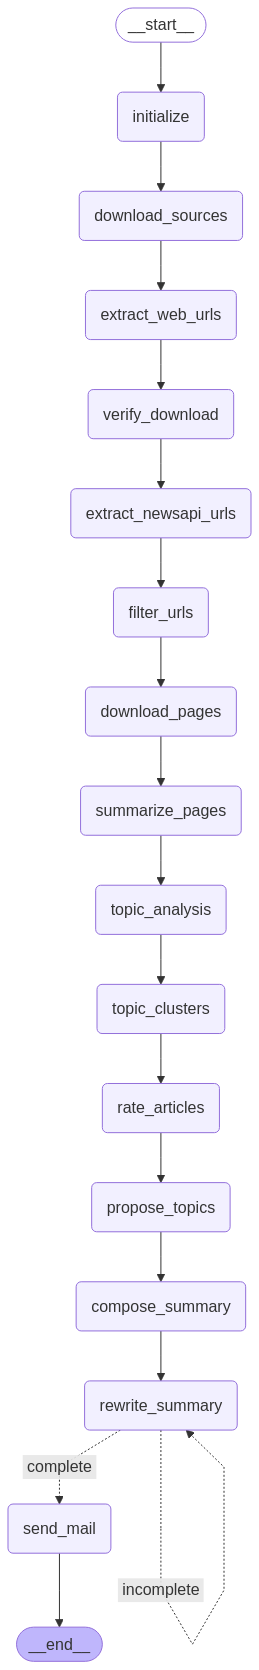

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-05-07 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-08 19:07:13,956 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-08 19:07:13,957 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-08 19:07:13,957 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-08 19:07:13,959 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-08 19:07:14,635 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-08 19:07:14,636 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-08 19:07:14,637 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-08 19:07:14,638 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-08 19:07:14,640 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-08 19:07:14,640 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-08 19:07:14,641 - AInewsbot - INFO - htmldata/FT.html
2025-05-08 19:07:14,642 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-08 19:07:14,642 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-08 19:07:14,643 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-08 19:07:14,643 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-08 19:07:15,367 - AInewsbot - INFO - Parsing html files
2025-05-08 19:07:15,367 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-08 19:07:15,419 - AInewsbot - INFO - parse_file - found 174 raw links
2025-05-08 19:07:15,422 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-05-08 19:07:15,422 - AInewsbot - INFO - 35 links found
2025-05-08 19:07:15,423 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-08 19:07:15,662 - AInewsbot - INFO - parse_file - found 254 raw links
2025-05-08 19:07:15,665 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-08 19:07:15,665 - AInewsbot - INFO - 34 links found
2025-05-08 19:07:15,665 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-08 19:07:15,684 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-08 19:07:15,688 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-08 19:07:15,688 - AInewsbot - INFO - 21 links found
2025-05-08

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,29
Business Insider,21
FT,64
Feedly AI,33
Hacker News 1,27
Hacker News 2,21
HackerNoon,12
New York Times,19


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-08 19:07:19,201 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-08 19:07:20,277 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-07T19:07:20 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-08 19:07:21,993 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-08 19:07:22,657 - AInewsbot - INFO - URLs in orig_df: 890
2025-05-08 19:07:22,661 - AInewsbot - INFO - Existing URLs in DB: 256069
2025-05-08 19:07:22,731 - AInewsbot - INFO - New URLs in df filtered by URL: 280
2025-05-08 19:07:22,875 - AInewsbot - INFO - Existing src+title: 29
2025-05-08 19:07:22,876 - AInewsbot - INFO - New URLs in df filtered by src+title: 251
2025-05-08 19:07:22,891 - AInewsbot - INFO - Found 251 unique new headlines
2025-05-08 19:07:22,893 - AInewsbot - INFO - Found 244 unique cleaned new headlines
2025-05-08 19:07:28,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,7

,id
src,
Ars Technica,4
Bloomberg,2
Business Insider,3
FT,1
Feedly AI,23
Hacker News 1,3
Hacker News 2,3
NewsAPI,40
Reddit,4


In [13]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-08 19:37:17,103 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-08 19:37:17,124 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-08 19:37:17,511 - AInewsbot - INFO - Launching browser
2025-05-08 19:37:19,725 - AInewsbot - INFO - Launching workers
2025-05-08 19:37:19,726 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:19,727 - AInewsbot - INFO - from queue: 0, https://www.404media.co/i-loved-that-ai-judge-moved-by-ai-generated-avatar-of-man-killed-in-road-rage-incident/ , 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
2025-05-08 19:37:19,728 - AInewsbot - INFO - fetch_url(https://www.404media.co/i-loved-that-ai-judge-moved-by-ai-generated-avatar-of-man-killed-in-road-rage-incident/)
2025-05-08 19:37:19,729 - AInewsbot - INFO - File already exists: htmlpages/I_Loved_That_AI___Judge_Moved_by_AI-Generated_Avatar_of_Man_Killed_in_Road_Rage_Incident.html
2025-05-08 19:37:19,729 - AInewsbot - INFO - from

2025-05-08 19:37:19,855 - AInewsbot - INFO - Skipping fetch for 15 https://www.bloomberg.com/news/articles/2025-05-08/apple-is-developing-specialized-chips-for-glasses-new-macs-and-ai-servers Apple Is Developing Specialized Chips for Glasses, New Macs and AI Servers
2025-05-08 19:37:19,855 - AInewsbot - INFO - from queue: 16, https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5 , Apple says AI is cutting into Google search. Google says that's not true. Who's right?
2025-05-08 19:37:19,856 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)
2025-05-08 19:37:19,856 - AInewsbot - INFO - File already exists: htmlpages/Apple_says_AI_is_cutting_into_Google_search._Google_says_that_s_not_true._Who_s_right.html
2025-05-08 19:37:19,857 - AInewsbot - INFO - from queue: 17, https://www.businessinsider.com/google-search-apple-paid-clicks-eddy-cue-2025-5 , Apple's comments on Search gave investors one rea

2025-05-08 19:37:19,921 - AInewsbot - INFO - File already exists: htmlpages/Google_hits_back_after_Apple_exec_says_AI_is_hurting_search.html
2025-05-08 19:37:19,922 - AInewsbot - INFO - from queue: 32, https://techcrunch.com/2025/05/08/google-rolls-out-ai-tools-to-protect-chrome-users-against-scams/ , Google rolls out AI-powered defenses to help combat scams on Chrome, including the use of Gemini Nano, its on-device LLM, in Enhanced Protection mode on desktop
2025-05-08 19:37:19,922 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/05/08/google-rolls-out-ai-tools-to-protect-chrome-users-against-scams/)
2025-05-08 19:37:19,990 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:19,991 - AInewsbot - INFO - from queue: 33, https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle , Google's Gemini 2.5 Pro Tops Coding Charts and MENSA Tests in AI IQ Battle
2025-05-08 19:37:19,991 - AInewsbot - INFO - fetch_url(https://decrypt.co/318416/googles

2025-05-08 19:37:20,118 - AInewsbot - INFO - from queue: 47, https://www.bloomberg.com/news/articles/2025-05-08/meta-taps-new-head-of-ai-lab-after-staffer-s-return-from-google , Meta Taps New Head of AI Lab After Staffers Return From Google
2025-05-08 19:37:20,120 - AInewsbot - INFO - Skipping fetch for 47 https://www.bloomberg.com/news/articles/2025-05-08/meta-taps-new-head-of-ai-lab-after-staffer-s-return-from-google Meta Taps New Head of AI Lab After Staffers Return From Google
2025-05-08 19:37:20,120 - AInewsbot - INFO - from queue: 48, https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy , Metas new AI glasses could have a super-sensing mode with facial recognition
2025-05-08 19:37:20,121 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy)
2025-05-08 19:37:20,185 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:20,187 - AInewsbot - INFO - f

2025-05-08 19:37:20,253 - AInewsbot - INFO - fetch_url(https://financialpost.com/pmn/power-utility-transalta-expects-alberta-data-centre-deal-this-year)
2025-05-08 19:37:20,253 - AInewsbot - INFO - File already exists: htmlpages/Power_utility_TransAlta_expects_Alberta_data_centre_deal_this_year.html
2025-05-08 19:37:20,253 - AInewsbot - INFO - from queue: 64, https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-reduce-revenue-sharing-with-microsoft/ , Report: OpenAI Aims to Reduce Revenue Sharing With Microsoft
2025-05-08 19:37:20,254 - AInewsbot - INFO - fetch_url(https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-reduce-revenue-sharing-with-microsoft/)
2025-05-08 19:37:20,305 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:20,306 - AInewsbot - INFO - from queue: 65, https://www.nbcnews.com/news/us-news/road-rage-victim-speaks-killers-sentencing-rcna205454 , Road rage victim 'speaks' via A.I. at his killer's sentencing
2025-05-08 19:37:20,306 -

2025-05-08 19:38:36,900 - AInewsbot - INFO - Saving HTML to htmlpages/Steelers__courtship_of_Aaron_Rodgers_is_more__complex__than_artificial_intelligence__part-owner_says.html
2025-05-08 19:38:38,948 - AInewsbot - INFO - from queue: 77, http://cacm.acm.org/opinion/thoughts-about-some-surprising-ai-era-technology-readiness-findings/ , Thoughts about Some Surprising AI-Era Technology Readiness Findings
2025-05-08 19:38:38,958 - AInewsbot - INFO - fetch_url(http://cacm.acm.org/opinion/thoughts-about-some-surprising-ai-era-technology-readiness-findings/)
2025-05-08 19:38:53,861 - AInewsbot - INFO - Saving HTML to htmlpages/SEC_filing__Sterling_Anderson__CPO_and_co-founder_of_self-driving_truck_startup_Aurora__is_resigning_effective_June_1__and_will_leave_the_board_on_August_31.html
2025-05-08 19:38:54,370 - AInewsbot - INFO - from queue: 78, https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/ , Trump admin to roll back Bidens AI chip restrictions
2025-0

2025-05-08 19:41:00,735 - AInewsbot - INFO - from queue: 92, https://blogs.nvidia.com/blog/wildfire-ai-startups/ , Wildfire Prevention: AI Startups Support Prescribed Burns, Early Alerts
2025-05-08 19:41:00,735 - AInewsbot - INFO - fetch_url(https://blogs.nvidia.com/blog/wildfire-ai-startups/)
2025-05-08 19:41:09,497 - AInewsbot - INFO - Saving HTML to htmlpages/Visa_wants_to_let_AI_make_credit_card_purchases_for_you.html
2025-05-08 19:41:10,480 - AInewsbot - INFO - from queue: 93, https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820 , Will AI decide if you get your next job? New research says it could
2025-05-08 19:41:10,480 - AInewsbot - INFO - fetch_url(https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)
2025-05-08 19:41:10,573 - AInewsbot - INFO - Saving HTML to htmlpages/U.S._AI_Leadership_Needs_Smarter_Controls.html
2025-05-08 19:41:11,143 - AInewsbot - INFO - fro

In [14]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-08 19:41:54,735 - AInewsbot - INFO - Starting summarize
2025-05-08 19:41:54,738 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-08 19:41:54,744 - AInewsbot - INFO - Attempting to fetch summaries for 98 articles
2025-05-08 19:41:54,760 - AInewsbot - INFO - clean_html - Page title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
Social card title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
Social card description: How the sister of Christopher Pelkey made an avatar of him to testify in court.

2025-05-08 19:41:54,938 - AInewsbot - INFO - Queuing 0: Page title: 'I Loved That AI:' Judge Moved by AI-G...
2025-05-08 19:41:54,949 - AInewsbot - INFO - clean_html - Page title: A Judge Accepted AI Video Testimony From a Dead Man
Social card title: A Judge Accepted AI Video Testimony From a Dead Man
Social card description: How the sister of Christopher Pelkey made an avatar of him to

2025-05-08 19:41:55,505 - AInewsbot - INFO - Queuing 16: Page title: Apple and Google Disagree on AI Cuttin...
2025-05-08 19:41:55,530 - AInewsbot - INFO - clean_html - Page title: Google's Search Dominance Questioned As Paid Clicks Slow - Business Insider
Social card title: Apple's comments on Search gave investors one reason to worry about Google's future. Here's another.
Social card description: Apple executive Eddy Cue's revelation on Safari search decline sparked investor worry. Google's paid clicks growth also has been slowing.

2025-05-08 19:41:55,555 - AInewsbot - INFO - Queuing 17: Page title: Google's Search Dominance Questioned A...
2025-05-08 19:41:55,585 - AInewsbot - INFO - clean_html - Page title: Arm Gives Tepid Forecast, Adding to Caution From Chipmakers
Social card title: Arm Gives Tepid Forecast, Adding to Caution From Chipmakers

2025-05-08 19:41:55,630 - AInewsbot - INFO - Queuing 18: Page title: Arm Gives Tepid Forecast, Adding to Ca...
2025-05-08 19:41:55,647 - A

2025-05-08 19:41:57,370 - AInewsbot - INFO - Queuing 35: Page title: Introducing Model Router: iterate quic...
2025-05-08 19:41:57,441 - AInewsbot - INFO - clean_html - Page title: I asked AI to brutally insult each European country : r/ChatGPT

2025-05-08 19:41:57,502 - AInewsbot - INFO - Queuing 36: Page title: I asked AI to brutally insult each Eur...
2025-05-08 19:41:57,538 - AInewsbot - INFO - clean_html - Page title: I asked ChatGPT who should be the next pope — here's what AI platforms said
Social card title: I asked ChatGPT who should be the next pope — here’s what AI platforms said
Social card description: Each chatbot approached the query differently — but all shared a surprisingly common trait.

2025-05-08 19:41:57,587 - AInewsbot - INFO - Queuing 37: Page title: I asked ChatGPT who should be the next...
2025-05-08 19:41:57,935 - AInewsbot - INFO - clean_html - Page title: I tried Microsoft's free AI skills training, and you can too - for another few weeks | ZDNET
Social car

2025-05-08 19:41:58,826 - AInewsbot - INFO - Queuing 54: Page title: Nobody Codes Here Anymore - Alex Ghicu...
2025-05-08 19:41:58,845 - AInewsbot - INFO - clean_html - Page title: Nutanix brings AI to enterprise infrastructure - SiliconANGLE
Social card title: Nutanix brings AI to enterprise infrastructure - SiliconANGLE
Social card description: Nutanix leaders discuss how AI is moving from lab to production by simplifying deployment, enabling governance, and powering enterprise infrastructure.

2025-05-08 19:41:58,868 - AInewsbot - INFO - Queuing 55: Page title: Nutanix brings AI to enterprise infras...
2025-05-08 19:41:58,877 - AInewsbot - INFO - clean_html - Page title: OpenAI offers to help countries build AI systems - Japan Today
Social card title: OpenAI offers to help countries build AI systems
Social card description: OpenAI on Wednesday announced an initiative to help countries build their own artificial intelligence (AI) infrastructures, with the U.S. government a partner in

2025-05-08 19:41:59,458 - AInewsbot - INFO - Queuing 71: Page title: Student Survey on AI in Game Developme...
2025-05-08 19:41:59,493 - AInewsbot - INFO - clean_html - Page title: Studio Blo appoints Shekhar Kapur as chairperson of board of AI ethics - The Economic Times
Social card title: Studio Blo appoints Shekhar Kapur as chairperson of board of AI ethics
Social card description: Shekhar Kapur has been appointed as the Chairperson of the Board of AI Ethics & Creative Stewardship at Studio Blo. He will guide the studio's work at the intersection of AI, storytelling, and ethical content creation. Kapur's experience will help Studio Blo use AI responsibly and explore new approaches to filmmaking, potentially creating a new genre of AI films.

2025-05-08 19:41:59,528 - AInewsbot - INFO - Queuing 72: Page title: Studio Blo appoints Shekhar Kapur as c...
2025-05-08 19:41:59,596 - AInewsbot - INFO - clean_html - Page title: Symbiosis International (Deemed University) launches Symbiosis A

2025-05-08 19:42:00,596 - AInewsbot - INFO - Queuing 87: Page title: iPhone Upgrades Weren't Sparked by AI....
2025-05-08 19:42:00,622 - AInewsbot - INFO - clean_html - Page title: Want Trustworthy AI? Put It on the Blockchain  | HackerNoon
Social card title: Want Trustworthy AI? Put It on the Blockchain  | HackerNoon
Social card description: Tired of AI’s black box? Discover how Aleph cloud uses blockchain to build a transparent, decentralized future for AI, data privacy, and digital freedom.

2025-05-08 19:42:00,667 - AInewsbot - INFO - Queuing 88: Page title: Want Trustworthy AI? Put It on the Blo...
2025-05-08 19:42:00,828 - AInewsbot - INFO - clean_html - Page title: Watch: OpenAI CEO Sam Altman, other executives give opening statements at Senate AI hearing - CBS News
Social card title: Watch: OpenAI CEO Sam Altman, other executives give opening statements at Senate AI hearing
Social card description: OpenAI CEO Sam Altman testified before a Senate committee on Thursday alongside 

async_langchain: 0, {'article': "Page title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\nSocial card title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\nSocial card description: How the sister of Christopher Pelkey made an avatar of him to testify in court.\nAn AI avatar made to look and sound like the likeness of a man who was killed in a road rage incident addressed the court and the man who killed him: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances,” the AI avatar of Christopher Pelkey said. “In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”\nIt was the first time the AI avatar of a victim—in this case, a dead man—has ever addressed a court, and it raises many questions about the use of this type of technology in future court proceedings.\nThe avatar was made

2025-05-08 19:42:02,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 51 response: no content
async_langchain: 81 response: no content
async_langchain: 63 response: no content
async_langchain: 23 response: no content
async_langchain: 68 response: no content


2025-05-08 19:42:02,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: no content


2025-05-08 19:42:03,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: • OpenAI CEO Sam Altman, Advanced Micro Devices CEO Dr. Lisa Su, CoreWeave CEO Michael Intrator, and Microsoft Vice Chair and President Brad Smith delivered opening statements before a Senate committee on Thursday during a hearing focused on the race for artificial intelligence.
async_langchain: 26 response: • CrowdStrike announced it will lay off 500 employees, approximately 5% of its workforce, citing advances in artificial intelligence as a driving factor.
• CEO George Kurtz stated, "AI has always been foundational to how we operate," emphasizing that AI is "reshaping every industry."


2025-05-08 19:42:03,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 6 response: • Artificial intelligence systems have achieved highly accurate reconstructions of images based on brain activity recordings, significantly improving when the AI focuses on specific brain regions.
• Researcher Umut Güçlü from Radboud University in the Netherlands stated, "As far as I know, these are the closest, most accurate reconstructions."
async_langchain: 80 response: • The Trump administration plans to rescind Biden-era export restrictions on AI chips, which it characterized as “overly complex,” according to a Commerce Department spokesperson.
• The spokesperson stated the restrictions will be replaced with a “much simpler rule that unleashes American innovation and ensures American AI dominance.”
async_langchain: 71 response: • A Bachelor student at Ecole Schulz in Geneva is conducting a project on Artificial Intelligence in the videogame industry and is seeking anonymous survey responses from developers who have worked on commercially available vide

2025-05-08 19:42:04,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 97 response: • Google launched a dedicated Gemini AI app for iPad on Wednesday, offering features optimized for the tablet, including Split View for multitasking.
• The app is available in all countries where Google Gemini is offered and can be downloaded from the App Store.
• Google has also rolled out Gemini home screen widgets for iPhone and iPad users, giving quick access to features like the camera, file sharing, Gemini Live conversations, and a direct text box for queries.
async_langchain: 72 response: • Studio Blo has appointed internationally recognized filmmaker Shekhar Kapur as Chairperson of its Board of AI Ethics & Creative Stewardship, where he will guide the studio's efforts at the intersection of AI, storytelling, and ethical content creation. 
• Kapur stated, “AI is not here to replicate the past—it’s here to create new forms of cinematic expression,” and expressed that AI films could become a genre of their own.
• Studio Blo is known for integrating tr

2025-05-08 19:42:04,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: • Google has released a dedicated Gemini app for iPad, offering a full-featured interface that takes advantage of the tablet’s larger screen and multitasking capabilities, addressing prior limitations of only using the iPhone app in compatibility mode.
• The new app supports features such as natural conversation via Gemini Live, image and video generation, photo and document analysis, Deep Research, Canvas mode for collaborative editing, and the Audio Overview tool to create AI-hosted podcasts in over 45 languages.
async_langchain: 79 response: • The Trump administration plans to rescind Biden-era restrictions on the export of advanced artificial intelligence chips, according to a spokesperson for the U.S. Department of Commerce.
• The export curbs in question relate to the Framework for Artificial Intelligence Diffusion, though no further details on implementation or timeline were provided.
async_langchain: 53 response: • Minister Jack Chambers has launch

2025-05-08 19:42:04,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,604 - httpx 

async_langchain: 78 response: • The Trump administration announced plans to rescind and replace a Biden-era rule that regulated the export of high-end AI accelerator chips, calling the previous framework "overly complex, overly bureaucratic, and would stymie American innovation."  
• The regulation, known as the Framework for Artificial Intelligence Diffusion, was issued in January during the final week of the Biden administration to restrict global access to advanced AI chips, especially targeting China's military capabilities.
• Following news of the policy change, Nvidia shares rose 3 percent, reflecting immediate market impacts.
async_langchain: 5 response: • OpenAI CEO Sam Altman told a Senate hearing that requiring government approval to release advanced AI software would be “disastrous” for the U.S.’s technological lead, signaling a shift away from earlier calls for strong government regulation.
• The testimony highlights a broader change in the tech industry’s approach to AI ri

2025-05-08 19:42:04,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,943 - httpx 

async_langchain: 8 response: • A new Duke University study published in the Proceedings of the National Academy of Sciences finds that employees who use AI tools like ChatGPT, Claude, and Gemini at work face negative stereotypes about competence and motivation from both colleagues and managers.
• Researchers conducted four experiments with over 4,400 participants and found a consistent pattern of bias against AI users, reporting expectations and actual judgments of them being lazier, less competent, less diligent, and more replaceable compared to users of conventional tools.
• The study reveals that the social stigma against using AI tools is widespread and not influenced by the user’s age, gender, or occupation, suggesting a general penalty for AI use regardless of demographic factors.
async_langchain: 19 response: • Arm Holdings provided a cautious sales forecast for the fiscal first quarter, projecting revenue of $1 billion to $1.1 billion and profit of 30 to 38 cents per share, bot

2025-05-08 19:42:05,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,204 - httpx 

async_langchain: 65 response: • Gabriel Paul Horcasitas was sentenced to the maximum 10½ years in prison for the 2021 fatal road-rage shooting of Christopher Pelkey, after a Maricopa County judge allowed an AI-generated recreation of Pelkey to deliver a victim impact statement at sentencing.
• The AI presentation, created at the request of Pelkey's family, featured a lifelike version of Pelkey's face, body, and voice, and reportedly included a statement of forgiveness directed toward Horcasitas.
• Horcasitas’ attorney called the AI statement "inflammatory" and cited it as grounds for appeal, raising questions among legal and ethics experts about the use of AI-generated victim testimony in court.
async_langchain: 45 response: • French AI chip startup VSORA has raised $46 million in funding, led by Otium and several European backers, to develop its Jotunn8 inference processor as an alternative to Nvidia and other global AI chip giants.  
• VSORA claims the Jotunn8 chip, targeting inferen

2025-05-08 19:42:05,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 96 response: • The 9th Workshop on Advances in Argumentation in Artificial Intelligence (AI³ 2025) is calling for paper submissions for its event scheduled on September 12 or 13, 2025, in Rende, Italy, co-located with the 41st International Conference on Logic Programming at the University of Calabria.
• Submissions are invited on topics including computational argumentation, explainable AI, persuasion systems, argument mining, and applications in multi-agent systems, with deadlines for paper registration on July 1 and submission on July 8, 2025; accepted papers will be published in the CEUR AI*IA Series (Scopus indexed).
• The workshop aims to foster discussion and collaboration across research areas related to argumentation in artificial intelligence, and offers multiple submission categories: full papers, short papers, and research overviews.
async_langchain: 93 response: • New research from Dr. Natalie Sheard at the University of Melbourne finds that AI hiring syst

2025-05-08 19:42:05,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 91 response: • The article explains that large language models (LLMs) display "emergent" behaviors—suddenly acquiring new capabilities—when their parameter count surpasses a critical threshold, drawing analogies to abrupt changes in nature, machine learning tasks, and logical circuits.
• It describes emergence as a consequence of allocating enough parameters in LLMs to accurately represent specific algorithms or tasks, resulting in a sudden jump in capability as seen in other complex systems.
• The article notes that predicting exactly when new capabilities will emerge in LLMs is challenging due to the complexity of training data, parameter budgets, and algorithmic discovery, but such emergent properties are not inherently surprising given the structure of LLMs.
async_langchain: 39 response: • LinkedIn has introduced new AI-powered features for job seekers, including an AI chatbot for mock interviews, enhanced natural language job search, and a job match scale that rat

2025-05-08 19:42:05,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 74 response: • AI Coffee, a new coffee shop on High Street featuring the Espressix ProtoSip prototype coffee machine, opened this Monday and quickly gained popularity due to social media attention and press coverage, resulting in high customer turnout and operational challenges.

• The shop's unique appeal centers on the use of a programmable coffee machine controlled by Python functions, which allowed for advanced customization of drinks; the machine's API and Alex's background as a programmer enabled rapid adaptation to customer requests.

• The Espressix ProtoSip, developed by a startup with ties to the shop's owner, lacks a traditional user interface and is operated via Python scripts, providing a practical framework to demonstrate advanced Python function features such as parameters, positional and keyword arguments, *args and **kwargs, default values, and both positional-only and keyword-only syntax.

• Despite the shop's name, Alex clarified that "AI Coffee" ref

2025-05-08 19:42:06,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • Increasing use of AI is automating entry-level jobs across industries, resulting in fewer opportunities for junior workers to gain foundational skills and mentorship, with surveys and reports showing significant job displacement and transformation (e.g., DBS Group job cuts, ResumeBuilder and Goldman Sachs reports).

• The loss of ground-level roles threatens the development of both technical competence and soft skills among new workers, creating a "competence gap" and potentially disadvantaging those from less privileged backgrounds, as highlighted by rising expectations for pre-existing experience and a 2024 National Youth Council survey noting 68% of Singaporean youths see internships as essential for entry-level positions.

• The commentary proposes a national apprenticeship scheme—modeled on successful examples from Germany and Singapore's own SkillsFuture—to provide structured, mentored, AI-augmented training for new entrants, emphasizing the need f

2025-05-08 19:42:06,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 54 response: • Alex Ghiculescu reports on rolling out AI coding assistants Cursor and Claude Code to a team of 40 developers working on a mature Ruby on Rails SaaS product, finding that 20% productivity gains are possible when these tools are well integrated into workflows.

• Developers vary in adoption, with some using agents for most tasks and others alternating based on task type; agents are praised for enabling rapid development, tackling ambitious projects, understanding unfamiliar codebases, and quickly refactoring or completing routine tasks, but challenges remain around coding style, correct bug fixes, and overuse of comments.

• No company-wide mandate was issued to use AI agents, but many team members organically adopted them due to evident productivity benefits and the evolving quality of AI tools, prompting changes to make the codebase more "AI friendly" and facilitating easier agent use in daily development.
async_langchain: 57 response: • Instacart CEO F

2025-05-08 19:42:07,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 82 response: • The U.S. is reassessing its AI export controls after China’s DeepSeek-R1 model highlighted the urgency to restrict China’s access to advanced AI technologies, with calls to enhance R&D, foster domestic innovation, and strengthen international collaborations rooted in democratic values.
• The Biden administration’s 2024 Framework for Artificial Intelligence Diffusion Interim Final Rule (IFR) restricts AI chip exports to China and other countries, but has faced criticism from U.S. allies and industry leaders for potentially fracturing alliances and incentivizing the adoption of Chinese AI technology.
• Lawmakers and experts, including former Google CEO Eric Schmidt, warn that China’s technological gap is narrowing and urge policies that balance security with market competitiveness, enforceable norms, and open governance, rather than blanket restrictions that may harm U.S. leadership and partnerships.
• China has retaliated against U.S. controls by increasi

2025-05-08 19:42:07,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 94 response: • New research using computational protein design tools, like RFDiffusion from the Baker Lab, has enabled the creation of synthetic proteins that can bind to specific snake venom components, showing protective effects in mice and offering a new approach to antivenom development.

• Snake venom’s extreme heterogeneity—varying between families, species, geographic regions, populations, and even an individual snake's age—makes traditional antivenom production expensive, technically challenging, and economically unattractive, especially for markets in lower-income regions.

• Recent breakthroughs, including the identification and engineering of broadly neutralizing antibodies (some derived from a 'hyperimmune' individual and phage display methods), raise the prospect of near-universal antivenoms that could work against a wide variety of snake venoms, but broader problems remain: “A perfect computationally-designed antivenom doesn’t guarantee market incentives.

2025-05-08 19:42:09,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:09,629 - AInewsbot - INFO - Received 95 summaries
2025-05-08 19:42:09,629 - AInewsbot - INFO - Summary for 0 (length 1149): • An AI-generated avatar of Christopher Pelkey, who was killed in a road rage incident, addressed the court and the shooter, Gabriel Horcasitas, during court proceedings, marking the first time an AI avatar of a deceased victim has spoken in court.
• The avatar, created by Pelkey’s sister Stacey Wales, expressed sentiments of forgiveness: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances... In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”
• The unprecedented use of an AI victim avatar in court raises questions about the future use of this technology in legal proceedings.
2025-05-08 19:42:09,630 - A

2025-05-08 19:42:09,635 - AInewsbot - INFO - Summary for 11 (length 5559): • Alibaba researchers have introduced "ZeroSearch," a reinforcement learning framework that enables large language models (LLMs) to simulate advanced search capabilities without relying on external search engine APIs, reducing training costs by up to 88%.

• In tests across seven question-answering datasets, models trained using ZeroSearch matched or outperformed those trained with real search engines, with a 14B-parameter simulation LLM surpassing Google Search performance while costing only $70.80 compared to $586.70 for API-based training.

• The technique gives developers greater control over training data and eliminates unpredictable document quality from search engines, and Alibaba has released associated code, datasets, and models on GitHub and Hugging Face for broader industry use.
2025-05-08 19:42:09,635 - AInewsbot - INFO - Summary for 12 (length 9459): • Anthropic has launched a web search API for its

2025-05-08 19:42:09,638 - AInewsbot - INFO - Summary for 22 (length 1675): • Users report that ChatGPT displays unrelated or incorrect information—such as random receipts—when analyzing uploaded images, including sleep activity pictures, raising concerns about AI hallucinations and image processing errors.
• Community members suggest these issues may be due to AI image processing failures, potential hash conflicts, or hallucinations, and recommend reporting such incidents for further investigation.
• Multiple similar reports have surfaced in the past two weeks, highlighting a possible uptick in the frequency of these errors.
2025-05-08 19:42:09,639 - AInewsbot - INFO - Summary for 23 (length 28): no content
2025-05-08 19:42:09,639 - AInewsbot - INFO - Summary for 24 (length 7880): • Increasing use of AI is automating entry-level jobs across industries, resulting in fewer opportunities for junior workers to gain foundational skills and mentorship, with surveys and reports showing signif

2025-05-08 19:42:09,645 - AInewsbot - INFO - Summary for 35 (length 8143): • Hypermode has launched Model Router, a new feature providing developers with a unified API to access both open-source and commercial AI language and embedding models, enabling seamless switching and orchestration between models.

• Model Router offers functionalities such as cost and performance optimization, automatic fallback, load balancing, customizable model preferences, and support for security and compliance requirements, reducing complexity and maintenance in AI model integration.

• The tool is compatible with popular SDKs including the OpenAI SDK and Vercel AI SDK, and aims to help developers and enterprises iterate quickly, optimize costs, and avoid lock-in to single model providers.
2025-05-08 19:42:09,646 - AInewsbot - INFO - Summary for 36 (length 2712): • A Reddit user shared their experience asking AI (presumably ChatGPT) to "brutally insult" various European countries, resulting in humorous, s

2025-05-08 19:42:09,647 - AInewsbot - INFO - Summary for 46 (length 10345): • Meta CEO Mark Zuckerberg suggested in a podcast interview that AI "friends," including AI girlfriends and therapists, could help address the loneliness crisis by fulfilling people's need for more meaningful companionships, noting that Americans on average have fewer friends than desired.

• Experts and commentators responded with skepticism and concern, citing Meta's history with issues around mental health and privacy, as well as risks such as AI chatbots engaging in inappropriate conversations or collecting sensitive user data without adequate safeguards.

• Some research supports that AI companions can significantly reduce feelings of loneliness in the short term, but experts caution about long-term impacts and emphasize that AI friendships lack the depth, unpredictability, and personal growth offered by real human interactions, raising ethical and societal questions about reliance on technology to solve e

2025-05-08 19:42:09,649 - AInewsbot - INFO - Summary for 58 (length 1897): • OpenAI has hired Fidji Simo, current CEO of Instacart and former head of the Facebook app, as head of its apps business; she will remain CEO of Instacart for the next couple of months until a successor is named.

• OpenAI CEO Sam Altman stated that Simo’s new role will allow him to “focus on research, compute, and safety.”

• Simo, who joined Facebook in 2011 and became head of the Facebook app in 2019, has been an OpenAI board member since last year and led Instacart through its public offering.
2025-05-08 19:42:09,649 - AInewsbot - INFO - Summary for 59 (length 8405): • OpenAI has appointed Fidji Simo, currently CEO and Chair of Instacart, as its new CEO of Applications, a newly established executive role; Simo will join OpenAI in 2025 after a transition period and will lead the division responsible for turning AI research into consumer and business products.

• CEO Sam Altman stated he will remain CEO of Op

2025-05-08 19:42:09,652 - AInewsbot - INFO - Summary for 71 (length 1346): • A Bachelor student at Ecole Schulz in Geneva is conducting a project on Artificial Intelligence in the videogame industry and is seeking anonymous survey responses from developers who have worked on commercially available videogames; interested participants are asked to contact lghettiedu@gmail.com to receive the survey link.
2025-05-08 19:42:09,652 - AInewsbot - INFO - Summary for 72 (length 1955): • Studio Blo has appointed internationally recognized filmmaker Shekhar Kapur as Chairperson of its Board of AI Ethics & Creative Stewardship, where he will guide the studio's efforts at the intersection of AI, storytelling, and ethical content creation. 
• Kapur stated, “AI is not here to replicate the past—it’s here to create new forms of cinematic expression,” and expressed that AI films could become a genre of their own.
• Studio Blo is known for integrating traditional filmmaking with AI-driven tools, working 

2025-05-08 19:42:09,654 - AInewsbot - INFO - Summary for 83 (length 3605): • A report from the Institute for Public Policy Research (IPPR) found that only 15% of UK AI companies focus on solving specific societal problems, with the majority providing generic solutions rather than addressing key issues like public health or sustainable transport.
• Despite one in five AI companies benefiting from public funds, most are not directly contributing to the public good; the report advises the government to use procurement and grant-making powers to steer the industry toward more purposeful innovation.
• Recommendations include establishing a government AI Tracking Unit, targeting funding to problem-solving AI firms, and using government procurement to support breakthrough innovations that address societal needs.
2025-05-08 19:42:09,654 - AInewsbot - INFO - Summary for 84 (length 2487): • Researchers have identified the origin of excitation-independent visible photoluminescence in crystalline 

2025-05-08 19:42:09,657 - AInewsbot - INFO - Summary for 94 (length 32773): • New research using computational protein design tools, like RFDiffusion from the Baker Lab, has enabled the creation of synthetic proteins that can bind to specific snake venom components, showing protective effects in mice and offering a new approach to antivenom development.

• Snake venom’s extreme heterogeneity—varying between families, species, geographic regions, populations, and even an individual snake's age—makes traditional antivenom production expensive, technically challenging, and economically unattractive, especially for markets in lower-income regions.

• Recent breakthroughs, including the identification and engineering of broadly neutralizing antibodies (some derived from a 'hyperimmune' individual and phage display methods), raise the prospect of near-universal antivenoms that could work against a wide variety of snake venoms, but broader problems remain: “A perfect computationally-designed 

async_langchain: 21 response: • SPLADE (Sparse Lexical and Expansion Model for First Stage Ranking) is introduced as a method to combine the transparency and simplicity of keyword search with the meaning-matching abilities of semantic search, addressing limitations in both traditional keyword and modern vector-based search systems.

• In a practical experiment on a database of superhero descriptions, using SPLADE to inject synthetic tokens into search indexes improved recall@3 from 28% to 52%, demonstrating a significant boost in the ability to retrieve relevant results based on non-exact matches.

• The blog notes that while SPLADE improves recall, implementing it in Elasticsearch as described does not consider token weights for precision, and highlights ongoing challenges such as occasional irrelevant synthetic tokens and the complexity of tuning semantic search models.


In [15]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-08 19:42:09,711 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:42:18,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:21,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:21,382 - AInewsbot - INFO - 98 free-form topics extracted
2025-05-08 19:42:21,384 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:42:21,385 - AInewsbot - IN

2025-05-08 19:42:21,448 - AInewsbot - INFO - Canonical topic taiwan
2025-05-08 19:42:21,448 - AInewsbot - INFO - Canonical topic russia
2025-05-08 19:42:21,450 - AInewsbot - INFO - Canonical topic authors & writing
2025-05-08 19:42:21,451 - AInewsbot - INFO - Canonical topic infrastructure
2025-05-08 19:42:21,452 - AInewsbot - INFO - Canonical topic legal issues
2025-05-08 19:42:21,452 - AInewsbot - INFO - Canonical topic smart grid
2025-05-08 19:42:21,453 - AInewsbot - INFO - Canonical topic nuclear
2025-05-08 19:42:21,453 - AInewsbot - INFO - Canonical topic governance
2025-05-08 19:42:21,454 - AInewsbot - INFO - Canonical topic hardware
2025-05-08 19:42:21,454 - AInewsbot - INFO - Canonical topic stocks
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic food & drink
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic quantum computing
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic scams
2025-05-08 19:42:21,456 - AInewsbot - INFO - Canonical topic ai 

2025-05-08 19:42:28,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,156 - httpx 

2025-05-08 19:42:28,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,465 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,476 - httpx 

2025-05-08 19:42:28,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,864 - httpx 

2025-05-08 19:42:29,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,112 - httpx 

2025-05-08 19:42:29,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,291 - httpx 

2025-05-08 19:42:29,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,560 - httpx 

2025-05-08 19:42:29,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,827 - httpx 

2025-05-08 19:42:30,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,220 - httpx 

2025-05-08 19:42:30,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,768 - httpx 

2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 27: ### <<<ARTICLE SUMMARY>>>
# Exhibit your startup a...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 28: ### <<<ARTICLE SUMMARY>>>
# Fidji Simo joins OpenA...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 29: ### <<<ARTICLE SUMMARY>>>
# Google Gemini gets an ...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 30: ### <<<ARTICLE SUMMARY>>>
# Google Launches New AI...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 31: ### <<<ARTICLE SUMMARY>>>
# Google hits back after...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 32: ### <<<ARTICLE SUMMARY>>>
# Google rolls out AI-po...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 33: ### <<<ARTICLE SUMMARY>>>
# Google's Gemini 2.5 Pr...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# How we're using AI to ...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Hypermode Model Router...
2

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\n\n• An AI-generated avatar of Christopher Pelkey, who was killed in a road rage incident, addressed the court and the shooter, Gabriel Horcasitas, during court proceedings, marking the first time an AI avatar of a deceased victim has spoken in court.\n• The avatar, created by Pelkey’s sister Stacey Wales, expressed sentiments of forgiveness: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances... In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”\n• The unprecedented use of an AI victim avatar in court raises questions about the future use of this technology in legal proceedings.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI In Legal Proceedings, AI Integration, AI Regulation, AI Technology, AI Tools, AI-G

2025-05-08 19:42:38,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,850 - httpx 

async_langchain: 23 response: items=[]
async_langchain: 15 response: items=[]
async_langchain: 0 response: items=['AI In Legal Proceedings', 'AI-Generated Avatars', 'Forgiveness', 'Legal Ethics', 'Victim Impact Statements']
async_langchain: 47 response: items=[]
async_langchain: 44 response: items=[]
async_langchain: 81 response: items=[]
async_langchain: 51 response: items=[]
async_langchain: 63 response: items=[]
async_langchain: 61 response: items=[]
async_langchain: 68 response: items=[]
async_langchain: 14 response: items=['Finance', 'Fintech', 'Economics', 'Customer Service']


2025-05-08 19:42:38,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,031 - httpx 

async_langchain: 38 response: items=['Certification Opportunities', 'Free Training', 'Microsoft AI Skills Fest', 'Skill Development', 'Online Education']
async_langchain: 19 response: items=['Arm Forecast', 'Chipmaker Caution', 'Financial Outlook', 'Licensing Deals', 'Semiconductor Chips', 'AI Business']
async_langchain: 18 response: items=['Arm Holdings', 'Chip Market Forecast', 'Financial Performance', 'Licensing Agreements', 'AI Investments']
async_langchain: 26 response: items=['AI Impact On Employment', 'CrowdStrike', 'Industry Transformation', 'Job Cuts']
async_langchain: 13 response: items=['Apple Smart Glasses', 'Chip Development', 'Energy Efficiency', 'Integrated AI Features', 'Meta Competition', 'Augmented Reality']
async_langchain: 87 response: items=['Consumer Behavior', 'Iphone Upgrades', 'Market Response', 'Trump Tariffs']
async_langchain: 10 response: items=['AI In Courtroom Settings', 'Legal Ethics', 'Ethical Concerns', 'Victim Statements', 'AI Tools']
async_langchain: 

2025-05-08 19:42:39,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,298 - httpx 

async_langchain: 40 response: items=['AI Integration', 'Enforcement Workforce Changes', 'Operational Efficiency', 'Tax Collection', 'Job Automation']
async_langchain: 4 response: items=['AI And Human Discernment', 'AI Reliance', 'Cognitive Outsourcing', 'Critical Thinking', 'Ethical Concerns']
async_langchain: 72 response: items=['AI Ethics', 'AI In Film', 'Creative Storytelling', 'Entertainment', 'Shekhar Kapur', 'Studio Blo']
async_langchain: 50 response: items=['AI Model Compression', 'CB Insights Recognition', 'Energy Efficiency', 'Funding', 'Quantum-Inspired Technology', 'Multiverse Computing']
async_langchain: 52 response: items=['AI Technology', 'Animal Communication', 'Baidu AI Technology', 'Human-Animal Interaction', 'Patent Application', 'Machine Learning']
async_langchain: 69 response: items=['AI and Religious Liberty', 'AI Surveillance', 'Ethical AI', 'Religious Communities', 'Faith@Work ERG Conference', 'AI Integration']
async_langchain: 86 response: items=['AI In Personal

2025-05-08 19:42:39,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 90 response: items=['AI Scams', 'Blockchain Verification', 'Cybersecurity', 'Digital Security', 'Fraud Detection', 'Public Education']
async_langchain: 82 response: items=['AI Chip Regulations', 'AI Competition', 'AI Policy', 'Biden Administration', 'China', 'U.S. AI Export Controls', 'Democratic Values']
async_langchain: 56 response: items=['AI Infrastructure Support', 'OpenAI for Countries Initiative', 'Localization of ChatGPT', 'Investment in AI', 'Healthcare', 'Education', 'Governance']
async_langchain: 91 response: items=['Emergent Properties', 'Language Models', 'Parameter Count', 'Machine Learning', 'Training Data Complexity']
async_langchain: 46 response: items=['AI Companionship', 'Ethical Concerns', 'Loneliness Crisis', 'Privacy & Surveillance', "Zuckerberg's Proposal"]
async_langchain: 33 response: items=['AI Performance', 'Google Gemini 2.5 Pro', 'Coding Benchmarks', 'Intelligence Testing', 'AI Competition']
async_langchain: 55 response: items=['AI Integrat

2025-05-08 19:42:39,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: items=['AI Impact on Search', 'Apple Google Antitrust Trial', 'Search Dominance', 'Technology Competition', 'Stocks']
async_langchain: 85 response: items=['AI Support for Trauma Survivors', 'Content Filter Issues', 'App Disruptions', 'Google Gemini', 'Ethical Concerns', 'Model Performance']
async_langchain: 42 response: items=['Disney Family Reactions', 'Ethical Concerns', 'Imagineers', 'Theme Park Innovation', 'Walt Disney Animatronic']
async_langchain: 71 response: items=['AI in Video Games', 'Game Development', 'Developer Survey', 'Student Project', 'Ecole Schulz']


2025-05-08 19:42:40,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,072 - AInewsbot - INFO - Received 98 responses
2025-05-08 19:42:40,076 - AInewsbot - INFO - End topic analysis


async_langchain: 65 response: items=['AI-Generated Victim Testimony', 'Legal Ethics', 'Ethical Concerns', 'Road Rage Sentencing', 'Victim Impact Statement']
async_langchain: 73 response: items=['AI Institute', 'AI Integration', 'Education And Research', 'Interdisciplinary Programs', 'Responsible Innovation', 'Fintech', 'Health & Fitness']
async_langchain: 75 response: items=['Legal Challenges', 'Online Safety Act', 'Volunteer Editor Safety', 'Data Privacy', 'Wikimedia Foundation', 'Policy And Regulation', 'Uk']


In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [17]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-08 19:42:50,431 - AInewsbot - INFO - Calculating article rating for 98 articles
2025-05-08 19:42:50,433 - AInewsbot - INFO - Starting low_quality filter
2025-05-08 19:42:57,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:58,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:58,288 - AInewsbot - INFO - low quality articles: {0: 88, 1: 10}
2025-05-08 19:42:58,289 - AInewsbot - INFO - Starting on_topic filter
2025-05-08 19:43:02,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:03,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:03,180 - AInewsbot - INFO - on topic articles: {1: 80, 0: 18}
2025-05-08 19:43:03,181 - AInewsbot - INFO - Starting importance filter
2025-05-08 19:43:10,647 - httpx - INFO - HTTP Reques

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.nbcnews.com/news/us-news/road-rage...,NewsAPI,Road rage victim 'speaks' via A.I. at his kill...,True,https://www.nbcnews.com/news/us-news/road-rage...,www.nbcnews.com,NBC News,1,htmlpages/Road_rage_victim__speaks__via_A.I._a...,...,Road rage victim 'speaks' via A.I. at his kill...,[Road rage victim 'speaks' via A.I. at his kil...,0,0,AI Testimony in Road Rage Trial,0,1,1,1.668945,4.668945
1,1,https://www.404media.co/i-loved-that-ai-judge-...,Feedly AI,'I Loved That AI:' Judge Moved by AI-Generated...,True,https://www.404media.co/i-loved-that-ai-judge-...,www.404media.co,404 Media,1,htmlpages/I_Loved_That_AI___Judge_Moved_by_AI-...,...,'I Loved That AI:' Judge Moved by AI-Generated...,['I Loved That AI:' Judge Moved by AI-Generate...,23,0,AI Testimony in Road Rage Trial,0,1,1,1.060320,4.060320
2,2,https://www.404media.co/email/0cb70eb4-c805-4e...,Reddit,A Judge Accepted AI Video Testimony From a Dea...,True,https://www.404media.co/email/0cb70eb4-c805-4e...,www.404media.co,404 Media,1,htmlpages/A_Judge_Accepted_AI_Video_Testimony_...,...,A Judge Accepted AI Video Testimony From a Dea...,[A Judge Accepted AI Video Testimony From a De...,68,0,AI Testimony in Road Rage Trial,0,1,1,1.890086,4.890086
3,3,https://slashdot.org/submission/17335817/ai-of...,NewsAPI,AI of Dead Arizona Road Rage Victim Addresses ...,True,https://slashdot.org/submission/17335817/ai-of...,slashdot.org,slashdot.org,0,htmlpages/AI_of_Dead_Arizona_Road_Rage_Victim_...,...,AI of Dead Arizona Road Rage Victim Addresses ...,[AI of Dead Arizona Road Rage Victim Addresses...,95,0,AI Testimony in Road Rage Trial,0,1,1,1.611405,3.611405
4,4,https://www.inc.com/kit-eaton/ai-is-reshaping-...,Feedly AI,"AI Is Reshaping the Workplace, but Entry-Level...",True,https://www.inc.com/kit-eaton/ai-is-reshaping-...,www.inc.com,Inc.,1,htmlpages/AI_Is_Reshaping_the_Workplace__but_E...,...,"AI Is Reshaping the Workplace, but Entry-Level...","[AI Is Reshaping the Workplace, but Entry-Leve...",3,1,AI's Impact on Entry-Level Jobs,0,1,1,1.719248,4.719248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,93,http://arcturus-labs.com/blog/2024/10/09/bridg...,Hacker News 2,Bridging the gap between keyword and semantic ...,True,http://arcturus-labs.com/blog/2024/10/09/bridg...,arcturus-labs.com,arcturus-labs.com,0,htmlpages/Bridging_the_gap_between_keyword_and...,...,Bridging the gap between keyword and semantic ...,[Bridging the gap between keyword and semantic...,90,999,,0,1,0,2.000000,3.000000
87,94,https://www.digitaljournal.com/business/uk-fir...,NewsAPI,UK firms finds industry lacks AI purpose,True,https://www.digitaljournal.com/business/uk-fir...,www.digitaljournal.com,www.digitaljournal.com,0,htmlpages/UK_firms_finds_industry_lacks_AI_pur...,...,UK firms finds industry lacks AI purpose (Topi...,[UK firms finds industry lacks AI purpose - ww...,91,999,,0,1,1,1.556905,3.556905
88,95,https://www.ibtimes.com/openai-offers-help-cou...,NewsAPI,OpenAI Offers To Help Countries Build AI Systems,True,https://www.ibtimes.com/openai-offers-help-cou...,www.ibtimes.com,www.ibtimes.com,0,htmlpages/OpenAI_Offers_To_Help_Countries_Buil...,...,OpenAI Offers To Help Countries Build AI Syste...,[OpenAI Offers To Help Countries Build AI Syst...,92,999,,0,1,1,1.365675,3.365675
89,96,https://petapixel.com/2025/05/07/acdsee-gemsto...,NewsAPI,ACDSee Gemstone Photo Editor 15 Is an AI-Power...,True,https://petapixel.com/2025/05/07/acdsee-gemsto...,petapixel.com,PetaPixel,1,htmlpages/ACDSee_Gemstone_Photo_Editor_15_Is_a...,...,ACDSee Gemstone Photo Editor 15 Is an AI-Power...,[ACDSee Gemstone Photo Editor 15 Is an AI-Powe...,93,999,,0,1,0,1.452400,3.452400


In [18]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-08 19:43:12,702 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:43:12,707 - AInewsbot - INFO - Initial cluster topics: 
AI Testimony in Road Rage Trial
AI's Impact on Entry-Level Jobs
AI Driving Job Automation and Cuts
Leadership Changes in Tech and AI
Google's Gemini AI Updates and Challenges
2025-05-08 19:43:58,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:58,591 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Testimony in Road Rage Trial
AI's Impact on Entry-Level Jobs
AI Driving Job Automation and Cuts
Leadership Changes in Tech and AI
Google's Gemini AI Updates and Challenges
AI Victim Impact Testimony
Trump AI Chip Rollback
Apple-Google Search Dispute
Sam Altman on Regulation
IRS AI Workforce Plan
Google AI Scam Defenses
Fidji Simo Apps CEO
Google Gemini 2.5 Benchmark
An

In [19]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-08 19:44:43,995 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:46:27,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:46:27,197 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Law & Policy

- OpenAI CEO Sam Altman warned a Senate committee that requiring government approval for advanced AI releases would harm U.S. technological leadership. - [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- The Trump administration plans to rescind Biden-era export controls on high-end AI accelerator chips, aiming for simpler rules to promote American innovation. - [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- An AI-generated video avatar of road rage victim Christopher Pelkey delivered a victim impact statement expressing forgiveness at his killer’s sentencing in Arizona. - [NPR](https://www.npr.org/2025/05/07/g-s1-64640/ai-impact-statement-murder-victim)

## Automation & Hiring

- Treasury Secretary Scott Bessent said the IRS will use AI to supplement its workforce and enhance tax collections after significant staff cuts. - [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- Experts say AI is reshaping workplace tasks and skills rather than replacing workers outright, leading entry-level hires to gain an advantage with AI proficiency. - [Inc.](https://www.inc.com/kit-eaton/ai-is-reshaping-the-workplace-but-entry-level-hires-are-way-ahead-of-the-game/91186660)
- Research shows AI hiring tools used by 62% of Australian employers can amplify discrimination against marginalized groups without human oversight. - [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## Leadership Shakeups

- Aurora co-founder and chief product officer Sterling Anderson will resign June 1 and depart the board August 31 after helping launch its self-driving truck service. - [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Instacart CEO Fidji Simo will become OpenAI’s first CEO of Applications later this year to lead its business and operational teams. - [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Search & Discovery

- Anthropic launched a Claude web search API that delivers real-time, source-cited answers to developers, challenging traditional search engines. - [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple SVP Eddie Cue testified that AI engines are reducing Safari search volume, a claim Google disputes as overall queries continue rising. - [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## Enterprise & Dev Tools

- Nutanix unveiled a strategy to operationalize AI on its infrastructure, emphasizing simplified deployment, centralized governance, and detailed access controls. - [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)
- OpenAI announced a GitHub connector for ChatGPT’s deep research tool and new fine-tuning options for its reasoning models in beta. - [TechCrunch](https://techcrunch.com/2025/05/08/exhibit-your-startup-at-techcrunch-sessions-ai-while-you-still-can/)

## AI Hardware & Performance

- Google’s Gemini 2.5 Pro topped coding benchmarks and Mensa-style cognitive tests, showcasing enhanced reasoning and problem-solving abilities. - [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- French startup VSORA raised \\$46 million to develop its Jotunn8 inference chip, promising triple performance and half the power use of rivals. - [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)

## Consumer AI & Apps

- LinkedIn introduced AI tools like a mock‐interview chatbot, conversational job search, and a job match scale for Premium subscribers. - [Tom's Guide](https://www.tomsguide.com/ai/i-tried-to-find-my-dream-job-with-linkedins-new-ai-features-heres-what-happened)
- Peloton said AI powers its customer support, subtitles, and personalized fitness plans while reporting minimal tariff impact on earnings. - [The Verge](https://www.theverge.com/news/663229/peloton-tariffs-q3-2025-earnings)
- Google launched a dedicated Gemini iPad app with multitasking, Deep Research, Canvas, and audio-overview features optimized for tablets. - [ZDNet](https://www.zdnet.com/article/google-gemini-gets-an-ipad-app-at-last-heres-why-thats-a-big-deal/)

## Science & Environment

- Researchers used AI focused on specific brain regions to reconstruct viewed images from neural activity with remarkable accuracy. - [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- AI startups like Pano AI deploy camera networks and models for early wildfire detection and safer prescribed burns. - [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Computational protein design tools enabled synthetic antivenom candidates that protect mice, potentially easing snake antivenom shortages. - [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

## Other News

- A Duke University study finds employees using AI tools at work face bias, being judged lazier, less competent, and more replaceable. - [Ars Technica](https://arstechnica.com/ai/2025/05/ai-use-damages-professional-reputation-study-suggests/)
- Satya Nadella endorsed open A2A and MCP protocols to enable interoperable AI agents across platforms in Microsoft’s Copilot tools. - [VentureBeat](https://venturebeat.com/ai/the-walled-garden-cracks-nadella-bets-microsofts-copilots-and-azures-next-act-on-a2a-mcp-interoperability/)
- Alibaba’s ZeroSearch uses reinforcement learning to simulate search capabilities in LLMs, cutting training costs by 88%. - [VentureBeat](https://venturebeat.com/ai/alibabas-zerosearch-lets-ai-learn-to-google-itself-slashing-training-costs-by-88-percent/)
- Meta revealed AI-powered smart glasses codenamed Aperol and Bellini with super-sensing facial recognition and always-on sensors. - [The Verge](https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy)
- Experts call to balance AI export controls with domestic R&D to maintain U.S. leadership without hampering global alliances. - [Foreign Policy](http://foreignpolicy.com/2025/05/07/us-china-ai-leadership-needs-controls-deepseek/)
- Mark Zuckerberg suggested AI ‘friends’ could address loneliness but experts warn of privacy, mental health, and ethical risks. - [HuffPost](https://www.huffpost.com/entry/mark-zuckerberg-on-ai-friendships_n_681a4bf3e4b0c2b15d96851d)
- Apple is developing custom low-energy chips for smart glasses to support cameras, AI features, and spatial video recording by 2026. - [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)
- Consulting firms like IBM are using AI assistants to boost productivity by 50% while clients increasingly demand AI-enabled services. - [Bangkok Post](https://www.bangkokpost.com/business/general/3020500/consulting-in-the-ai-era)
- Ireland’s government launched guidelines for responsible AI in public services, including frameworks, lifecycle tools, and free training. - [The Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center is advising state legislators on AI regulation to avoid a patchwork of conflicting laws. - [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)
- OpenAI offered to help countries build AI infrastructures and localized ChatGPT versions for sectors like healthcare and education. - [IBTimes](https://japantoday.com/category/tech/openai-offers-help-countries-build-ai-systems)
- Experts recommend public education, source verification, and blockchain to combat increasingly sophisticated AI-enhanced scams. - [DigitalJournal](https://www.digitaljournal.com/tech-science/ways-to-safeguard-against-a-new-wave-of-ai-enhanced-scams/article)
- ACDSee Gemstone Photo Editor 15 launched AI-powered tools like super-resolution, object masking, sky replacement, and face editing. - [PetaPixel](https://petapixel.com/2025/05/07/acdsee-gemstone-photo-editor-15-is-an-ai-powered-photoshop-alternative/)

2025-05-08 19:46:27,202 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:48:03,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Showdown: Policy, Chips, and Science

## Regulation Rumble
- OpenAI CEO Sam Altman warned a Senate committee that requiring government approval for advanced AI releases would harm U.S. technological leadership. [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- The Trump administration plans to rescind Biden-era export controls on high-end AI accelerator chips. [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Experts urge balancing AI export controls with domestic R&D to maintain U.S. leadership without straining alliances. [Foreign Policy](http://foreignpolicy.com/2025/05/07/us-china-ai-leadership-needs-controls-deepseek/)
- Ireland’s government launched guidelines for responsible AI in public services, including frameworks and free training. [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center is advising state legislators on AI regulation to avoid conflicting laws. [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Hiring Hijinks
- The IRS will use AI to supplement its workforce and enhance tax collections after staff cuts. [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- AI hiring tools used by 62% of Australian employers can amplify discrimination without human oversight. [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## Exec Moves
- Aurora co-founder Sterling Anderson will resign June 1 and leave the board August 31. [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Instacart CEO Fidji Simo will become OpenAI’s first CEO of Applications later this year. [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Search Showdown
- Anthropic launched a Claude web search API that provides real-time, source-cited answers to developers. [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple SVP Eddie Cue testified that AI engines reduce Safari search volume, a claim Google disputes. [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## Enterprise Edge
- Nutanix outlined a strategy to operationalize AI on its infrastructure with simplified deployment and centralized governance. [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)
- OpenAI released a GitHub connector for ChatGPT’s Deep Research tool and beta fine-tuning options. [TechCrunch](https://techcrunch.com/2025/05/08/exhibit-your-startup-at-techcrunch-sessions-ai-while-you-still-can/)

## Chip & Code
- Google’s Gemini 2.5 Pro topped coding benchmarks and Mensa-style cognitive tests showcasing enhanced reasoning. [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raised \\$46 million to develop its Jotunn8 inference chip with triple performance and half the power use. [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple is developing custom low-energy chips for smart glasses to support cameras, AI features, and spatial video. [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Sci Sparks
- Researchers used targeted AI models to reconstruct viewed images from neural activity with high accuracy. [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI deploys camera networks and models for early wildfire detection and safer prescribed burns. [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Computational protein design tools generated synthetic antivenom candidates that protect mice, potentially easing shortages. [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

2025-05-08 19:48:03,567 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:49:11,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Roundup: Policy to Protein Design

## Rule Rodeo
- Altman warns govt approval harms US leadership [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- Trump admin plans to rescind Biden AI export controls on accelerator chips [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Ireland launches guidelines for responsible AI in public services [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center advises states on AI regulation [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Recruitment Robots
- IRS to use AI to supplement workforce after staff cuts [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- 62% of Australian employers use AI hiring tools that can amplify discrimination [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## C-Suite Shuffle
- Aurora co-founder Sterling Anderson to resign June 1 [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Fidji Simo to become OpenAI’s first CEO of Applications later this year [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Browser Brawl
- Anthropic launches Claude web search API with real-time source citations [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple says AI engines reduce Safari search volume, Google disputes [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## AI Ops Opera
- Nutanix outlines strategy for enterprise AI deployment and governance [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)

## Circuit Circus
- Google’s Gemini 2.5 Pro tops coding and cognitive benchmarks [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raises \\$46M for Jotunn8 inference chip with triple performance, half power [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple developing custom low-energy chips for AI smart glasses [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Lab Sparks
- AI models reconstructed images from neural activity with high accuracy [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI uses camera networks and models for early wildfire detection [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Protein-design tools generated synthetic antivenoms that protect mice [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

2025-05-08 19:49:11,749 - AInewsbot - INFO - Sending summary email
2025-05-08 19:49:11,873 - AInewsbot - INFO - Email subject AI Roundup: Policy to Protein Design
2025-05-08 19:49:11,875 - AInewsbot - INFO - Email length 3702


# AI Roundup: Policy to Protein Design

## Rule Rodeo
- Altman warns govt approval harms US leadership [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- Trump admin plans to rescind Biden AI export controls on accelerator chips [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Ireland launches guidelines for responsible AI in public services [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center advises states on AI regulation [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Recruitment Robots
- IRS to use AI to supplement workforce after staff cuts [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- 62% of Australian employers use AI hiring tools that can amplify discrimination [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## C-Suite Shuffle
- Aurora co-founder Sterling Anderson to resign June 1 [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Fidji Simo to become OpenAI’s first CEO of Applications later this year [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Browser Brawl
- Anthropic launches Claude web search API with real-time source citations [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple says AI engines reduce Safari search volume, Google disputes [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## AI Ops Opera
- Nutanix outlines strategy for enterprise AI deployment and governance [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)

## Circuit Circus
- Google’s Gemini 2.5 Pro tops coding and cognitive benchmarks [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raises \\$46M for Jotunn8 inference chip with triple performance, half power [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple developing custom low-energy chips for AI smart glasses [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Lab Sparks
- AI models reconstructed images from neural activity with high accuracy [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI uses camera networks and models for early wildfire detection [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Protein-design tools generated synthetic antivenoms that protect mice [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
pd.DataFrame(lg_agent.state["AIdf"])

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()